# Предсказание риска поражения сердца

## <u>Введение</u>

Целью проекта является создание модели машинного обучения, которая позволит осуществлять предсказание риска поражения сердца на основе данных о пациентах, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

Для создания самой модели машинного обучения, необходимо решить следующие задачи:
1. Загрузить тренировочные данные и изучить информацию о них
2. Осуществить предварительную обработку данных
3. Выполнить исследовательский и корреляционный анализ данных
4. Подготовить обучающую выборку
5. Выбрать релевантные метрики для модели
6. Осуществить поиск наилучшей модели с подбором гиперпараметров на кросс-валидации
7. Выполнить проверку модели
8. Сохранить модель для дальнейшего её использования в приложении

## <u>Импорт библиотек</u>

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import phik
import time
import joblib
from typing import List

# графика
import matplotlib.pyplot as plt
import seaborn as sns


# модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# выборки
from sklearn.model_selection import train_test_split

# предобработка
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

from sklearn.impute import SimpleImputer

# пайплайны
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# метрика
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score,
                            average_precision_score,
                            confusion_matrix,
                            precision_recall_curve,
                            make_scorer, 
                            fbeta_score)

# подбор гиперпараметров RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# для оценки важности признаков
import shap

# предупреждения
import warnings

In [2]:
# ratio тестовой выборки
TEST_SIZE = 0.25

In [3]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42 # nice ref to Douglas Adams :)

In [4]:
# уберем предупреждения
warnings.filterwarnings(action="ignore")

## <u>Вспомогательный функции</u>

**Комментарий**: ниже представлены вспомогательные функции, которые разрабатывались и затем дорабатывались в рамках предыдущих проектов.

### Функция ```dataset_info```

In [5]:
# функция вывода общей информации о датасете
def dataset_info(data):
    """
    Функция выводит информацию о датафрейме info, describe, первые и последние 5 записей
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    -----------
        None
    """
    print("Общая информация о датасете:")
    data.info();
    print("Описательная статистика датасета:")
    display(data.describe())
    print("Первые 5 записей:")
    display(data.head())
    print("Последние 5 записей:")
    display(data.tail())

### Функция ```plot_isna```

In [6]:
# функция для отображения количества пропусков в процентном соотношении от общего числа записей
def plot_isna(data):
    try:
        # вычисляем процент пропусков
        missing_data = data.isna().mean() * 100
        # фильтруем столбцы с пропусками и сортируем
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        
        if missing_data.empty:
            print('Пропуски в данных отсутствуют.')
            return
        
        # создаем горизонтальную столбчатую диаграмму
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.barh(missing_data.index, missing_data, color='skyblue', edgecolor='black')
        
        # настраиваем подписи и заголовок
        ax.set_title('% пропусков в данных по столбцам\n(от общего количества записей в данных)', fontsize=14)
        ax.set_xlabel('Пропуски в данных, (%)', fontsize=12)
        ax.set_ylabel('Столбцы', fontsize=12)
        
        # настраиваем шрифт для меток на осях
        ax.tick_params(axis='both', labelsize=12)
        
        # добавляем сетку
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # строим график
        plt.show()
        print("Доля пропусков по столбцам:")
        display(missing_data)
        
    except Exception as e:
        print(f'Ошибка: {e}')

### Функция ```to_snake_case```

In [7]:
def to_snake_case(name):
    """
    Преобразует CamelCase в snake_case:
    "DateCrawled" -> "date_crawled"
    
    Параметры:
    ----------
        name -- название столбца
        
    Возвращает:
    -----------
        name -- преобразованное в snake_case из CamelCase название столбца
    """
    
    # заменяем пробелы и спецсимволы на подчеркивания
    name = re.sub(r'[\s\-()]', '_', name)
    
    # вставляем _ только между camelCase (строчная -> заглавная)
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    
    # приводим к нижнему регистру и убираем множественные подчеркивания
    name = name.lower()
    name = re.sub(r'_+', '_', name)
    
    # убираем подчеркивания в начале/конце
    return name.strip('_')

### Функция ```dataset_duplicates_info```

In [8]:
# функция для вывода общей информации о дубликатах в датафрейме
def dataset_duplicates_info(data):
    """
    Функция выводит информацию о количестве явных дубликатов в датафрейме 
    и кол-во уникальных значений в столбцах
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    ----------- 
        None
    """
    print('Размерность данных:',data.shape)
    print(data.nunique())
    print('Количество явных дубликатов:',data.duplicated().sum())

### Функция ```get_duplicated_data```

In [9]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def get_duplicated_data(data, column: str = None):
    """
    Функция возвращает данные, в которых есть явные дубликаты в столбце column
    
    Аргументы:
        data -- датафрейм
        column -- столбец, в котором ищем явные дубликаты
    
    
    Возвращает: датафрейм, который содержит записи, где в column явные дубликаты
    """
    if column is None:
        return data[data.duplicated(keep=False)]
    else:
        return data[data[column].duplicated(keep=False)]

### Функция ```remove_duplicated_data```

In [10]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def remove_duplicated_data(data, column: str = None, inplace: bool = True):
    """
    Функция удаляет явные дубликаты в данных
    
    Аргументы:
        data -- датафрейм
        inplace -- флаг на удаление данных в непосредственно в исходной таблице
    
    
    Возвращает: 
        датафрейм без дубликатов если inplace=False
        None если inplace=True
    """
    print('Размерность данных до удаления дубликатов:', data.shape)
    initial_count = data.shape[0]
    
    if inplace:
        data.drop_duplicates(subset=column, inplace=True)
        removed_count = initial_count - data.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', data.shape)
        return None
    else:
        result = data.drop_duplicates(subset=column)
        removed_count = initial_count - result.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', result.shape)
        return result

### Функция ```plot_data_analysis```

In [11]:
# вспомогательная функция для отрисовки параметров с целью их дальнейшего анализа
# функция была написана ранее в рамках предыдущих проектов, эта версия доработанная
def plot_data_analysis(
    data,
    title: str = 'Изучение параметров',
    title_box: str = 'Диаграмма размаха',
    title_hist: str = 'Распределение',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_box: bool = True,
    plot_bar: bool = False,
    x=None,
    y=None,
    bins: int = 200,
    bar_labels=None,
    discrete=False,
    figsize=None,
    color: str = 'skyblue',
    show_stats: bool = True,
    label_angle: int = 0,
    log: bool = False
):
    """
    Функция для отрисовки данных с возможностью построения:
        boxplot (диаграмма размаха)
        гистограммы или barplot (столбчатой диаграммы)
    
    Параметры:
    ----------
        data -- данные для анализа (pd.Series, pd.DataFrame или массив)
        title -- общий заголовок
        title_box -- заголовок для boxplot
        title_hist -- заголовок для гистограммы/barplot
        x_label -- подпись оси X
        y_label -- подпись оси Y
        plot_box -- строить ли boxplot (по умолчанию True)
        plot_bar -- использовать ли barplot вместо гистограммы (по умолчанию False)
        x -- данные для оси X (если нужен barplot с внешними данными)
        y -- данные для оси Y (если нужен barplot с внешними данными)
        bins -- количество бинов для гистограммы
        bar_labels -- подписи для barplot
        discrete -- флаг для дискретных данных
        figsize -- размер графика
        color -- основной цвет графиков
        show_stats -- показывать ли статистику (по умолчанию True)
    """
    # проверка и преобразование типов ходных данных
    if not isinstance(data, (pd.Series, pd.DataFrame, np.ndarray, list)):
        raise TypeError("Данные должны быть типа pd.Series, pd.DataFrame, np.ndarray или list")
    
    if isinstance(data, (pd.DataFrame, np.ndarray, list)):
        data = pd.Series(data)
    
    # настройка размера графика
    if figsize is None:
        figsize = (13, 8) if plot_box else (13, 6)
    
    # создание subplots
    if plot_box:
        fig, (ax_box, ax_main) = plt.subplots(2, 1, figsize=figsize, 
                                             gridspec_kw={'height_ratios': [1, 2]})
        # усы
        ax_box.boxplot(data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(title_box, pad=10)
        ax_box.set_xlabel(x_label)
        ax_box.grid(axis='x', linestyle='--', alpha=0.7)
        ax_box.set_yticks([])
    else:
        fig, ax_main = plt.subplots(1, 1, figsize=figsize)
    
    # выбор типа основного графика
    if plot_bar:
        if x is None or y is None:
            if discrete:
                value_counts = data.value_counts().sort_index()
                x = value_counts.index
                y = value_counts.values
                bar_labels = x if bar_labels is None else bar_labels
            else:
                raise ValueError("Для barplot нужно указать x и y или использовать discrete=True")
        
        ax_main.bar(x=x, height=y, color=color, edgecolor='black', alpha=0.8)
        ax_main.set_title(title_hist, pad=10)
        
        # установка подписей для дискретных данных
        if bar_labels is not None:
            ax_main.set_xticks(x if discrete else np.arange(len(x)))
            ax_main.set_xticklabels(bar_labels, rotation=label_angle, ha='right')
    else:
        # гистограмма
        ax_main.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8, log=log)
        ax_main.set_title(title_hist, pad=10)
    
    # подписи к осям и сетка
    ax_main.set_xlabel(x_label)
    ax_main.set_ylabel(y_label)
    ax_main.grid(axis='both', linestyle='--', alpha=0.5)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # вывод статистики
    if show_stats:
        display(data.describe())

### Функция ```plot_corr_heatmap```

In [12]:
# функция построения тепловой карты коэффициентов корреляции Пирсона
def plot_corr_heatmap(data, 
                      title: str = 'Тепловая карта корреляции', 
                      columns: List[str] = None):
    """
    Функция для построения тепловой карты коэффициентов корреляции Пирсона
    
    Параметры:
    ----------
        data -- DataFrame
    """
    plt.figure(figsize=(14, 6))
    corr_matrix = data.phik_matrix(interval_cols=columns)
    sns.heatmap(corr_matrix, 
                annot=True,  # показывать значения в ячейках
                fmt=".2f",   # формат чисел (2 знака после запятой)
                cmap='coolwarm',  # цветовая схема
                vmin=-1, vmax=1,  # диапазон значений
                linewidths=0.5)   # ширина линий между ячейками

    # заголовок
    plt.title(title)

    # вывод графика
    plt.tight_layout()
    plt.show()
    return corr_matrix

### Функция ```plot_feature_vs_target```

In [13]:
def plot_feature_vs_target(data, 
                           feature, 
                           target,
                           x_label='Признак',
                           y_label='Количество',
                           title='Распределение признака от целевого',
                           bins=30,
                           label_angle=0,
                           scatter_alpha=0.6):
    """
    Наложенные распределения фичи по бинарному таргету со scatter plot
    
    Параметры:
    ----------
    data : DataFrame
        Датафрейм с данными
    feature : str
        Название фичи для анализа
    target : str
        Название бинарного целевого признака
    x_label: str
        Подпись оси X
    y_label: str
        Подпись оси Y
    title: str
        Заголовок графика
    bins: int
        Количество бинов для гистограммы
    label_angle: int
        Угол наклона подписей шкалы по оси X
    scatter_alpha: float
        Прозрачность точек на scatter plot
    """
    
    # cоздаем фигуру с двумя субплогами
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # разделяем данные по целевому
    data_0 = data[data[target] == 0][feature]
    data_1 = data[data[target] == 1][feature]
    
    # гистограмма/bar plot
    # непрерывных фич строим гистограммы
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        ax1.hist(data_0, alpha=0.7, label='нет риска - (0)', bins=bins, color='skyblue', edgecolor='black')
        ax1.hist(data_1, alpha=0.7, label='есть риск - (1)', bins=bins, color='salmon', edgecolor='black')
        ax1.set_ylabel(y_label)
    
    # для категориальных/дискретных - bar plot
    else:
        counts_0 = data_0.value_counts().sort_index()
        counts_1 = data_1.value_counts().sort_index()
        
        x = np.arange(len(counts_0))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, counts_0, width, label='нет риска - (0)', color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax1.bar(x + width/2, counts_1, width, label='есть риск - (1)', color='salmon', alpha=0.8, edgecolor='black')
        
        # добавляем подписи только если не слишком много баров
        if len(counts_0) <= 20:
            ax1.bar_label(bars1, fmt='%.0f', padding=3, fontsize=8)
            ax1.bar_label(bars2, fmt='%.0f', padding=3, fontsize=8)
        
        try:
            xtick_labels = [f'{float(val):.2f}' for val in counts_0.index]
        except (ValueError, TypeError):
            xtick_labels = [str(val) for val in counts_0.index]
        ax1.set_xticks(x)
        ax1.set_xticklabels(xtick_labels, rotation=label_angle)
        ax1.set_ylabel(y_label)
    
    ax1.set_xlabel(x_label)
    ax1.set_title(f'{title}\n(Распределение)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # scatter plot
    if data[feature].dtype in ['int64', 'float64']:
        jitter = np.random.normal(0, 0.02, size=len(data))
        y_jitter = data[target] + jitter
        
        scatter = ax2.scatter(data[feature], y_jitter, 
                             c=data[target], alpha=scatter_alpha, 
                             cmap='coolwarm', edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Нет риска (0)', 'Есть риск (1)'])
        ax2.set_title(f'{title}\n(Scatter Plot)')
        ax2.grid(alpha=0.3)
        
        # фиганем линию тренда если признак числовой
        if data[feature].nunique() > 10:
            z = np.polyfit(data[feature], data[target], 1)
            p = np.poly1d(z)
            x_range = np.linspace(data[feature].min(), data[feature].max(), 100)
            ax2.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, 
                    label=f'Тренд (наклон: {z[0]:.3f})')
            ax2.legend()
    
    else:
        # категориальных признаков - boxplot вместо scatter
        data_boxplot = data.copy()
        data_boxplot[target] = data_boxplot[target].astype(str)
        sns.boxplot(data=data_boxplot, x=feature, y=target, ax=ax2, palette='coolwarm')
        ax2.set_title(f'{title}\n(Box Plot)')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print(f"Статистика по {feature}:")
    print(f"Уникальных значений: {data[feature].nunique()}")
    print(f"Тип данных: {data[feature].dtype}")
    
    # средние значения только для числовых фич
    if data[feature].dtype in ['int64', 'float64']:
        print(f"\nСредние значения:")
        print(f"Без риска: {data_0.mean():.3f}")
        print(f"С риском: {data_1.mean():.3f}")

        # корреляция
        correlation = data[feature].corr(data[target])
        print(f"Корреляция с целевой: {correlation:.3f}")
                
        # разница средних для количественных
        if data[feature].nunique() > 10:
            mean_diff = data_1.mean() - data_0.mean()
            print(f"Разница средних (риск - нет риска): {mean_diff:.3f}")
            print(f"Относительная разница: {mean_diff/data_0.mean():.2%}")


    # доли риска для категориальных
    if data[feature].nunique() <= 10:
        risk_ratios = data.groupby(feature)[target].mean()
        print(f"\nДоли риска по категориям {feature}:")
        for category, ratio in risk_ratios.items():
            print(f"  {category}: {ratio:.1%}")

### Функция ```corr_analysis```

In [14]:
def corr_analysis(corr_matrix, 
                  target_feature, 
                  features=None, 
                  min_abs_corr=0.1):
    """
    Анализирует корреляции целевого признака с другими признаками и сортирует их по убыванию.
    
    Параметры:
    ----------
    corr_matrix : DataFrame
        Матрица корреляции (phik-матрица или обычная корреляционная матрица)
    target_feature : str
        Название целевого признака для анализа
    features : list, optional
        Список признаков для анализа (если None, берутся все из матрицы)
    min_abs_corr : float, optional
        Минимальная абсолютная корреляция для включения в результат (по умолчанию 0.1)
        
    Возвращает:
    -----------
    DataFrame
        Таблица с признаками, отсортированными по убыванию абсолютной корреляции с целевым признаком,
        с указанием силы связи по шкале Чеддока
    """
    # если не указан список признаков, берем все из матрицы (исключая целевой)
    if features is None:
        features = [col for col in corr_matrix.columns if col != target_feature]
    
    # собираем корреляции с целевым признаком
    correlations = []
    
    for feature in features:
        if feature == target_feature:
            continue
        
        corr = corr_matrix.loc[target_feature, feature]
        abs_corr = abs(corr)
        
        # реализуем шкалу Чеддока (согласно 11 спринту - 3 тема - 9 урок)
        if abs_corr >= 0.9:
            strength = 'Весьма высокая'
        elif abs_corr >= 0.7:
            strength = 'Высокая'
        elif abs_corr >= 0.5:
            strength = 'Заметная'
        elif abs_corr >= 0.3:
            strength = 'Умеренная'
        elif abs_corr >= 0.1:
            strength = 'Слабая'
        elif abs_corr > min_abs_corr and abs_corr < 0.1:
            strength = 'Очень слабая'
        elif abs_corr < min_abs_corr:
            strength = 'Отсутствует'
        
        # определяем направление связи
        direction = 'положительная' if corr > 0 else 'отрицательная'
        
        correlations.append({
            'Признак': feature,
            'Корреляция': corr,
            'Абс. корреляция': abs_corr,
            'Сила связи': strength,
            'Направление': direction
        })
    
    # создаем DataFrame и сортируем по убыванию абсолютной корреляции
    if not correlations:
        return pd.DataFrame()  # возвращаем пустой DataFrame если нет корреляций
    
    result_df = pd.DataFrame(correlations).sort_values(
        by='Абс. корреляция', ascending=False
    ).reset_index(drop=True)
    
    # вывод корреляции для удобства чтения
    result_df['Корреляция'] = result_df['Корреляция'].apply(lambda x: f"{x:.3f}")
    
    return result_df[['Признак', 'Корреляция', 'Сила связи', 'Направление']]

### Функция ```evaluate_model```

In [15]:
def evaluate_model(model, 
                   params, 
                   model_name, 
                   X_train, 
                   y_train,
                   preprocessor_ohe,
                   preprocessor_ordinal,
                   random_state=42,
                   refit_metric='roc_auc',
                   cv=3,
                   n_iter=5):
    """
    Функция для оценки моделей бинарной классификации
    
    Параметры:
    ----------
    model: модель
    params: гиперпараметры для перебора
    model_name: название модели
    X_train: входные признаки обучающей выборки
    y_train: целевой признак обучающей выборки
    preprocessor: пайплайн для предобработки
    random_state: зерно для рандома
    refit_metric: метрика для выбора лучшей модели 
                 ('roc_auc', 'recall', 'precision', 'f1', 'average_precision', 'f2')
    cv: количество cv фолдов
    n_iter: количество итераций
    
    Возвращает:
    -----------
    Словарь c параметрами:  
        - 'model_name': название модели
        - 'best_model': лучшая модель после подбора гиперпараметров
        - 'best_params': лучшие гиперпараметры
        - 'accuracy_cv': Accuracy на кросс-валидации
        - 'precision_cv': Precision на кросс-валидации
        - 'recall_cv': Recall на кросс-валидации
        - 'roc_auc_cv': ROC-AUC на кросс-валидации
        - 'average_precision_cv': Average Precision на кросс-валидации
        - 'f1_cv': F1-score на кросс-валидации
        - 'f2_cv': F2-score на кросс-валидации
        - 'params_time': время подбора гиперпараметров
        - 'train_time': среднее время обучения лучшей модели (из cv_results_df)
        - 'predict_time': среднее время предсказания лучшей модели (из cv_results_df)
        - 'cv_results_df': таблица с полной информацией из cv_results_
    """
    
    linear_models = ['LogisticRegression', 'KNeighborsClassifier']
    
    is_linear = any(linear_model in model_name for linear_model in linear_models)
    
    if 'Dummy' in model_name:
        preprocessor = preprocessor_ordinal
    elif any(linear_model in model_name for linear_model in linear_models):
        preprocessor = preprocessor_ohe
        print(f"Для линейной модели {model_name} используется OneHotEncoder")
    else:
        preprocessor = preprocessor_ordinal
        print(f"Для нелинейной модели {model_name} используется OrdinalEncoder")
    
    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    # метрики для классификации
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'f2': f2_scorer,
        'average_precision': 'average_precision'
    }
    
    # Проверяем что refit_metric есть в scoring
    if refit_metric not in scoring:
        raise ValueError(f"refit_metric должен быть одним из: {list(scoring.keys())}")
    
    # замер времени подбора параметров
    search = RandomizedSearchCV(pipeline, 
                                params, 
                                n_iter=n_iter, 
                                cv=cv,
                                scoring=scoring,
                                refit=refit_metric,
                                return_train_score=True,
                                random_state=random_state,
                                n_jobs=-1)
    
    try:
        # замер времени подбора параметров
        start_time = time.time()
        search.fit(X_train, y_train)
        params_time = time.time() - start_time
    except Exception as e:
        print(f"Ошибка при подборе гиперпараметров для {model_name}: {e}")
        return None

    # берем cv_results_
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    best_index = search.best_index_
    best_train_time = cv_results_df.loc[best_index, 'mean_fit_time']
    best_predict_time = cv_results_df.loc[best_index, 'mean_score_time']
    
    # берем лучшие метрики
    best_accuracy_cv = cv_results_df.loc[best_index, 'mean_test_accuracy']
    best_precision_cv = cv_results_df.loc[best_index, 'mean_test_precision']
    best_recall_cv = cv_results_df.loc[best_index, 'mean_test_recall']
    best_roc_auc_cv = cv_results_df.loc[best_index, 'mean_test_roc_auc']
    best_f1_cv = cv_results_df.loc[best_index, 'mean_test_f1']
    best_f2_cv = cv_results_df.loc[best_index, 'mean_test_f2']
    best_average_precision_cv = cv_results_df.loc[best_index, 'mean_test_average_precision']

    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Время подбора параметров: {params_time:.3f} с.")
    print(f"Время обучения лучшей модели: {best_train_time:.3f} с.")
    print(f"Время предсказания лучшей модели: {best_predict_time:.3f} с.")
    print(f"Accuracy на кросс-валидации: {best_accuracy_cv:.4f}")
    print(f"Precision на кросс-валидации: {best_precision_cv:.4f}")
    print(f"Recall на кросс-валидации: {best_recall_cv:.4f}")
    print(f"ROC-AUC на кросс-валидации: {best_roc_auc_cv:.4f}")
    print(f"F1-score на кросс-валидации: {best_f1_cv:.4f}")
    print(f"F2-score на кросс-валидации: {best_f2_cv:.4f}")
    print(f"Average Precision на кросс-валидации: {best_average_precision_cv:.4f}\n")

    return {
        'model_name': model_name,
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'accuracy_cv': best_accuracy_cv,
        'precision_cv': best_precision_cv,
        'recall_cv': best_recall_cv,
        'roc_auc_cv': best_roc_auc_cv,
        'average_precision_cv': best_average_precision_cv,
        'f1_cv': best_f1_cv,
        'f2_cv': best_f2_cv,
        'params_time': params_time,
        'train_time': best_train_time,
        'predict_time': best_predict_time,
        'cv_results_df': cv_results_df
    }

### Функция ```plot_confusion_matrx```

In [16]:
def plot_confusion_matrix(conf_matrix, 
                          title='Матрица ошибок',
                          labels=['нет', 'да']
                         ):
    """
    Визуализирует матрицу ошибок (confusion matrix)
    
    Параметры:
    ----------
    conf_matrix : array-like
        Матрица ошибок в формате [[TN, FP], [FN, TP]]
    title : str, optional
        Заголовок графика (по умолчанию 'Матрица ошибок')
    labels : list, optional
        Подписи классов [negative, positive] (по умолчанию ['нет', 'да'])
    """
    plt.figure(figsize=(13, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=True, 
                     fmt='d', 
                     cmap='icefire',
                     xticklabels=labels,
                     yticklabels=labels)
    
    ax.set_title(title, pad=20, fontsize=12)
    ax.set_xlabel('Предсказанное значение', fontsize=10)
    ax.set_ylabel('Реальное значение', fontsize=10)
    
    # добавляем аннотации для лучшей читаемости
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[0])):
            text = ax.texts[i * len(conf_matrix[0]) + j]
            text.set_fontsize(12)
            text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

    # дополнительная текстовая интерпретация
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Интерпретация:")
    print(f"  Правильно предсказано 'нет' (True Negative): {tn}")
    print(f"  Ложно предсказано 'да' (False Positive): {fp}")
    print(f"  Ложно предсказано 'нет' (False Negative): {fn}")
    print(f"  Правильно предсказано 'да' (True Positive): {tp}")

## <u>Загрузка данных и изучение общей информации</u>

### Загрузка данных

**Комментарий**: выполним загрузку данных ```heart_train.csv```.

In [17]:
# выполняем чтение данных
# также снимем ограничение на выводимое кол-во столбцов
pd.options.display.max_columns = None
pd.options.display.max_rows = None
try:
    heart = pd.read_csv('data\\heart_train.csv', index_col=[0])
except:
    print("Ошибка чтения данных!")

In [18]:
# выведем общую информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 

Age  Cholesterol   Heart rate     Diabetes  Family History  \
count  8685.000000  8685.000000  8685.000000  8442.000000     8442.000000   
mean      0.449958     0.501070     0.050658     0.652097        0.489576   
std       0.231174     0.284716     0.023453     0.476333        0.499921   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.258427     0.267857     0.034830     0.000000        0.000000   
50%       0.460674     0.499780     0.050412     1.000000        0.000000   
75%       0.640449     0.746429     0.065995     1.000000        1.000000   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

           Smoking      Obesity  Alcohol Consumption  Exercise Hours Per Week  \
count  8442.000000  8442.000000          8442.000000              8685.000000   
mean      0.902867     0.498342             0.601990                 0.503378   
std       0.296157     0.500027             0.489517                 0.284810   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.263286   
50%       1.000000     0.000000             1.000000                 0.502110   
75%       1.000000     1.000000             1.000000                 0.748709   
max       1.000000     1.000000             1.000000                 1.000000   

              Diet  Previous Heart Problems  Medication Use  Stress Level  \
count  8685.000000              8442.000000     8442.000000   8442.000000   
mean      1.057455                 0.495380        0.501185      5.493367   
std       0.866645                 0.500008        0.500028      2.867862   
min       0.000000                 0.000000        0.000000      1.000000   
25%       0.000000                 0.000000        0.000000      3.000000   
50%       1.000000                 0.000000        1.000000      5.000000   
75%       2.000000                 1.000000        1.000000      8.000000   
max       3.000000                 1.000000        1.000000     10.000000   

       Sedentary Hours Per Day       Income          BMI  Triglycerides  \
count              8685.000000  8685.000000  8685.000000    8685.000000   
mean                  0.499164     0.496055     0.496774       0.505484   
std                   0.285340     0.284698     0.282561       0.286320   
min                   0.000000     0.000000     0.000000       0.000000   
25%                   0.255875     0.251922     0.254190       0.263636   
50%                   0.499920     0.494889     0.494774       0.503603   
75%                   0.744623     0.741036     0.736974       0.750649   
max                   1.000000     1.000000     1.000000       1.000000   

       Physical Activity Days Per Week  Sleep Hours Per Day  \
count                      8442.000000          8685.000000   
mean                          3.508292             0.503737   
std                           2.281772             0.328061   
min                           0.000000             0.000000   
25%                           2.000000             0.166667   
50%                           3.000000             0.500000   
75%                           6.000000             0.833333   
max                           7.000000             1.000000   

       Heart Attack Risk (Binary)  Blood sugar        CK-MB     Troponin  \
count                 8685.000000  8685.000000  8685.000000  8685.000000   
mean                     0.346920     0.227339     0.048159     0.036689   
std                      0.476017     0.076635     0.075531     0.060157   
min                      0.000000     0.000000     0.000000     0.000000   
25%                      0.000000     0.227018     0.048229     0.036512   
50%                      0.000000     0.227018     0.048229     0.036512   
75%                      1.000000     0.227018     0.048229     0.036512   
max                      1.000000     1.00000

Первые 5 записей:


Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

Последние 5 записей:


Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
8680  0.359551     0.357143    0.040330       1.0             0.0      1.0   
8681  0.516854     0.832143    0.036664       1.0             1.0      1.0   
8682  0.471910     0.067857    0.023831       1.0             0.0      1.0   
8683  0.595506     0.000000    0.075160       0.0             1.0      1.0   
8684  0.292135     0.342857    0.021082       0.0             1.0      1.0   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
8680      1.0                  1.0                 0.926662     2   
8681      1.0                  1.0                 0.455572     2   
8682      0.0                  1.0                 0.076336     2   
8683      0.0                  1.0                 0.371759     2   
8684      1.0                  0.0                 0.567079     0   

      Previous Heart Problems  Medication Use  Stress Level  \
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      Sedentary Hours Per Day    Income       BMI  Triglycerides  \
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      Physical Activity Days Per Week  Sleep Hours Per Day  \
8680                              0.0             0.166667   
8681                              6.0             0.833333   
8682                              1.0             0.833333   
8683                              4.0             0.500000   
8684                              5.0             0.833333   

      Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin Gender  \
8680                         0.0     0.136364  0.006771  0.088261   Male   
8681                         0.0     0.195652  0.008339  0.000777   Male   
8682                         0.0     0.227018  0.048229  0.036512   Male   
8683                         0.0     0.227018  0.048229  0.036512   Male   
8684                         0.0     0.227018  0.048229  0.036512   Male   

      Systolic blood pressure  Diastolic blood pressure    id  
8680                 0.632258                  0.511628  5734  
8681                 0.561290                  0.511628  5191  
8682                 0.374194                  0.558140  5390  
8683                 0.477419                  0.744186   860  
8684                 0.703226                  0.639535  7270

### Промежуточный вывод

Данные содержат 8684 записи с информацией (**27** признаков) о пациентах.

Важные моменты:
1. В данных присутствуют пропуски;
2. Можно предположить, что большая часть количественных данных видимо уже отмасштабирована (например, возраст);
3. Необходимо привести именование столбцов к `snake_case` формату;
4. Необходимо проверить типы данных в столбцах;

Также важно рассмотреть несколько подробнее признаки, представленные в данных:

|#|Признак|Описание|
|--|:-|-:|
|1|`id`|уникальный идентификатор пациента|
|2|`Age`|возраст пациента|
|3|`Cholesterol`|уровень холестерина в крови пациента|
|4|`Heart Rate`|пульс пациента|
|5|`Diabetes`|наличие у пациента диагностированного диабета (`0` -- нет, `1` -- да)|
|6|`Family History`|были ли проблемы с сердцем у родственников пациента (`0` -- нет, `1` -- да)|
|7|`Smoking`|является ли пациент курильщиком (`0` -- нет, `1` -- да)|
|8|`Obesity`|страдает ли пациент от ожирения (`0` -- нет, `1` -- да)|
|9|`Alcohol Consumption`|употребление алкоголя пациентом (`0` -- нет, `1` -- да)|
|10|`Exercise Hours Per Week`|количество часов физических упражнений в неделю|
|11|`Diet`|какая у пациента диета/питание|
|12|`Previous Heart Problems`$^1$|были ли ранее у пациента проблемы с сердцем (`0` -- нет, `1` -- да)|
|13|`Medication Use`|принимает ли пациент лекарственные препараты (`0` -- нет, `1` -- да)|
|14|`Stress Level`|уровень стресса пациента (десятибалльная шкала)|
|15|`Sedentary Hours Per Day`|сколько часов в день проводит пациент в сидячем положении|
|16|`Income`|уровень дохода пациента|
|17|`BMI`|ИМТ -- индекс массы тела пациента|
|18|`Triglycerides`$^2$|уровень триглициридов в крови пациента|
|19|`Physical Activity Days Per Week`|количество дней в неделю с физической активностью|
|20|`Sleep Hours Per Day`|количество часов сна в сутки|
|21|`Heart Attack Risk (Binary)`|риск сердечного приступа у пациента **целевой признак** (`0` -- нет, `1` -- да)|
|22|`Blood Sugar`$^3$|уровень сахара в крови пациента|
|23|`CK-MB`$^4$|содержание CK-MB в крови пациента|
|24|`Troponin`$^5$|содержание тропонина в крови пациента|
|25|`Gender`| пол пациента (`Male` -- мужской, `Female` -- женский)|
|26|`Systolic Blood Pressure`$^6$|cистолическое артериальное давление пациента|
|27|`Diastolic Blood Pressure`$^7$|диастолическое артериальное давление пациента|

**Пояснения по некоторым признакам по сноскам**:

$^1$ -- признак, связанный с ранее выявленными проблемами с сердцем является потенциальной утечкой, особенно для случая первичной оценки риска. Нужно учесть это при отборе признаков.

$^2$ -- `Триглицериды` -- это тип жиров в крови, являющийся основным источником энергии для организма и запасающимся в жировой ткани. После еды их уровень повышается, поскольку организм накапливает избыток калорий. Высокий уровень триглицеридов увеличивает риск атеросклероза, инфаркта и инсульта из-за образования жировых отложений на стенках сосудов. 

$^3$ -- Высокий уровень сахара в крови напрямую связан с проблемами сердца, так как повреждает кровеносные сосуды, способствует образованию жировых отложений и атеросклерозу, что повышает риск инфарктов, инсультов, сердечной недостаточности и других серьезных сердечно-сосудистых заболеваний.

$^4$ -- `CK-MB` (или КФК-МВ) -- это сокращение для обозначения креатинкиназы-МВ, специфического фермента, который находится преимущественно в клетках сердечной мышцы. Анализ на CK-MB используется в медицине как кардиальный биомаркер для диагностики повреждений миокарда, таких как инфаркт, поскольку ***при разрушении сердечной мышцы этот фермент высвобождается в кровь***. **Невоспроизводимый признак** -- нужно учесть при отборе признаков для обучения модели.

$^5$ -- `Тропонин` -- это белок, содержащийся в сердечной мышце и скелетной мускулатуре, необходимый для мышечного сокращения, который является высокоспецифичным маркером повреждения сердца. При инфаркте миокарда клетки сердечной мышцы разрушаются, и тропонин попадает в кровоток, поэтому ***его повышенный уровень в крови указывает на сердечную патологию, чаще всего инфаркт миокарда***. **Невоспроизводимый признак** -- нужно учесть при отборе признаков для обучения модели.

$^6$ -- `Систолическое артериальное давление` -- это показатель максимального давления в артериях, возникающего в момент сокращения сердечной мышцы (систолы). Оно является первой, верхней цифрой в записи артериального давления (например, 120/80 мм рт. ст.) и отражает силу и скорость сокращений сердца. Характеризует состояние миокарда (сердечной мышцы) и силу, с которой сердце выталкивает кровь в артерии. 

$^7$ -- `Диастолическое артериальное давление` -- это "нижняя" цифра артериального давления, которая показывает давление в сосудах в момент расслабления сердечной мышцы между сокращениями. Нормальными считаются показатели диастолического давления в пределах 60–80 мм рт. ст. для взрослых, хотя эти значения могут варьироваться в зависимости от возраста. Отклонения диастолического давления могут указывать на проблемы с сосудами или сердцем.

## <u>Предобработка данных</u>

**Комментарий**: выполним предварительную обработку данных.

### Первичный отбор признаков

**Комментарий**: проведем первичный отбор признаков на основе анализа проведенного в разделе `Загрузка данных и изучение общей информации`. Необходимо убрать признаки `CK-MB` и `Troponin`, т.к. они являются не воспроизводимыми, а также уберем признак `id`, т.к. он неинформативен.

In [19]:
# удалим столбцы с указанными признаками
print("Размерность данных до удаления признаков:", heart.shape)
heart.drop(['id', 'CK-MB', 'Troponin'], inplace=True, axis=1)
print("Размерность данных после удаления признаков:", heart.shape)

Размерность данных до удаления признаков: (8685, 27)
Размерность данных после удаления признаков: (8685, 24)


In [20]:
# выведем обновленную информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 

Age  Cholesterol   Heart rate     Diabetes  Family History  \
count  8685.000000  8685.000000  8685.000000  8442.000000     8442.000000   
mean      0.449958     0.501070     0.050658     0.652097        0.489576   
std       0.231174     0.284716     0.023453     0.476333        0.499921   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.258427     0.267857     0.034830     0.000000        0.000000   
50%       0.460674     0.499780     0.050412     1.000000        0.000000   
75%       0.640449     0.746429     0.065995     1.000000        1.000000   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

           Smoking      Obesity  Alcohol Consumption  Exercise Hours Per Week  \
count  8442.000000  8442.000000          8442.000000              8685.000000   
mean      0.902867     0.498342             0.601990                 0.503378   
std       0.296157     0.500027             0.489517                 0.284810   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.263286   
50%       1.000000     0.000000             1.000000                 0.502110   
75%       1.000000     1.000000             1.000000                 0.748709   
max       1.000000     1.000000             1.000000                 1.000000   

              Diet  Previous Heart Problems  Medication Use  Stress Level  \
count  8685.000000              8442.000000     8442.000000   8442.000000   
mean      1.057455                 0.495380        0.501185      5.493367   
std       0.866645                 0.500008        0.500028      2.867862   
min       0.000000                 0.000000        0.000000      1.000000   
25%       0.000000                 0.000000        0.000000      3.000000   
50%       1.000000                 0.000000        1.000000      5.000000   
75%       2.000000                 1.000000        1.000000      8.000000   
max       3.000000                 1.000000        1.000000     10.000000   

       Sedentary Hours Per Day       Income          BMI  Triglycerides  \
count              8685.000000  8685.000000  8685.000000    8685.000000   
mean                  0.499164     0.496055     0.496774       0.505484   
std                   0.285340     0.284698     0.282561       0.286320   
min                   0.000000     0.000000     0.000000       0.000000   
25%                   0.255875     0.251922     0.254190       0.263636   
50%                   0.499920     0.494889     0.494774       0.503603   
75%                   0.744623     0.741036     0.736974       0.750649   
max                   1.000000     1.000000     1.000000       1.000000   

       Physical Activity Days Per Week  Sleep Hours Per Day  \
count                      8442.000000          8685.000000   
mean                          3.508292             0.503737   
std                           2.281772             0.328061   
min                           0.000000             0.000000   
25%                           2.000000             0.166667   
50%                           3.000000             0.500000   
75%                           6.000000             0.833333   
max                           7.000000             1.000000   

       Heart Attack Risk (Binary)  Blood sugar  Systolic blood pressure  \
count                 8685.000000  8685.000000              8685.000000   
mean                     0.346920     0.227339                 0.450295   
std                      0.476017     0.076635                 0.170184   
min                      0.000000     0.000000                 0.000000   
25%                      0.000000     0.227018                 0.303226   
50%                      0.000000     0.227018                 0.445161   
75%                      1.000000     0.227018                 0.600000   
max                      1.000000     1.000000       

Первые 5 записей:


Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar  Gender  Systolic blood pressure  \
0                         0.0     0.227018    Male                 0.212903   
1                         0.0     0.150198  Female                 0.412903   
2                         0.0     0.227018  Female                 0.238710   
3                         1.0     0.227018  Female                 0.348387   
4                         1.0     0.227018    Male                 0.619355   

   Diastolic blood pressure  
0                  0.709302  
1                  0.569767  
2                  0.220930  
3                  0.267442  
4                  0.441860

Последние 5 записей:


Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
8680  0.359551     0.357143    0.040330       1.0             0.0      1.0   
8681  0.516854     0.832143    0.036664       1.0             1.0      1.0   
8682  0.471910     0.067857    0.023831       1.0             0.0      1.0   
8683  0.595506     0.000000    0.075160       0.0             1.0      1.0   
8684  0.292135     0.342857    0.021082       0.0             1.0      1.0   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
8680      1.0                  1.0                 0.926662     2   
8681      1.0                  1.0                 0.455572     2   
8682      0.0                  1.0                 0.076336     2   
8683      0.0                  1.0                 0.371759     2   
8684      1.0                  0.0                 0.567079     0   

      Previous Heart Problems  Medication Use  Stress Level  \
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      Sedentary Hours Per Day    Income       BMI  Triglycerides  \
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      Physical Activity Days Per Week  Sleep Hours Per Day  \
8680                              0.0             0.166667   
8681                              6.0             0.833333   
8682                              1.0             0.833333   
8683                              4.0             0.500000   
8684                              5.0             0.833333   

      Heart Attack Risk (Binary)  Blood sugar Gender  Systolic blood pressure  \
8680                         0.0     0.136364   Male                 0.632258   
8681                         0.0     0.195652   Male                 0.561290   
8682                         0.0     0.227018   Male                 0.374194   
8683                         0.0     0.227018   Male                 0.477419   
8684                         0.0     0.227018   Male                 0.703226   

      Diastolic blood pressure  
8680                  0.511628  
8681                  0.511628  
8682                  0.558140  
8683                  0.744186  
8684                  0.639535

**Промежуточный вывод**: признаки `CK-MB` и `Troponin` убраны, т.к. они являются не воспроизводимыми, признак `id` убран, т.к. он неинформативен.

### Именование столбцов

**Комментарий**: проверим и исправим именование столбцов, приведем их к формату `snake_case`.

In [21]:
print("Названия столбцов в данных до преобразования:", 
      heart.columns.to_list())

for col in heart.columns:
    heart.rename(columns=to_snake_case, inplace=True)
    
print("Названия столбцов в данных после преобразования:", 
      heart.columns.to_list())

Названия столбцов в данных до преобразования: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure']
Названия столбцов в данных после преобразования: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_binary', 'blood_sugar', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure']


**Промежуточный вывод**: выполнено переименование столбцов с приведением к `snake_case` формату.

### Пропуски в данных

**Комментарий**: проверим данные на пропуски.

In [22]:
# посмотрим количество пропусков в данных
plot_isna(heart)

Доля пропусков по столбцам:


diabetes                           2.797927
family_history                     2.797927
smoking                            2.797927
obesity                            2.797927
alcohol_consumption                2.797927
previous_heart_problems            2.797927
medication_use                     2.797927
stress_level                       2.797927
physical_activity_days_per_week    2.797927
dtype: float64

**Комментарий**: наблюдается $\sim2.8%$ пропусков в данных. Проблема в том, что данные очень чувствительны и индивидуальны, массово заполнить мы их не сможем, т.к. это может исказить информацию. Проверим, все ли пропуски соответствуют одним и тем же строкам. В случае положительного результата -- удалим их.

In [23]:
# сформируем список столбцов, где найдены пропуски
na_cols = ['diabetes', 
           'family_history', 
           'smoking', 
           'obesity', 
           'alcohol_consumption',
           'medication_use', 
           'stress_level',
           'physical_activity_days_per_week']

# проверим, совпадают ли индексы пропусков
missing_mask = heart[na_cols].isna().any(axis=1)
print("Пропущено строк:", missing_mask.sum())

Пропущено строк: 243


**Комментарий**: пропуски в одних и тех же строках, удалим.

In [24]:
# если это одни и те же строки -- удаляем
if missing_mask.sum() <= missing_mask.sum():
    print("Размерность данных до удаления:", heart.shape)
    heart = heart.dropna(subset=na_cols)
    print("Размерность данных после удаления:", heart.shape)

Размерность данных до удаления: (8685, 24)
Размерность данных после удаления: (8442, 24)


In [25]:
# проверим наличие пропусков еще раз
plot_isna(heart)

Пропуски в данных отсутствуют.


**Промежуточный вывод**: было обнаружено и удалено **243** строки в данных с пропусками ($\sim2.8$%).

### Типы данных

**Комментарий**: проверим и исправим (при необходимости) типы данных в столбцах.

In [26]:
# выведем информацию о данных
dataset_info(heart)
# выведем информацию о кол-ве уникальных значений в столбцах
dataset_duplicates_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 

age  cholesterol   heart_rate     diabetes  family_history  \
count  8442.000000  8442.000000  8442.000000  8442.000000     8442.000000   
mean      0.449008     0.501108     0.050194     0.652097        0.489576   
std       0.232809     0.288785     0.018442     0.476333        0.499921   
min       0.044944     0.000000     0.018332     0.000000        0.000000   
25%       0.247191     0.260714     0.034830     0.000000        0.000000   
50%       0.460674     0.496429     0.050412     1.000000        0.000000   
75%       0.640449     0.750000     0.065995     1.000000        1.000000   
max       0.853933     1.000000     0.082493     1.000000        1.000000   

           smoking      obesity  alcohol_consumption  exercise_hours_per_week  \
count  8442.000000  8442.000000          8442.000000              8442.000000   
mean      0.902867     0.498342             0.601990                 0.503415   
std       0.296157     0.500027             0.489517                 0.288881   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.253359   
50%       1.000000     0.000000             1.000000                 0.508244   
75%       1.000000     1.000000             1.000000                 0.754901   
max       1.000000     1.000000             1.000000                 1.000000   

              diet  previous_heart_problems  medication_use  stress_level  \
count  8442.000000              8442.000000     8442.000000   8442.000000   
mean      1.001540                 0.495380        0.501185      5.493367   
std       0.812981                 0.500008        0.500028      2.867862   
min       0.000000                 0.000000        0.000000      1.000000   
25%       0.000000                 0.000000        0.000000      3.000000   
50%       1.000000                 0.000000        1.000000      5.000000   
75%       2.000000                 1.000000        1.000000      8.000000   
max       2.000000                 1.000000        1.000000     10.000000   

       sedentary_hours_per_day       income          bmi  triglycerides  \
count              8442.000000  8442.000000  8442.000000    8442.000000   
mean                  0.499142     0.496089     0.496831       0.505539   
std                   0.289418     0.288767     0.286599       0.290412   
min                   0.000000     0.000000     0.000000       0.000000   
25%                   0.247650     0.244591     0.247935       0.257143   
50%                   0.492734     0.496052     0.490801       0.507792   
75%                   0.751047     0.747603     0.744399       0.758442   
max                   1.000000     1.000000     1.000000       1.000000   

       physical_activity_days_per_week  sleep_hours_per_day  \
count                      8442.000000          8442.000000   
mean                          3.508292             0.503712   
std                           2.281772             0.332749   
min                           0.000000             0.000000   
25%                           2.000000             0.166667   
50%                           3.000000             0.500000   
75%                           6.000000             0.833333   
max                           7.000000             1.000000   

       heart_attack_risk_binary  blood_sugar  systolic_blood_pressure  \
count               8442.000000  8442.000000              8442.000000   
mean                   0.356906     0.227998                 0.451955   
std                    0.479115     0.074623                 0.170187   
min                    0.000000     0.000000                 0.161290   
25%                    0.000000     0.227018                 0.303226   
50%                    0.000000     0.227018                 0.451613   
75%                    1.000000     0.227018                 0.600000   
max                    1.000000     1.000000                 0.741935

Первые 5 записей:


age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.359551     0.732143    0.074244       1.0             1.0      1.0   
1  0.202247     0.325000    0.047663       1.0             1.0      0.0   
2  0.606742     0.860714    0.055912       1.0             0.0      1.0   
3  0.730337     0.007143    0.053162       0.0             0.0      1.0   
4  0.775281     0.757143    0.021998       0.0             0.0      1.0   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0      1.0                  1.0                 0.535505     1   
1      0.0                  1.0                 0.068690     2   
2      1.0                  1.0                 0.944001     2   
3      0.0                  1.0                 0.697023     0   
4      0.0                  1.0                 0.412878     1   

   previous_heart_problems  medication_use  stress_level  \
0                      1.0             0.0           8.0   
1                      1.0             0.0           9.0   
2                      1.0             1.0           6.0   
3                      0.0             1.0           3.0   
4                      0.0             0.0           8.0   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   heart_attack_risk_binary  blood_sugar  gender  systolic_blood_pressure  \
0                       0.0     0.227018    Male                 0.212903   
1                       0.0     0.150198  Female                 0.412903   
2                       0.0     0.227018  Female                 0.238710   
3                       1.0     0.227018  Female                 0.348387   
4                       1.0     0.227018    Male                 0.619355   

   diastolic_blood_pressure  
0                  0.709302  
1                  0.569767  
2                  0.220930  
3                  0.267442  
4                  0.441860

Последние 5 записей:


age  cholesterol  heart_rate  diabetes  family_history  smoking  \
8680  0.359551     0.357143    0.040330       1.0             0.0      1.0   
8681  0.516854     0.832143    0.036664       1.0             1.0      1.0   
8682  0.471910     0.067857    0.023831       1.0             0.0      1.0   
8683  0.595506     0.000000    0.075160       0.0             1.0      1.0   
8684  0.292135     0.342857    0.021082       0.0             1.0      1.0   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
8680      1.0                  1.0                 0.926662     2   
8681      1.0                  1.0                 0.455572     2   
8682      0.0                  1.0                 0.076336     2   
8683      0.0                  1.0                 0.371759     2   
8684      1.0                  0.0                 0.567079     0   

      previous_heart_problems  medication_use  stress_level  \
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      sedentary_hours_per_day    income       bmi  triglycerides  \
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      physical_activity_days_per_week  sleep_hours_per_day  \
8680                              0.0             0.166667   
8681                              6.0             0.833333   
8682                              1.0             0.833333   
8683                              4.0             0.500000   
8684                              5.0             0.833333   

      heart_attack_risk_binary  blood_sugar gender  systolic_blood_pressure  \
8680                       0.0     0.136364   Male                 0.632258   
8681                       0.0     0.195652   Male                 0.561290   
8682                       0.0     0.227018   Male                 0.374194   
8683                       0.0     0.227018   Male                 0.477419   
8684                       0.0     0.227018   Male                 0.703226   

      diastolic_blood_pressure  
8680                  0.511628  
8681                  0.511628  
8682                  0.558140  
8683                  0.744186  
8684                  0.639535

Размерность данных: (8442, 24)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
previous_heart_problems               2
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: in

**Комментарий**: теоретически мы можем установить тип данных для столбцов `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `previous_heart_problems`, `heart_attack_risk_binary` к типу `int`, т.к. это целочисленные значения.

In [27]:
# сформируем список столбцов
int_cols = ['diabetes', 'family_history', 
            'smoking', 
            'obesity', 
            'alcohol_consumption', 
            'medication_use', 'stress_level', 
            'physical_activity_days_per_week', 
            'heart_attack_risk_binary',
            'previous_heart_problems']

heart[int_cols] = heart[int_cols].astype(int)

In [28]:
# выведем информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   int64  
 4   family_history                   8442 non-null   int64  
 5   smoking                          8442 non-null   int64  
 6   obesity                          8442 non-null   int64  
 7   alcohol_consumption              8442 non-null   int64  
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   int64  
 11  medication_use                   8442 non-null   int64  
 

age  cholesterol   heart_rate     diabetes  family_history  \
count  8442.000000  8442.000000  8442.000000  8442.000000     8442.000000   
mean      0.449008     0.501108     0.050194     0.652097        0.489576   
std       0.232809     0.288785     0.018442     0.476333        0.499921   
min       0.044944     0.000000     0.018332     0.000000        0.000000   
25%       0.247191     0.260714     0.034830     0.000000        0.000000   
50%       0.460674     0.496429     0.050412     1.000000        0.000000   
75%       0.640449     0.750000     0.065995     1.000000        1.000000   
max       0.853933     1.000000     0.082493     1.000000        1.000000   

           smoking      obesity  alcohol_consumption  exercise_hours_per_week  \
count  8442.000000  8442.000000          8442.000000              8442.000000   
mean      0.902867     0.498342             0.601990                 0.503415   
std       0.296157     0.500027             0.489517                 0.288881   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.253359   
50%       1.000000     0.000000             1.000000                 0.508244   
75%       1.000000     1.000000             1.000000                 0.754901   
max       1.000000     1.000000             1.000000                 1.000000   

              diet  previous_heart_problems  medication_use  stress_level  \
count  8442.000000              8442.000000     8442.000000   8442.000000   
mean      1.001540                 0.495380        0.501185      5.493367   
std       0.812981                 0.500008        0.500028      2.867862   
min       0.000000                 0.000000        0.000000      1.000000   
25%       0.000000                 0.000000        0.000000      3.000000   
50%       1.000000                 0.000000        1.000000      5.000000   
75%       2.000000                 1.000000        1.000000      8.000000   
max       2.000000                 1.000000        1.000000     10.000000   

       sedentary_hours_per_day       income          bmi  triglycerides  \
count              8442.000000  8442.000000  8442.000000    8442.000000   
mean                  0.499142     0.496089     0.496831       0.505539   
std                   0.289418     0.288767     0.286599       0.290412   
min                   0.000000     0.000000     0.000000       0.000000   
25%                   0.247650     0.244591     0.247935       0.257143   
50%                   0.492734     0.496052     0.490801       0.507792   
75%                   0.751047     0.747603     0.744399       0.758442   
max                   1.000000     1.000000     1.000000       1.000000   

       physical_activity_days_per_week  sleep_hours_per_day  \
count                      8442.000000          8442.000000   
mean                          3.508292             0.503712   
std                           2.281772             0.332749   
min                           0.000000             0.000000   
25%                           2.000000             0.166667   
50%                           3.000000             0.500000   
75%                           6.000000             0.833333   
max                           7.000000             1.000000   

       heart_attack_risk_binary  blood_sugar  systolic_blood_pressure  \
count               8442.000000  8442.000000              8442.000000   
mean                   0.356906     0.227998                 0.451955   
std                    0.479115     0.074623                 0.170187   
min                    0.000000     0.000000                 0.161290   
25%                    0.000000     0.227018                 0.303226   
50%                    0.000000     0.227018                 0.451613   
75%                    1.000000     0.227018                 0.600000   
max                    1.000000     1.000000                 0.741935

Первые 5 записей:


age  cholesterol  heart_rate  diabetes  family_history  smoking  \
0  0.359551     0.732143    0.074244         1               1        1   
1  0.202247     0.325000    0.047663         1               1        0   
2  0.606742     0.860714    0.055912         1               0        1   
3  0.730337     0.007143    0.053162         0               0        1   
4  0.775281     0.757143    0.021998         0               0        1   

   obesity  alcohol_consumption  exercise_hours_per_week  diet  \
0        1                    1                 0.535505     1   
1        0                    1                 0.068690     2   
2        1                    1                 0.944001     2   
3        0                    1                 0.697023     0   
4        0                    1                 0.412878     1   

   previous_heart_problems  medication_use  stress_level  \
0                        1               0             8   
1                        1               0             9   
2                        1               1             6   
3                        0               1             3   
4                        0               0             8   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                                3             0.333333   
1                                3             0.833333   
2                                2             1.000000   
3                                0             0.333333   
4                                5             1.000000   

   heart_attack_risk_binary  blood_sugar  gender  systolic_blood_pressure  \
0                         0     0.227018    Male                 0.212903   
1                         0     0.150198  Female                 0.412903   
2                         0     0.227018  Female                 0.238710   
3                         1     0.227018  Female                 0.348387   
4                         1     0.227018    Male                 0.619355   

   diastolic_blood_pressure  
0                  0.709302  
1                  0.569767  
2                  0.220930  
3                  0.267442  
4                  0.441860

Последние 5 записей:


age  cholesterol  heart_rate  diabetes  family_history  smoking  \
8680  0.359551     0.357143    0.040330         1               0        1   
8681  0.516854     0.832143    0.036664         1               1        1   
8682  0.471910     0.067857    0.023831         1               0        1   
8683  0.595506     0.000000    0.075160         0               1        1   
8684  0.292135     0.342857    0.021082         0               1        1   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
8680        1                    1                 0.926662     2   
8681        1                    1                 0.455572     2   
8682        0                    1                 0.076336     2   
8683        0                    1                 0.371759     2   
8684        1                    0                 0.567079     0   

      previous_heart_problems  medication_use  stress_level  \
8680                        1               0             6   
8681                        1               1             8   
8682                        0               1            10   
8683                        0               0             9   
8684                        0               0             9   

      sedentary_hours_per_day    income       bmi  triglycerides  \
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      physical_activity_days_per_week  sleep_hours_per_day  \
8680                                0             0.166667   
8681                                6             0.833333   
8682                                1             0.833333   
8683                                4             0.500000   
8684                                5             0.833333   

      heart_attack_risk_binary  blood_sugar gender  systolic_blood_pressure  \
8680                         0     0.136364   Male                 0.632258   
8681                         0     0.195652   Male                 0.561290   
8682                         0     0.227018   Male                 0.374194   
8683                         0     0.227018   Male                 0.477419   
8684                         0     0.227018   Male                 0.703226   

      diastolic_blood_pressure  
8680                  0.511628  
8681                  0.511628  
8682                  0.558140  
8683                  0.744186  
8684                  0.639535

**Промежуточный вывод**: данные в столбцах `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `previous_heart_problems`,`heart_attack_risk_binary` приведены к типу `int`, т.к. это целочисленные значения.

### Дубликаты в данных

**Комментарий**: проверим данные на наличие явных дубликатов.

In [29]:
# информация о дубликатах
dataset_duplicates_info(heart)

Размерность данных: (8442, 24)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
previous_heart_problems               2
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: in

**Комментарий**: обнаружено **12** явных дубликатов.

In [30]:
# выведем дубликаты, т.к. их немного
get_duplicated_data(heart).sort_values('age')

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
483   0.404494     0.482143    0.066911         1               0        1   
685   0.404494     0.028571    0.066911         1               1        1   
2108  0.404494     0.971429    0.066911         1               0        1   
2645  0.404494     0.482143    0.066911         1               0        1   
4686  0.404494     0.425000    0.066911         1               0        1   
4410  0.404494     0.028571    0.066911         1               1        1   
8348  0.404494     0.425000    0.066911         1               0        1   
7773  0.404494     0.971429    0.066911         1               0        1   
5203  0.516854     0.464286    0.063245         1               1        1   
7828  0.516854     0.464286    0.063245         1               1        1   
3304  0.516854     0.367857    0.063245         1               0        1   
5294  0.516854     0.367857    0.063245         1               0        1   
8600  0.516854     0.464286    0.063245         1               1        1   
5349  0.573034     0.935714    0.036664         0               0        1   
2724  0.573034     0.935714    0.036664         0               0        1   
6502  0.573034     0.107143    0.036664         1               0        1   
8353  0.573034     0.107143    0.036664         1               0        1   
7684  0.685393     0.317857    0.039413         0               0        1   
4984  0.685393     0.317857    0.039413         0               0        1   
3664  0.741573     0.507143    0.036664         0               0        1   
5104  0.741573     0.507143    0.036664         0               0        1   
4398  0.741573     0.885714    0.036664         0               0        1   
8590  0.741573     0.885714    0.036664         0               0        1   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  \
483         1                    0                 0.871135     0   
685         0                    1                 0.443074     0   
2108        1                    0                 0.070743     1   
2645        1                    0                 0.871135     0   
4686        0                    1                 0.870237     0   
4410        0                    1                 0.443074     0   
8348        0                    1                 0.870237     0   
7773        1                    0                 0.070743     1   
5203        0                    1                 0.159094     2   
7828        0                    1                 0.159094     2   
3304        0                    0                 0.563595     0   
5294        0                    0                 0.563595     0   
8600        0                    1                 0.159094     2   
5349        1                    1                 0.712021     1   
2724        1                    1                 0.712021     1   
6502        0                    0                 0.517960     2   
8353        0                    0                 0.517960     2   
7684        0                    0                 0.803160     0   
4984        0                    0                 0.803160     0   
3664        0                    1                 0.167656     2   
5104        0                    1                 0.167656     2   
4398        1                    1                 0.849589     2   
8590        1                    1                 0.849589     2   

      previous_heart_problems  medication_use  stress_level  \
483                         0               0             9   
685                         0               0             1   
2108                        0               1             2   
2645                        0               0             9   
4686                        1               0             6   
4410                        0               0             1   
8348                        1           

**Комментарий**: удалим обнаруженные явные дубликаты.

In [31]:
# вызовем метод удаления явных дубликатов
remove_duplicated_data(heart)

Размерность данных до удаления дубликатов: (8442, 24)
Удалено дубликатов: 12
Размерность данных после удаления дубликатов: (8430, 24)


In [32]:
# выведем снова информацию о дубликатах
dataset_duplicates_info(heart)

Размерность данных: (8430, 24)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
previous_heart_problems               2
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: in

**Промежуточный вывод**: удалено **12** явных дубликатов.

### Промежуточный вывод

Выполнена предварительная обработка данных:

1. Выполнен первичный отбор признаков: признаки `CK-MB` и `Troponin` убраны, т.к. они являются не воспроизводимыми, признак `id` убран, т.к. он неинформативен;
2. Выполнено переименование столбцов с приведением к `snake_case` формату.
3. В данных обнаружено и удалено **243** строки с пропусками ($\sim2.8$% от общего кол-ва записей);
4. Данные в столбцах `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `previous_heart_problems`, `heart_attack_risk_binary` приведены к типу `int`, т.к. это целочисленные значения;
5. В данных обнаружено и удалено **12** явных дубликатов.

## <u>Исследовательский анализ данных</u>

**Комментарий**: теперь проведем исследовательский анализ данных, в том числе на предмет аномальных и некорректных значений. Также пронализируем их связь и распределение по целевому признаку.

В данных присутствуют следующие типы признаков:

***Количественные***:
- `age` -- возраст пациента
- `cholesterol` -- уровень холестерина в крови пациента 
- `heart_rate` -- пульс пациента
- `exercise_hours_per_week` -- количество часов физических упражнений в неделю
- `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении
- `income` -- уровень дохода пациента
- `bmi` -- ИМТ -- индекс массы тела пациента
- `triglycerides` -- уровень триглициридов в крови пациента
- `physical_activity_days_per_week` -- количество дней в неделю с физической активностью
- `sleep_hours_per_day` -- количество часов сна в сутки
- `blood_sugar` -- уровень сахара в крови пациента
- `systolic_blood_pressure` -- cистолическое артериальное давление пациента
- `diastolic_blood_pressure` -- диастолическое артериальное давление пациента

***Категориальные***:
- `diabetes` -- наличие у пациента диагностированного диабета
- `family_history` -- были ли проблемы с сердцем у родственников пациента
- `smoking` -- является ли пациент курильщиком
- `obesity` -- страдает ли пациент от ожирения
- `alcohol_consumption` -- употребление алкоголя пациентом
- `diet` -- какая у пациента диета/питание
- `medication_use` -- принимает ли пациент лекарственные препараты
- `stress_level` -- уровень стресса пациента
- `gender` -- пол пациента
- `previous_heart_problems` -- были ли проблемы с сердцем ранее

**Целевой признак**:
- `heart_attack_risk_binary` -- риск сердечного приступа у пациента **целевой признак**

### Количественные признаки

**Комментарий**: рассмотрим сначала количественные признаки:

- `blood_sugar` -- уровень сахара в крови пациента
- `age` -- возраст пациента
- `cholesterol` -- уровень холестерина в крови пациента 
- `heart_rate` -- пульс пациента
- `exercise_hours_per_week` -- количество часов физических упражнений в неделю
- `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении
- `income` -- уровень дохода пациента
- `bmi` -- ИМТ -- индекс массы тела пациента
- `triglycerides` -- уровень триглициридов в крови пациента
- `physical_activity_days_per_week` -- количество дней в неделю с физической активностью
- `sleep_hours_per_day` -- количество часов сна в сутки
- `systolic_blood_pressure` -- cистолическое артериальное давление пациента
- `diastolic_blood_pressure` -- диастолическое артериальное давление пациента

#### Признак `blood_sugar`

**Комментарий**: исследуем признак `blood_sugar` -- уровень сахара в крови пациента.

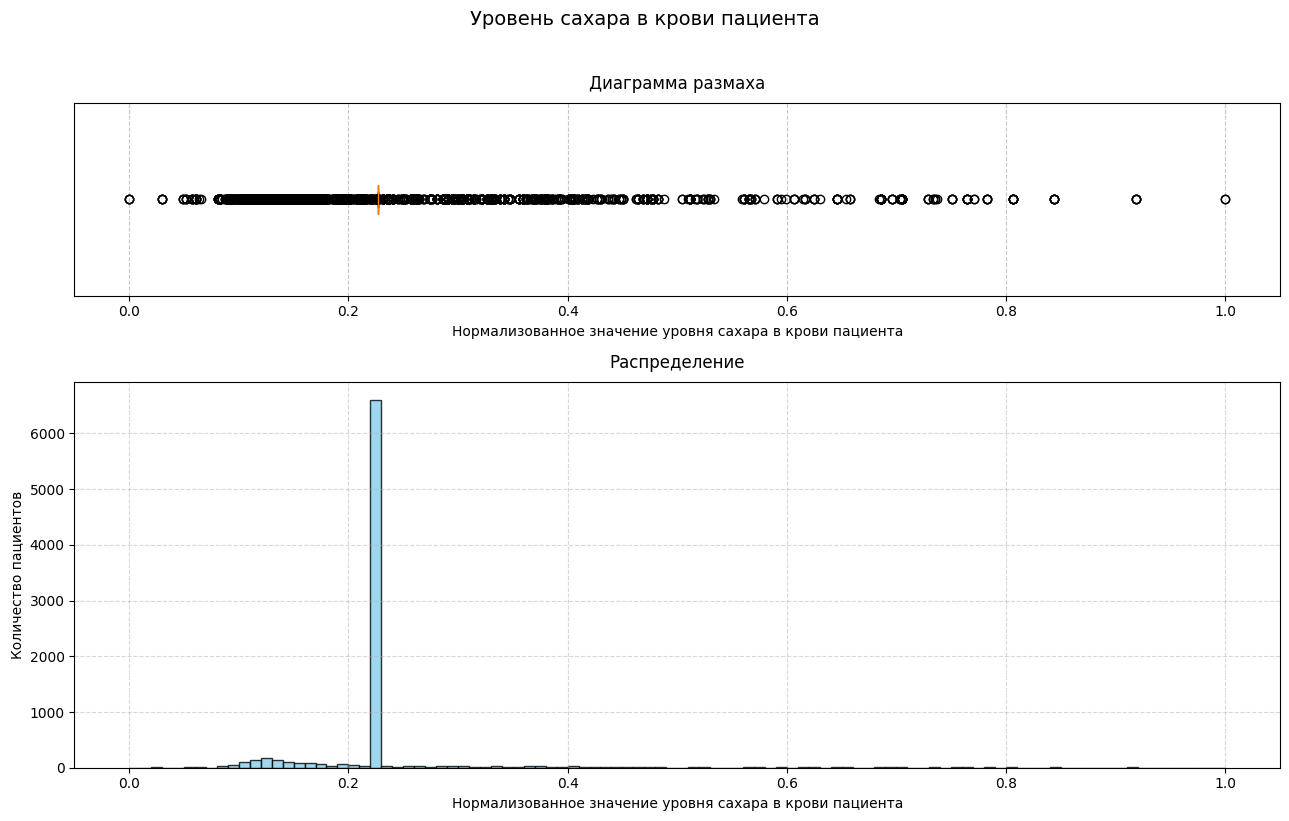

count    8430.000000
mean        0.228034
std         0.074625
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

In [33]:
# выведем график распределения
plot_data_analysis(heart['blood_sugar'],
                   title='Уровень сахара в крови пациента',
                   x_label='Нормализованное значение уровня сахара в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=100
                   )

**Комментарий**: рассмотрим распределение в логарифмической шкале по количеству пациентов.

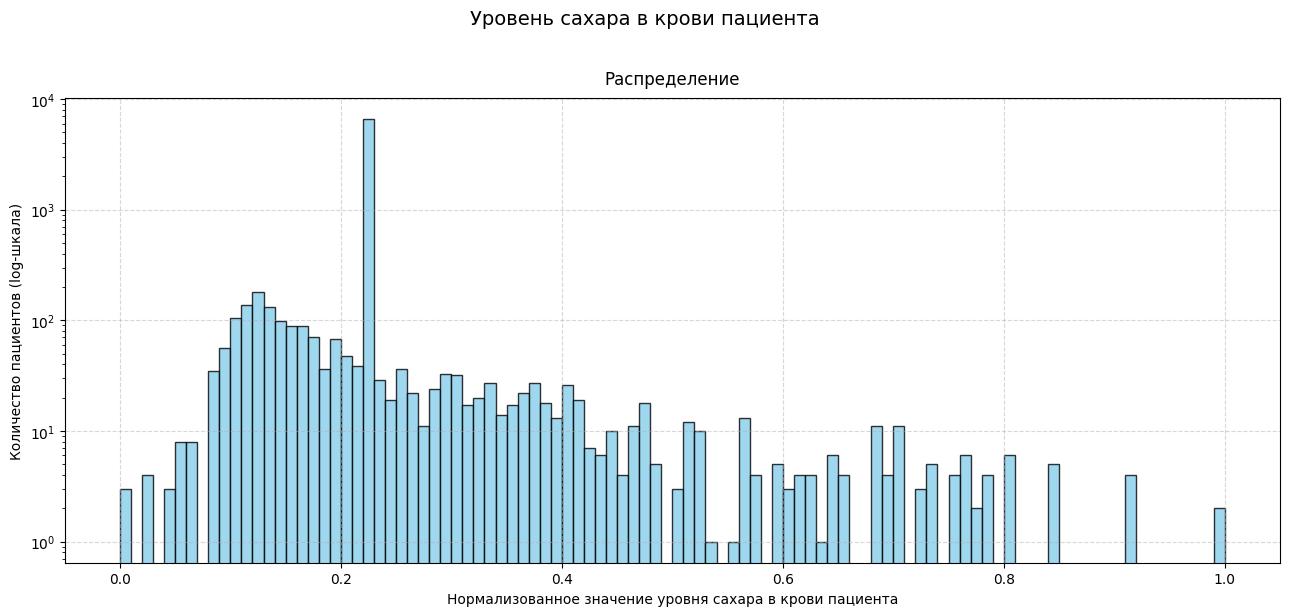

count    8430.000000
mean        0.228034
std         0.074625
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

In [34]:
# выведем график распределения
plot_data_analysis(heart['blood_sugar'],
                   title='Уровень сахара в крови пациента',
                   x_label='Нормализованное значение уровня сахара в крови пациента',
                   y_label='Количество пациентов (log-шкала)',
                   discrete=False,
                   plot_box=False,
                   bins=100,
                   log = True
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Данные неестественно сконцентрированы вокруг значения $\sim$**0.227**. Кажется, что в реальности распределение сахара в крови должно быть более плавным. Однако, максимум на **0.227** может судить о том, что либо большинство пациентов имеет нормальное значение сахара в крови, либо это пациенты, значения для которых были заполнены какой-то величиной по умолчанию. Посмотрим подробнее диаграммы рассеяния, обратим внимания на пары с признаком `blood_sugar`.

**Комментарий**: на диаграммых рассеяния с `blood_sugar` видно отчетливо область с однаковыми значениями (линии). Похоже, что в `blood_sugar` имелось большое количество пропусков, которые были заполнены значением по умолчанию. Это может вносить сильные искажения в данных, т.к. таких пациентов очень много.

In [35]:
# выведем топ частые значения
heart['blood_sugar'].value_counts().head(10)

blood_sugar
0.227018    6551
0.128458      52
0.102767      52
0.116601      49
0.124506      42
0.120553      37
0.136364      36
0.132411      29
0.158103      28
0.134387      28
Name: count, dtype: int64

**Комментарий**: предлагается следующая стратегия. Несмотря на то, что всего таких пациентов $>70\%$, отбросим большую часть из них, оставим случайную выброку из пациентов с этим показателем сахара в крови. При этом размер выборки составит:
\begin{equation}
P = \frac{N_{left} - N_{right}}{2},
\end{equation}

где $N_{left}$ -- количество пациентов для соседнего меньшего значения показателя сахара в крови, $N_{right}$ -- количество пациентов для соседнего большего значения показателя сахара в крови.

Таким образом мы оставим common value для сахара в крови в распределении и в обучении модели, но существенно снизим зашумленность данных.

In [36]:
# находим значение, которое встречатся чаще всего
value_counts = heart['blood_sugar'].value_counts()
most_common_val = value_counts.index[0]
most_common_count = value_counts.iloc[0]

print(f"Самое популярное значение: {most_common_val} ({most_common_count} пациентов)")

# ищем и берем ближайших соседей слева и справ
all_values_sorted = sorted(heart['blood_sugar'].unique())
target_idx = all_values_sorted.index(most_common_val)
left_neighbor = all_values_sorted[target_idx - 1] if target_idx > 0 else None
right_neighbor = all_values_sorted[target_idx + 1] if target_idx < len(all_values_sorted) - 1 else None

print(f"Соседи: слева={left_neighbor}, справа={right_neighbor}")

# считаем среднее количество пациентов у соседей
neighbor_counts = []
if left_neighbor is not None:
    left_count = (heart['blood_sugar'] == left_neighbor).sum()
    neighbor_counts.append(left_count)
    print(f"Левый сосед {left_neighbor}: {left_count} пациентов")
    
if right_neighbor is not None:
    right_count = (heart['blood_sugar'] == right_neighbor).sum()
    neighbor_counts.append(right_count)
    print(f"Правый сосед {right_neighbor}: {right_count} пациентов")

# получаем значение, сколько нам оставить пациентов от самого частого
n_to_keep = int(np.mean(neighbor_counts)) if neighbor_counts else min(50, most_common_count)
print(f"Оставляем {n_to_keep} случайных пациентов с blood_sugar = {most_common_val}")

# берем радномных пациков заданного количества
popular_indices = heart[heart['blood_sugar'] == most_common_val].index
np.random.seed(RANDOM_STATE)
keep_indices = np.random.choice(popular_indices, size=n_to_keep, replace=False)

prev_size = heart.shape[0]

# собираем даные
heart = pd.concat([
    heart[heart['blood_sugar'] != most_common_val],
    heart.loc[keep_indices]
])

print(f"Было: {prev_size} пациентов")
print(f"Стало: {len(heart)} пациентов")
print(f"Убрали {most_common_count - n_to_keep} пациентов с популярным значением")

Самое популярное значение: 0.2270175751137986 (6551 пациентов)
Соседи: слева=0.225296442687747, справа=0.2272727272727272
Левый сосед 0.225296442687747: 12 пациентов
Правый сосед 0.2272727272727272: 10 пациентов
Оставляем 11 случайных пациентов с blood_sugar = 0.2270175751137986
Было: 8430 пациентов
Стало: 1890 пациентов
Убрали 6540 пациентов с популярным значением


**Комментарий**: Аномальные распределения в парных диаграммах с `blood_sugar` теперь не наблюдаются. Посмотрим снова на распределение показателя сахара в крови.

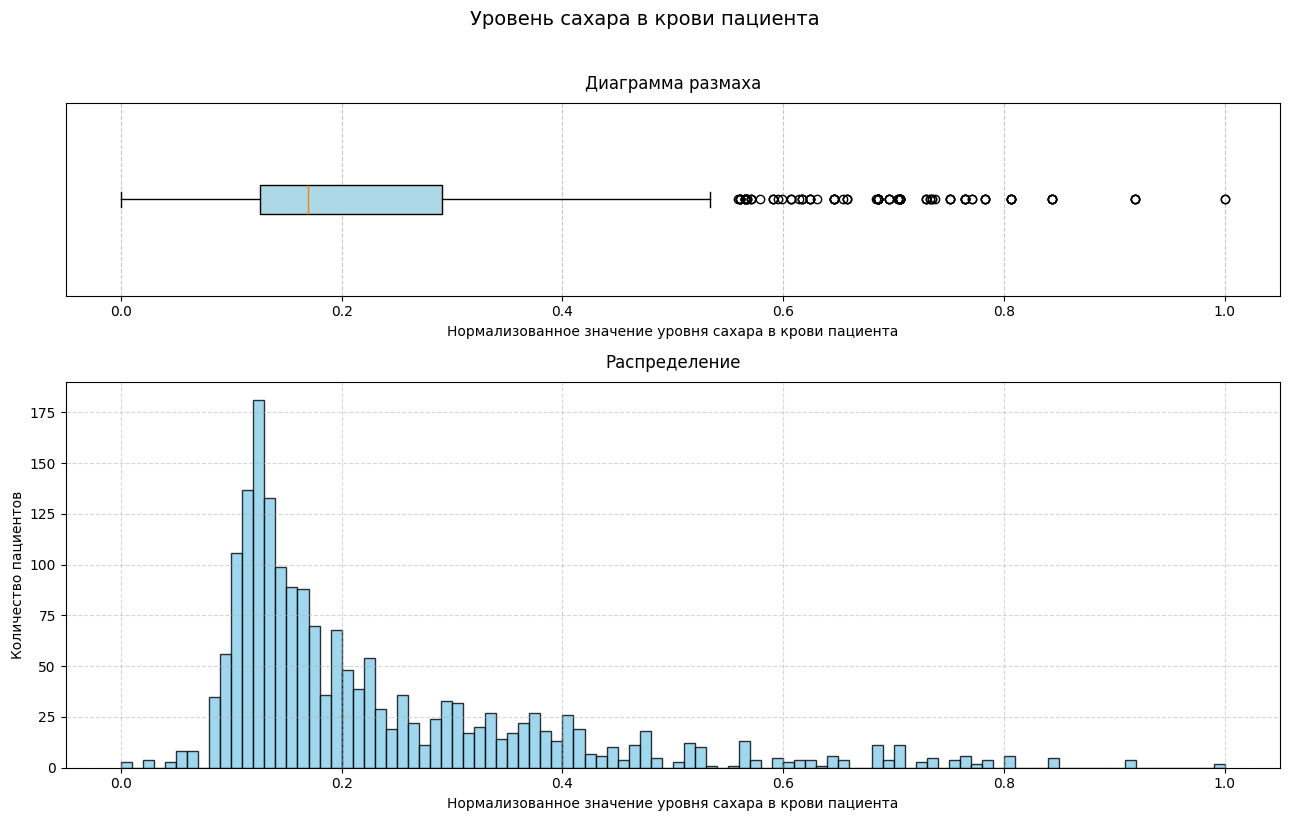

count    1890.000000
mean        0.231552
std         0.157585
min         0.000000
25%         0.126482
50%         0.169960
75%         0.290514
max         1.000000
Name: blood_sugar, dtype: float64

In [37]:
# выведем график распределения
plot_data_analysis(heart['blood_sugar'],
                   title='Уровень сахара в крови пациента',
                   x_label='Нормализованное значение уровня сахара в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=100,
                   log = False
                   )

In [38]:
# выведем значения распределения
result = heart.groupby(pd.cut(heart['blood_sugar'], bins=10))['heart_attack_risk_binary'].agg(['mean', 'count'])
print(result)

                   mean  count
blood_sugar                   
(-0.001, 0.1]  0.358974    117
(0.1, 0.2]     0.331678   1007
(0.2, 0.3]     0.374603    315
(0.3, 0.4]     0.294686    207
(0.4, 0.5]     0.339623    106
(0.5, 0.6]     0.306122     49
(0.6, 0.7]     0.324324     37
(0.7, 0.8]     0.285714     35
(0.8, 0.9]     0.363636     11
(0.9, 1.0]     0.500000      6


**Комментарий**: Распределение теперь выглядит гораздо адекватнее. Выбросы предлагается не трогать, количество пациентов для них единично, это могут быть вполне реальные критические показатели у отдельных людей. Построим распределение в заисимости от целевого показателя.

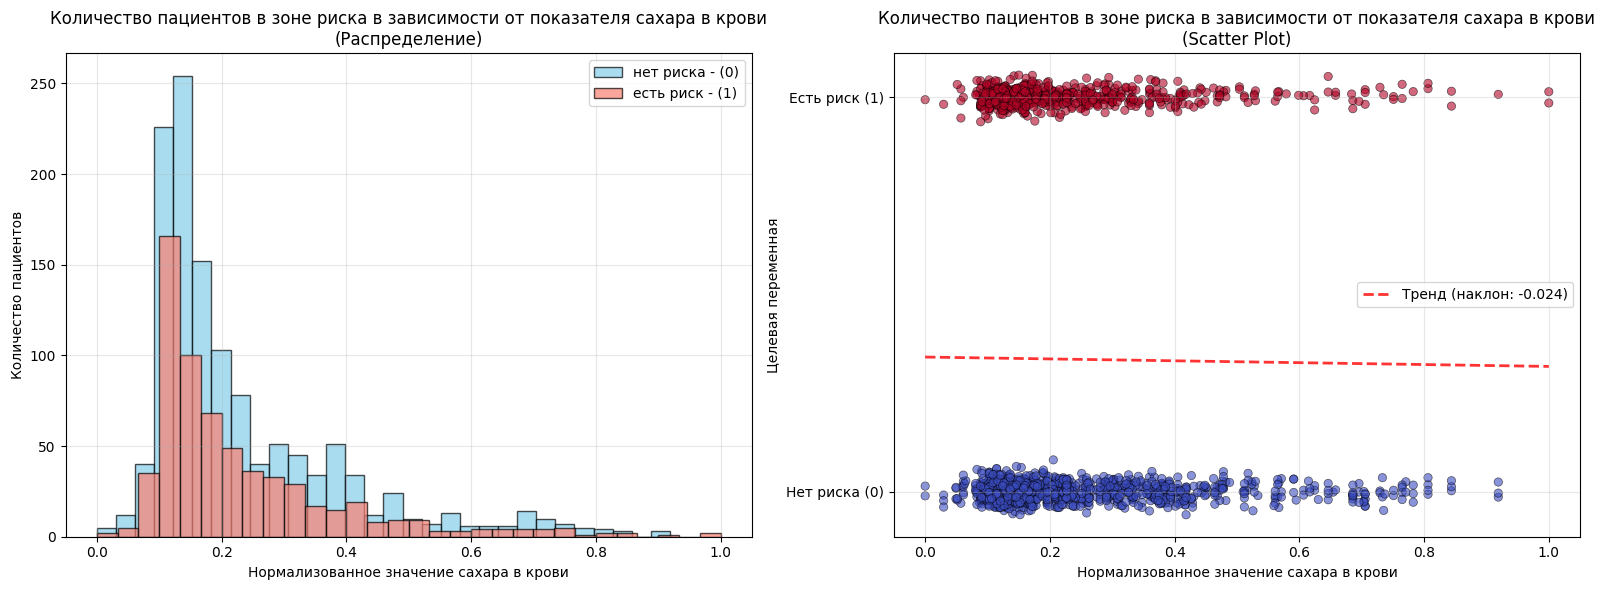

Статистика по blood_sugar:
Уникальных значений: 224
Тип данных: float64

Средние значения:
Без риска: 0.232
С риском: 0.230
Корреляция с целевой: -0.008
Разница средних (риск - нет риска): -0.003
Относительная разница: -1.14%


In [39]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'blood_sugar', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости ' \
                       'от показателя сахара в крови',
                       x_label='Нормализованное значение сахара в крови',
                       y_label='Количество пациентов',
                       bins=30
                       )

In [40]:
# посмотрим топ показателей
heart['blood_sugar'].value_counts().head(20)

blood_sugar
0.102767    52
0.128458    52
0.116601    49
0.124506    42
0.120553    37
0.136364    36
0.132411    29
0.114625    28
0.134387    28
0.158103    28
0.118577    27
0.126482    26
0.195652    25
0.162055    25
0.122530    24
0.130435    24
0.140316    22
0.156126    21
0.146245    21
0.142292    21
Name: count, dtype: int64

**Промежуточный вывод**: В целом в данных не наблюдается какого-то ярковыраженного смещения и зависимости риска проблем с сердцем от показателя сахара в крови. Было отброшено $\sim70\%$ данных, которые зашумляли выборку. Основное количество оставшихся в выборке пациентов сосредоточено в области $(0.1; 0.2]$ нормализованного показателя сахара в крови ($\sim1000$ пацентов).

#### Признак `age`

**Комментарий**: исследуем признак `age` -- возраст пациента.

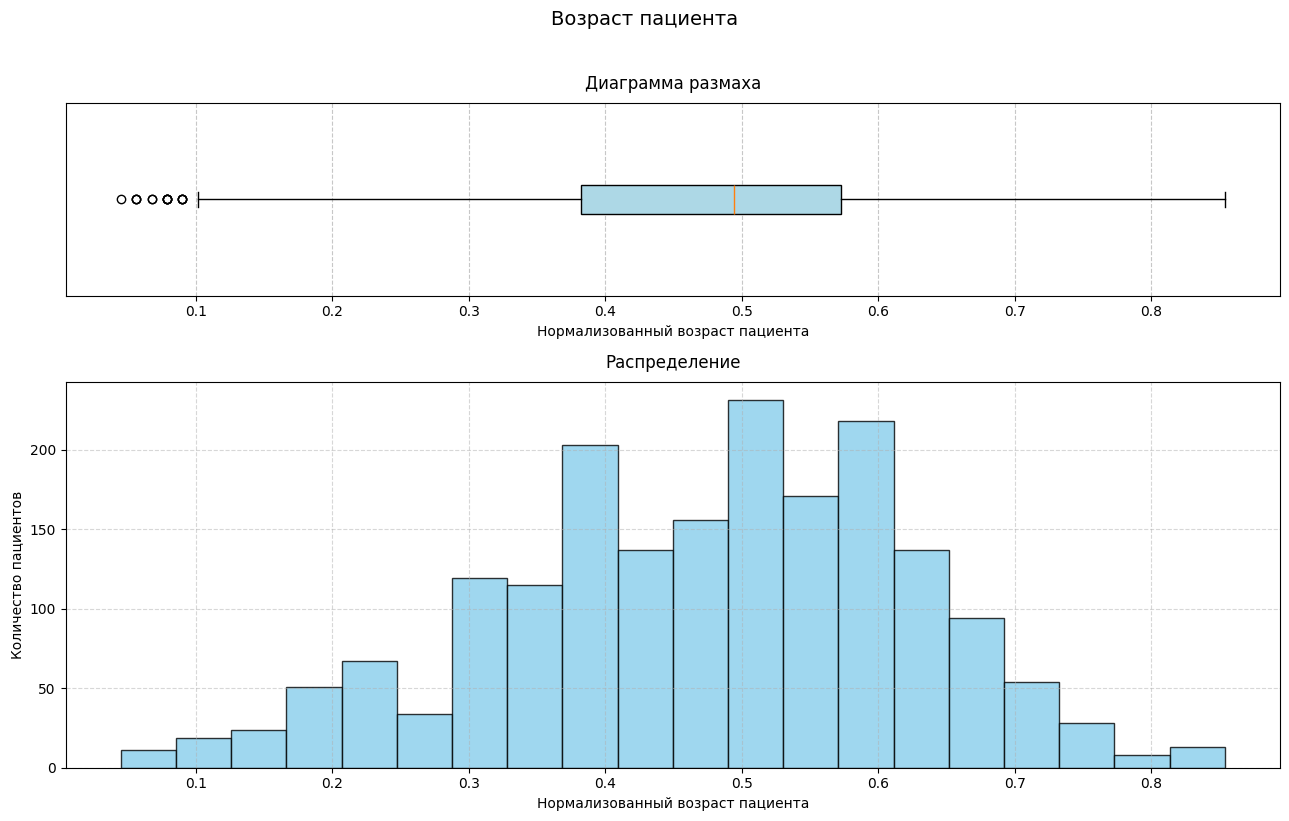

count    1890.000000
mean        0.473884
std         0.149593
min         0.044944
25%         0.382022
50%         0.494382
75%         0.573034
max         0.853933
Name: age, dtype: float64

In [41]:
# выведем график распределения
plot_data_analysis(heart['age'],
                   title='Возраст пациента',
                   x_label='Нормализованный возраст пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Наблюдаются выбросы в области меньших значений возраста, аномалий не наблюдается. Отбросим эти выбросы и посмотрим распределение по целевому признаку.

In [42]:
# уберем выбросы
print("Размерность данных до удаления выбросов:", heart.shape)
heart = heart[heart['age'] >= 0.1]
print("Размерность данных после удаления выбросов:", heart.shape)

Размерность данных до удаления выбросов: (1890, 24)
Размерность данных после удаления выбросов: (1875, 24)


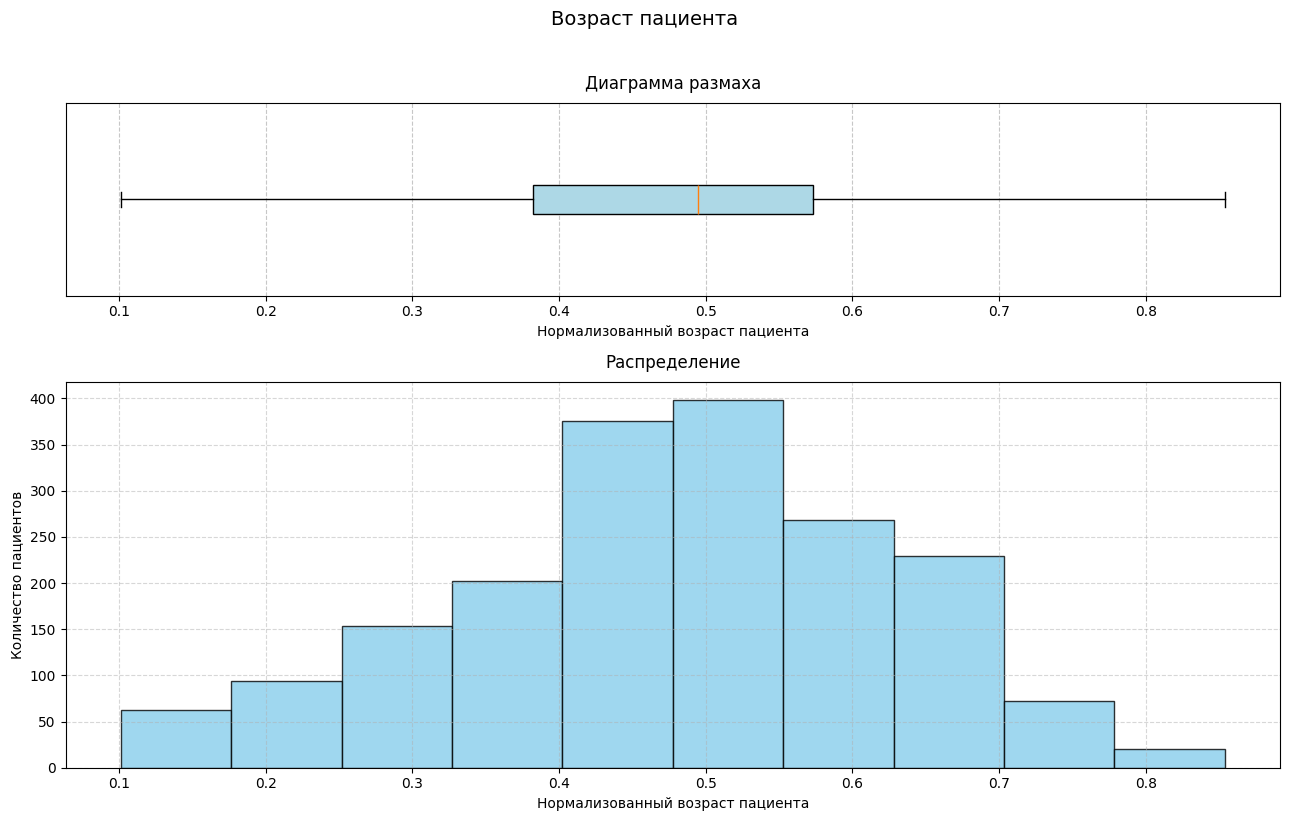

count    1875.000000
mean        0.477088
std         0.145814
min         0.101124
25%         0.382022
50%         0.494382
75%         0.573034
max         0.853933
Name: age, dtype: float64

In [43]:
# выведем график распределения
plot_data_analysis(heart['age'],
                   title='Возраст пациента',
                   x_label='Нормализованный возраст пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=10
                   )

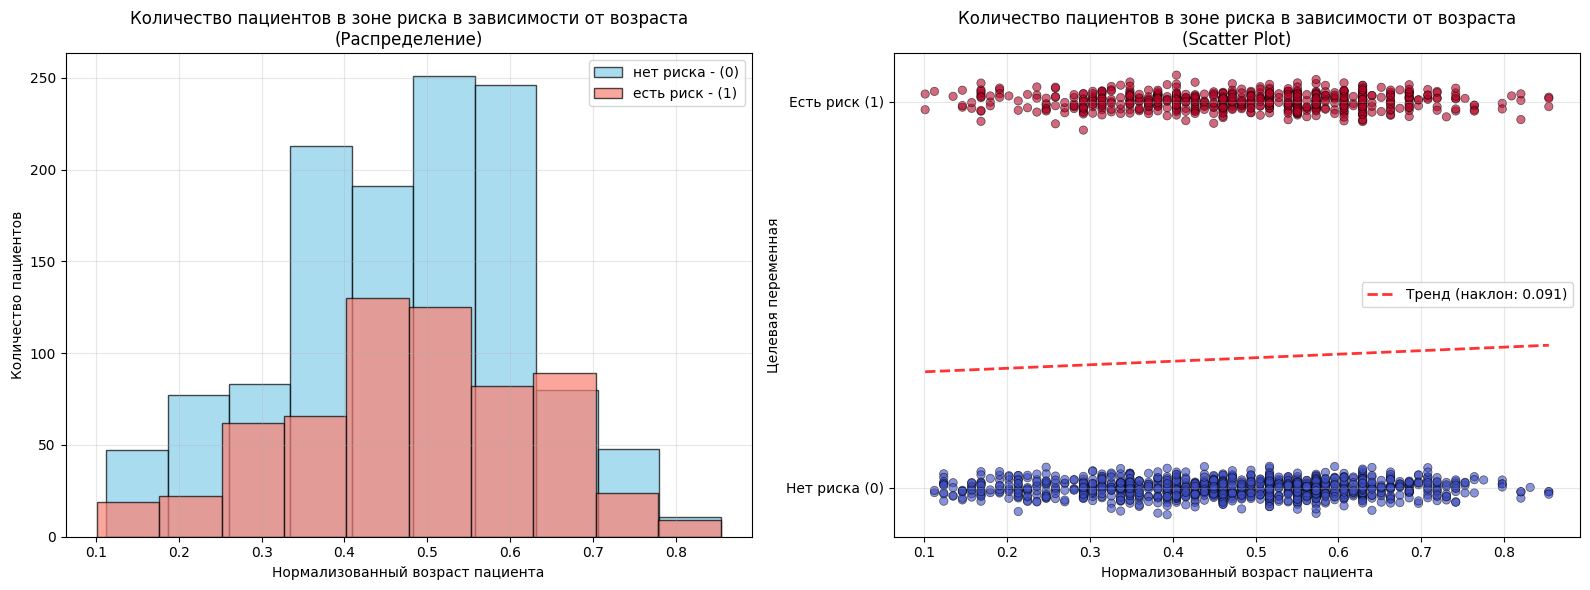

Статистика по age:
Уникальных значений: 66
Тип данных: float64

Средние значения:
Без риска: 0.474
С риском: 0.483
Корреляция с целевой: 0.028
Разница средних (риск - нет риска): 0.009
Относительная разница: 1.84%


In [44]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'age', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от возраста',
                       x_label='Нормализованный возраст пациента',
                       y_label='Количество пациентов',
                       bins=10
                       )

**Промежуточный вывод**: Есть очень слабый тренд в сторону повышения риска проблем с сердцем с увеличением возраста. Большая часть пациентов по возрасту сконцетрирована в области $[0.4;0.55]$.

#### Признак `cholesterol`

**Комментарий**: исследуем признак `cholesterol` -- уровень холестерина в крови пациента 

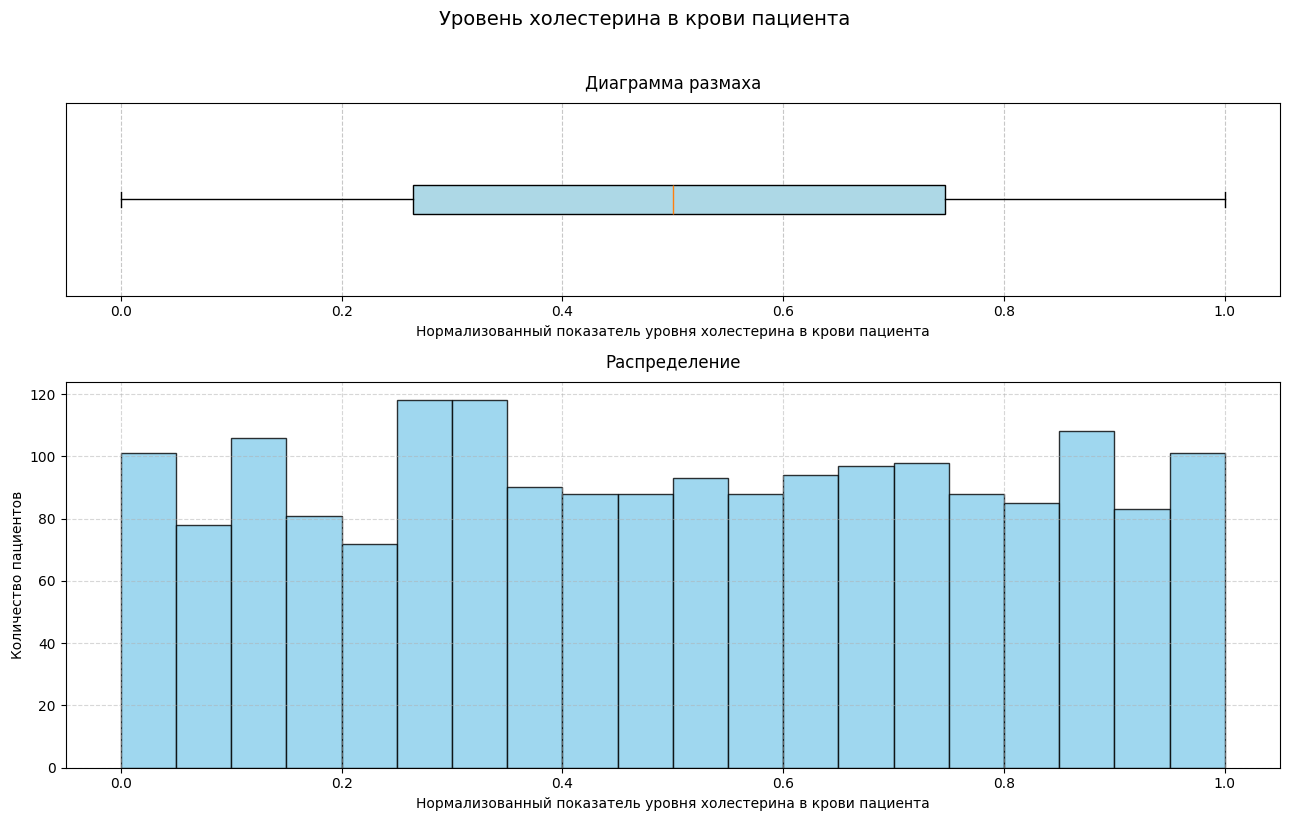

count    1875.000000
mean        0.501697
std         0.289231
min         0.000000
25%         0.264286
50%         0.500000
75%         0.746429
max         1.000000
Name: cholesterol, dtype: float64

In [45]:
# выведем график распределения
plot_data_analysis(heart['cholesterol'],
                   title='Уровень холестерина в крови пациента',
                   x_label='Нормализованный показатель уровня холестерина в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

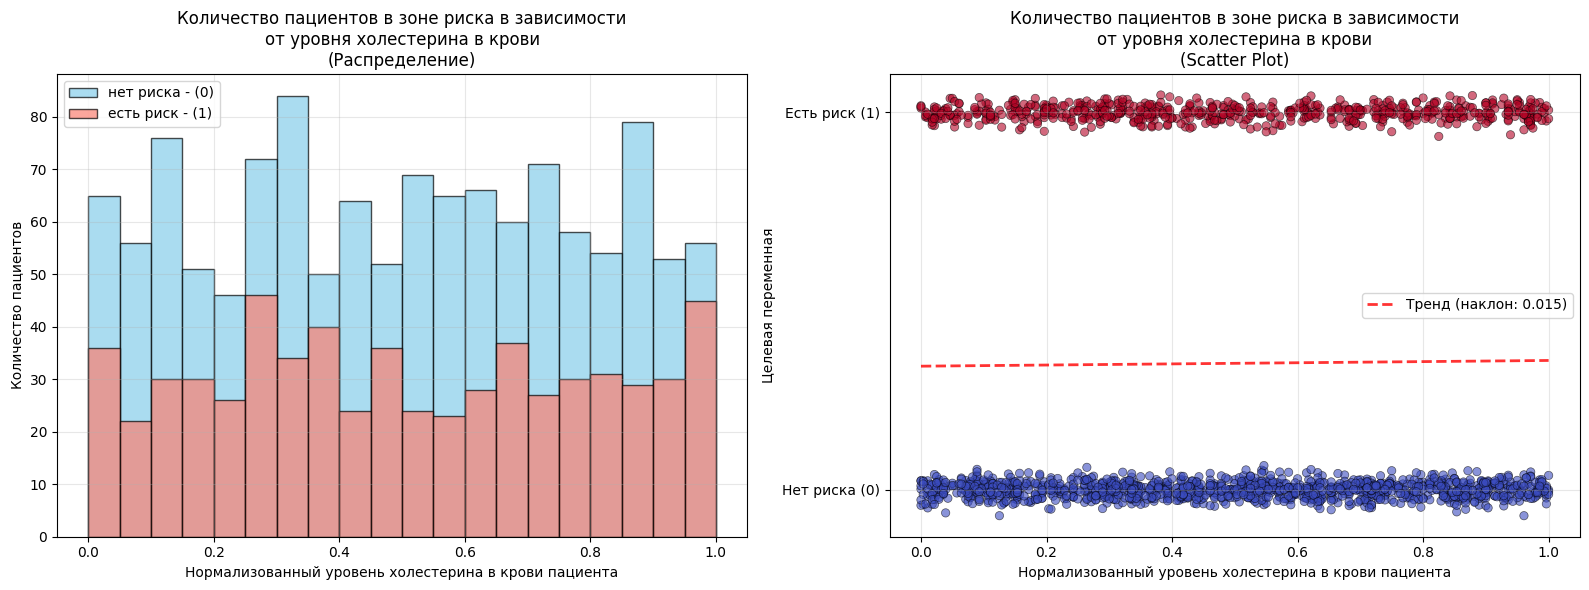

Статистика по cholesterol:
Уникальных значений: 276
Тип данных: float64

Средние значения:
Без риска: 0.500
С риском: 0.505
Корреляция с целевой: 0.009
Разница средних (риск - нет риска): 0.006
Относительная разница: 1.14%


In [46]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'cholesterol', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от уровня холестерина в крови',
                       x_label='Нормализованный уровень холестерина в крови пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с увеличением показателя холестирина в крови.

#### Признак `heart_rate`

**Комментарий**: исследуем признак `heart_rate` -- пульс пациента.

In [47]:
# выведем график распределения
plot_data_analysis(heart['heart_rate'],
                   title='Пульс пациента',
                   x_label='Нормализованное значение пульса пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

count    1875.000000
mean        0.049883
std         0.011738
min         0.018332
25%         0.039413
50%         0.049496
75%         0.057745
max         0.082493
Name: heart_rate, dtype: float64

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

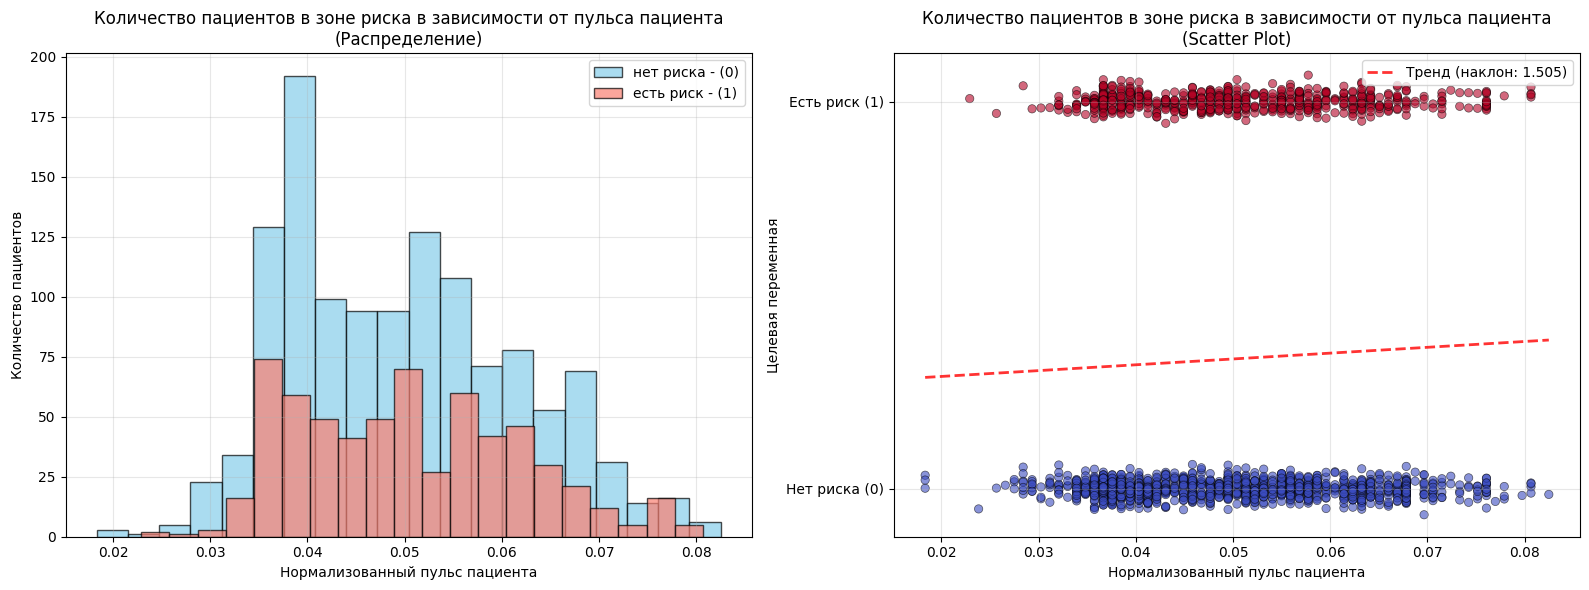

Статистика по heart_rate:
Уникальных значений: 64
Тип данных: float64

Средние значения:
Без риска: 0.050
С риском: 0.051
Корреляция с целевой: 0.037
Разница средних (риск - нет риска): 0.001
Относительная разница: 1.88%


In [48]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'heart_rate', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от пульса пациента',
                       x_label='Нормализованный пульс пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Есть слабый тренд смещения в сторону повышения риска проблем с сердцем с увеличением пульса пациентов.

#### Признак `exercise_hours_per_week`

**Комментарий**: исследуем признак `exercise_hours_per_week` -- количество часов физических упражнений в неделю.

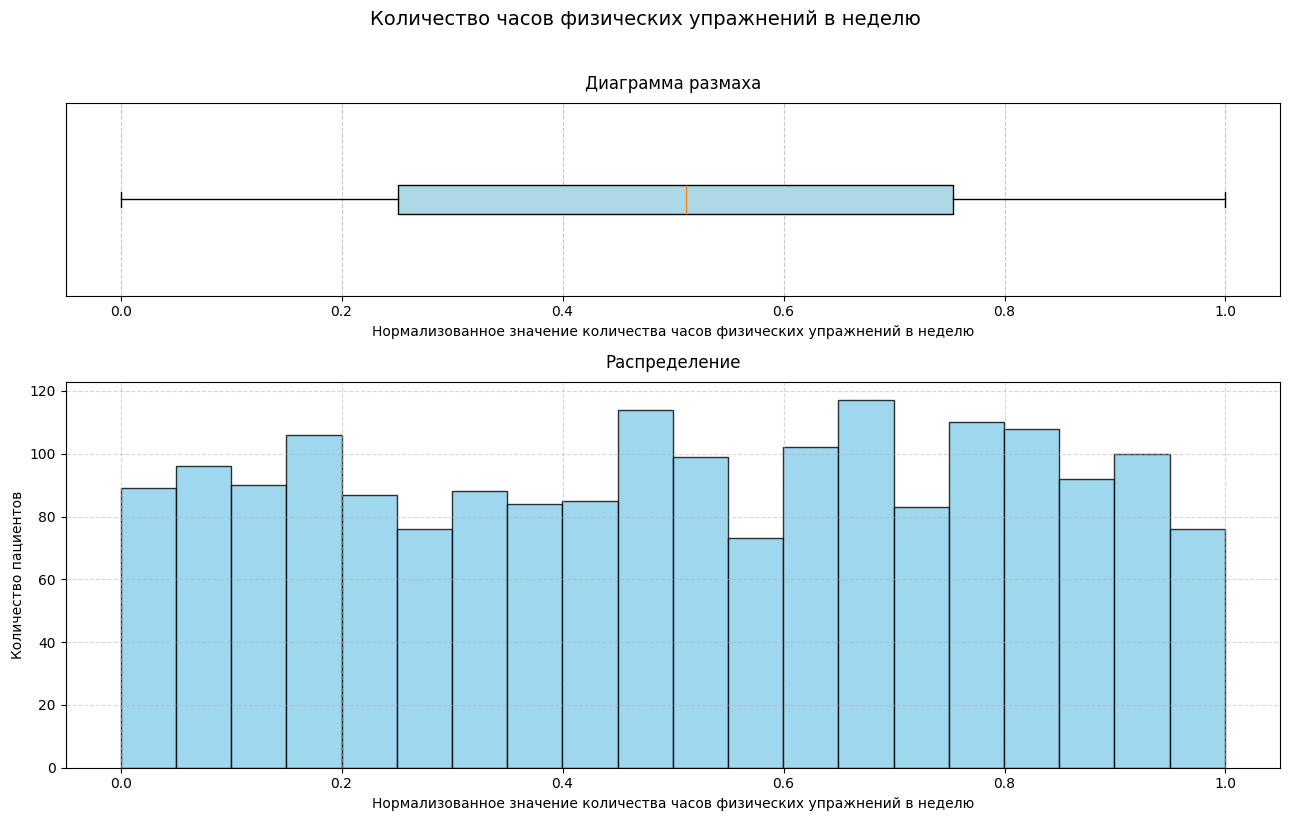

count    1875.000000
mean        0.505472
std         0.287064
min         0.000249
25%         0.251332
50%         0.511616
75%         0.753032
max         0.999382
Name: exercise_hours_per_week, dtype: float64

In [49]:
# выведем график распределения
plot_data_analysis(heart['exercise_hours_per_week'],
                   title='Количество часов физических упражнений в неделю',
                   x_label='Нормализованное значение количества часов физических упражнений в неделю',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

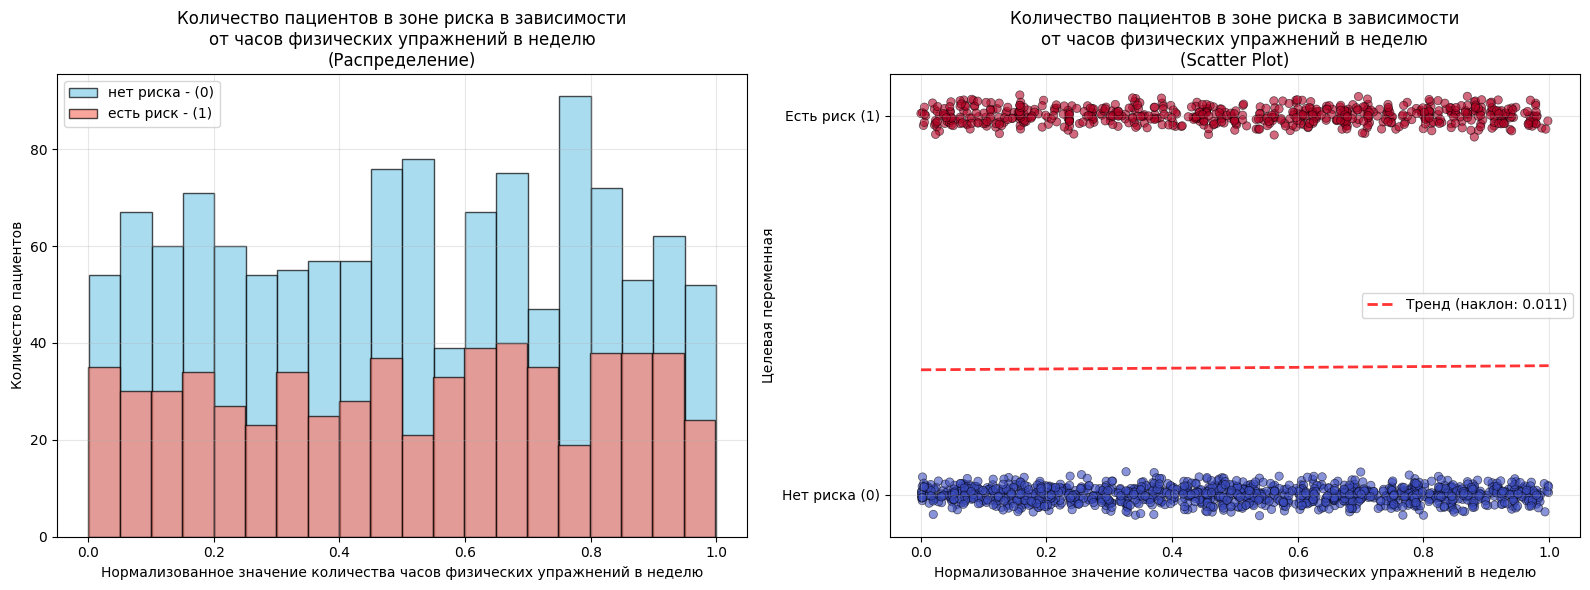

Статистика по exercise_hours_per_week:
Уникальных значений: 1378
Тип данных: float64

Средние значения:
Без риска: 0.504
С риском: 0.508
Корреляция с целевой: 0.007
Разница средних (риск - нет риска): 0.004
Относительная разница: 0.79%


In [50]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'exercise_hours_per_week', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от часов физических упражнений в неделю',
                       x_label='Нормализованное значение количества часов физических упражнений в неделю',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с уменьшением количества часов упражнений в день.

#### Признак `sedentary_hours_per_day`

**Комментарий**: исследуем признак `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении.

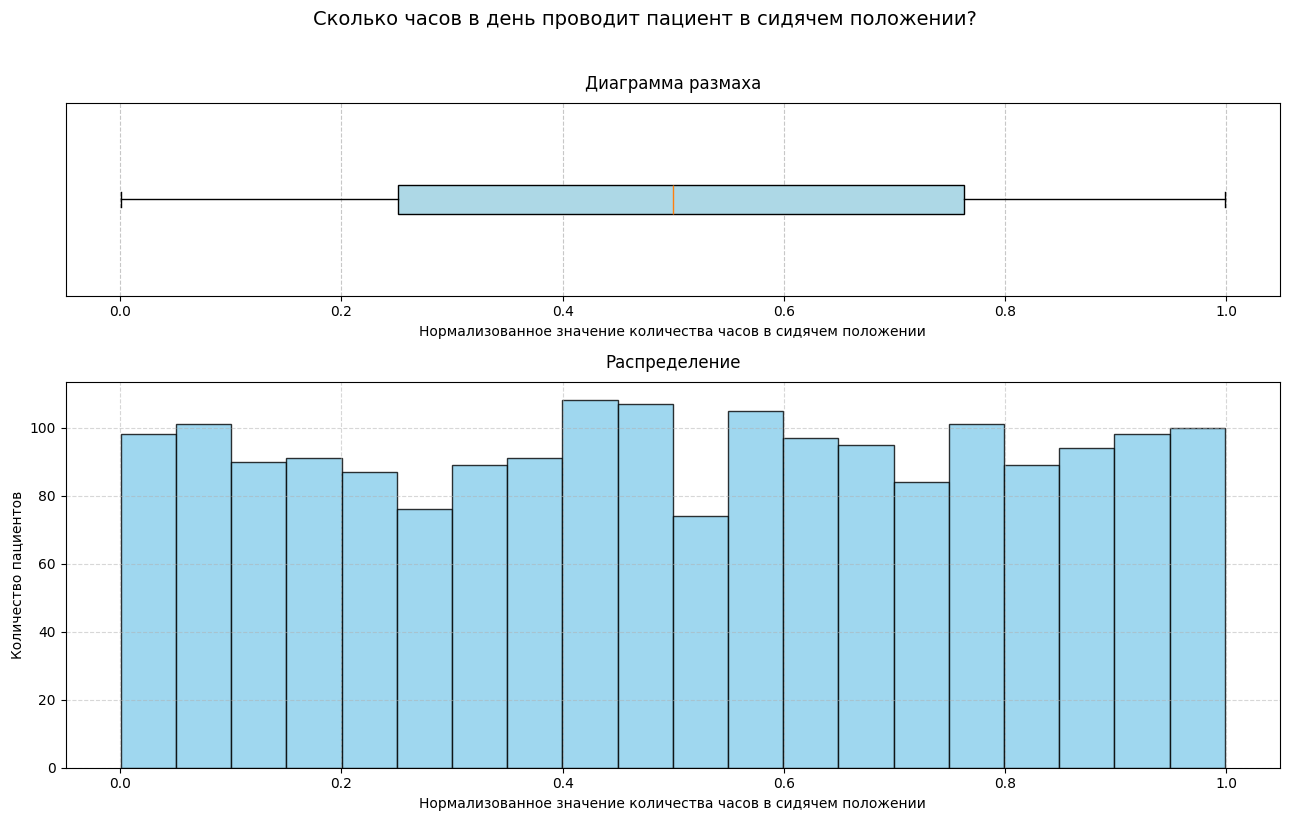

count    1875.000000
mean        0.503060
std         0.290497
min         0.000587
25%         0.250695
50%         0.499495
75%         0.762718
max         0.998529
Name: sedentary_hours_per_day, dtype: float64

In [51]:
# выведем график распределения
plot_data_analysis(heart['sedentary_hours_per_day'],
                   title='Сколько часов в день проводит пациент в сидячем положении?',
                   x_label='Нормализованное значение количества часов в сидячем положении',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

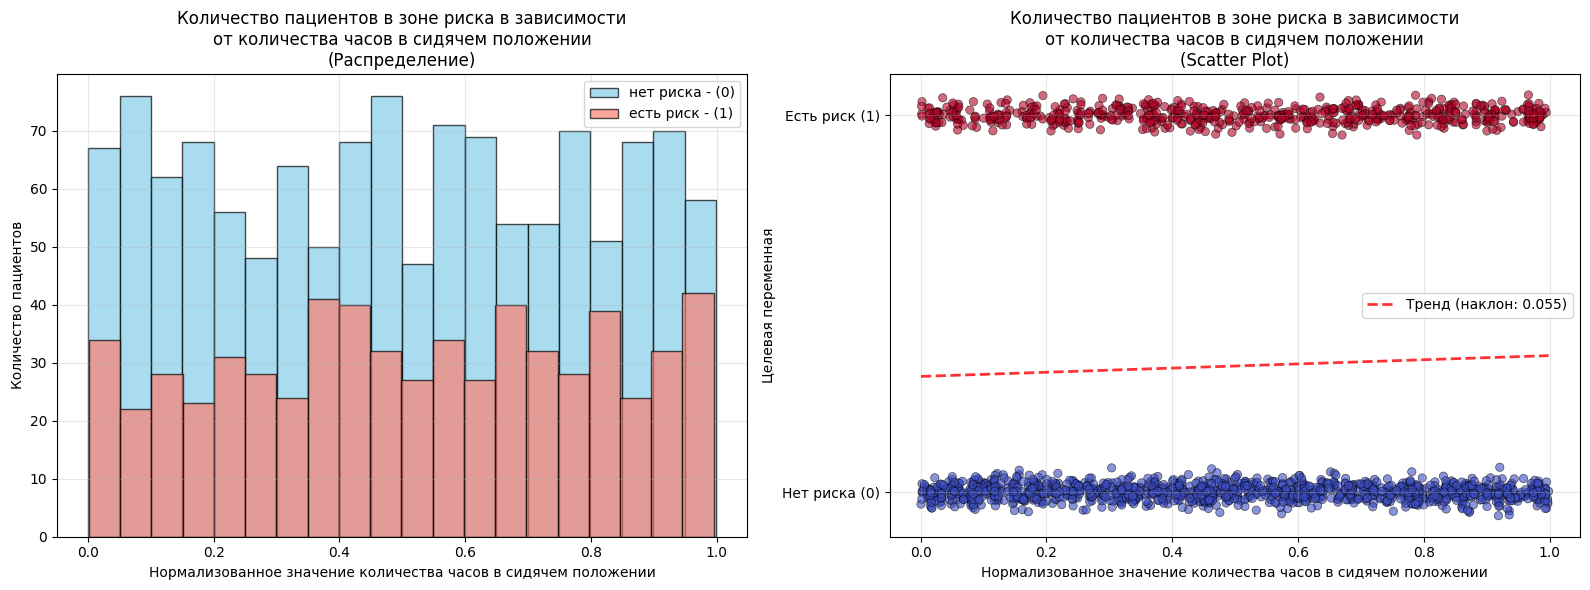

Статистика по sedentary_hours_per_day:
Уникальных значений: 1378
Тип данных: float64

Средние значения:
Без риска: 0.496
С риском: 0.517
Корреляция с целевой: 0.034
Разница средних (риск - нет риска): 0.021
Относительная разница: 4.21%


In [52]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'sedentary_hours_per_day', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от количества часов в сидячем положении',
                       x_label='Нормализованное значение количества часов в сидячем положении',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Присутствует слабый тренд в сторону повышения риска проблем с сердцем с увеличением количества сидячих часов в сутки.

#### Признак `income`

**Комментарий**: исследуем признак `income` -- уровень дохода пациента.

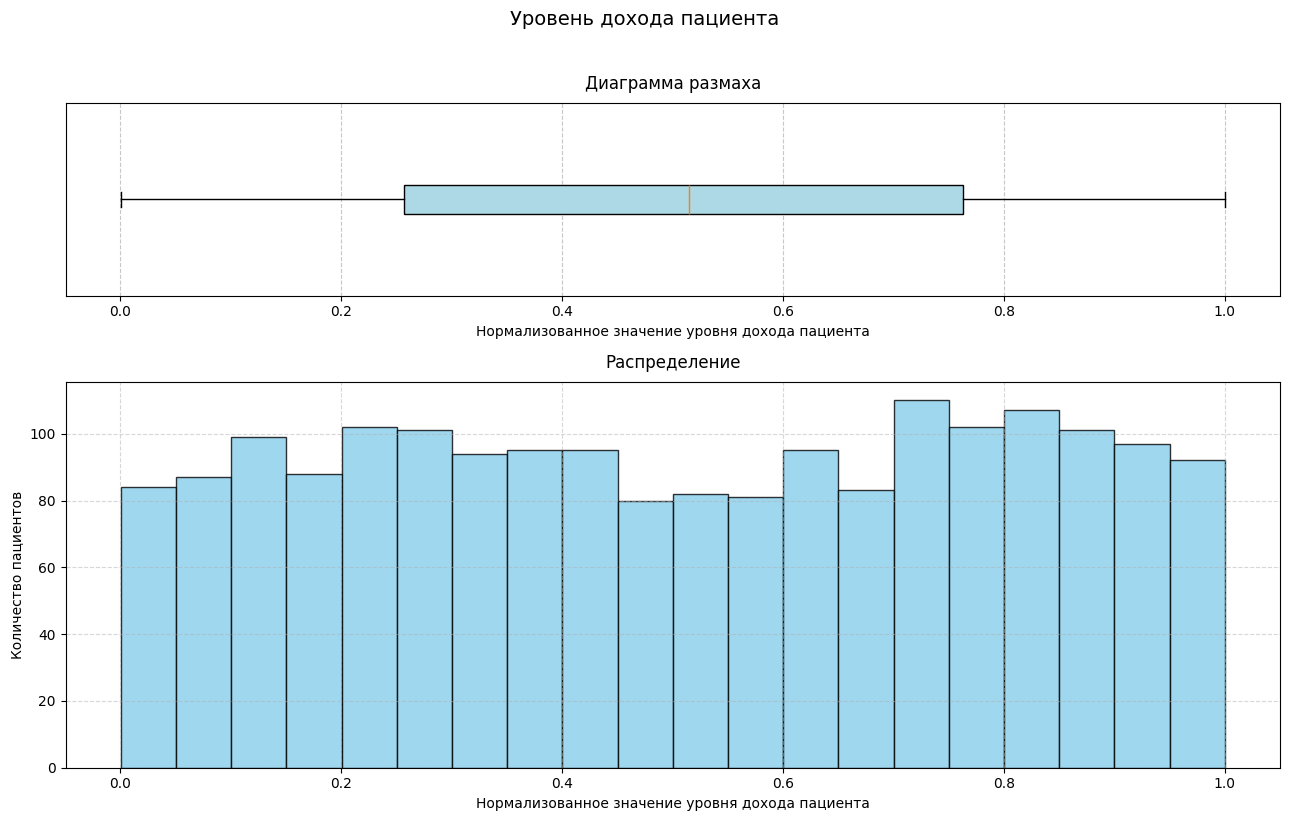

count    1875.000000
mean        0.508207
std         0.289543
min         0.000368
25%         0.257099
50%         0.514377
75%         0.762526
max         1.000000
Name: income, dtype: float64

In [53]:
# выведем график распределения
plot_data_analysis(heart['income'],
                   title='Уровень дохода пациента',
                   x_label='Нормализованное значение уровня дохода пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

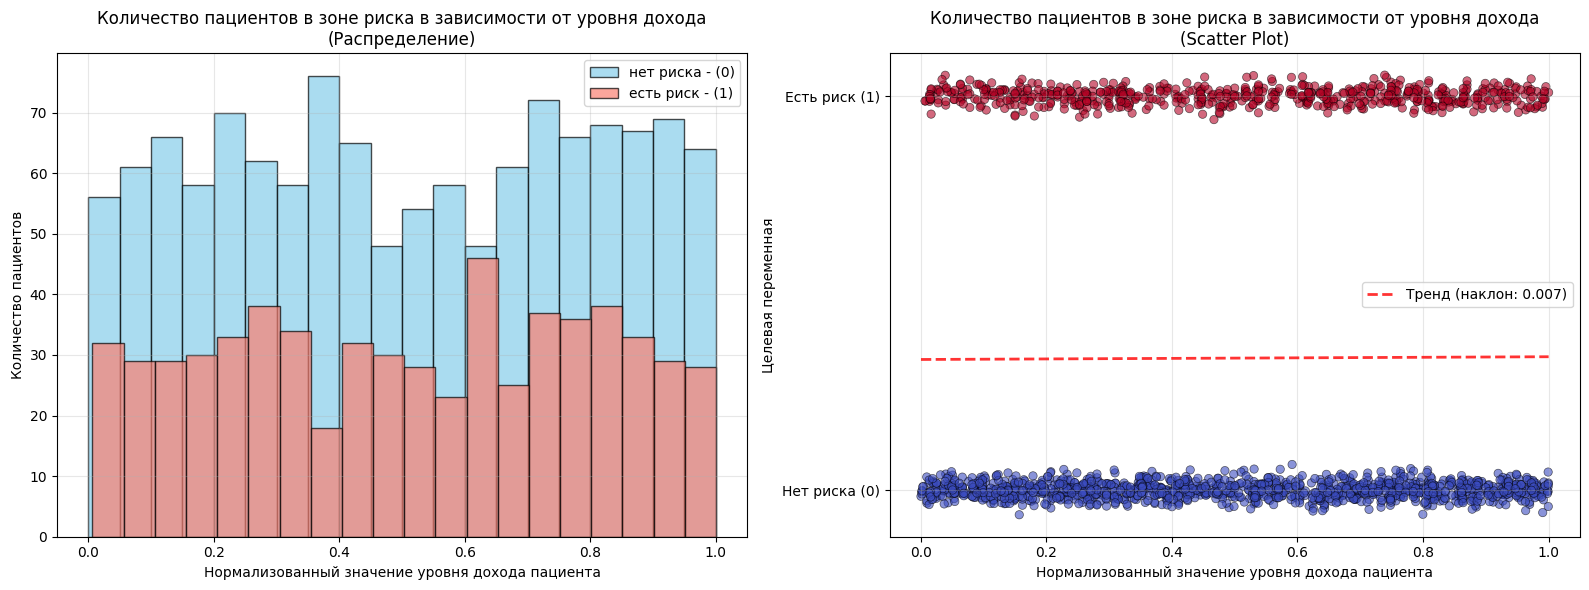

Статистика по income:
Уникальных значений: 1372
Тип данных: float64

Средние значения:
Без риска: 0.507
С риском: 0.510
Корреляция с целевой: 0.004
Разница средних (риск - нет риска): 0.003
Относительная разница: 0.52%


In [54]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'income', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня дохода',
                       x_label='Нормализованный значение уровня дохода пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с уменьшением дохода.

#### Признак `bmi`

**Комментарий**: исследуем признак `bmi` -- ИМТ -- индекс массы тела пациента.

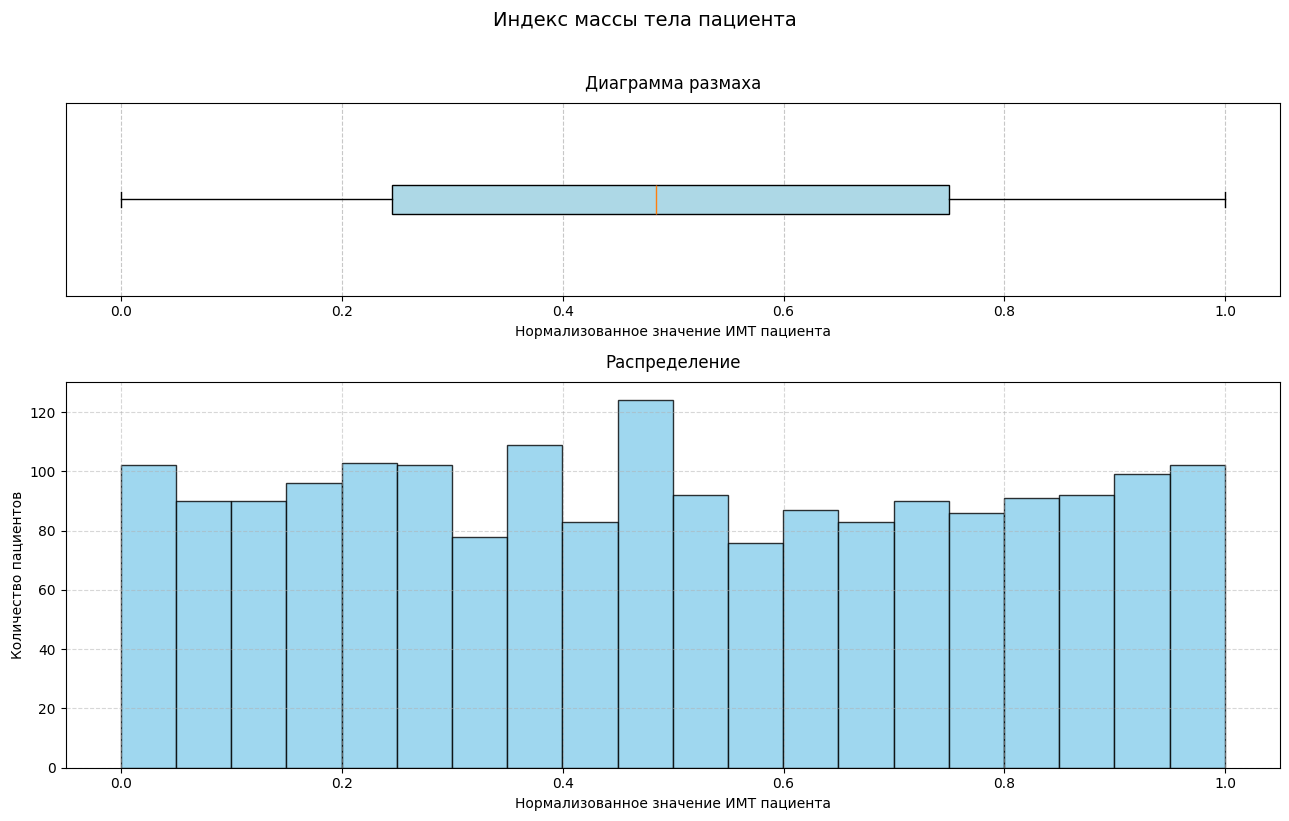

count    1875.000000
mean        0.495571
std         0.290336
min         0.000000
25%         0.245375
50%         0.484626
75%         0.750208
max         0.999450
Name: bmi, dtype: float64

In [55]:
# выведем график распределения
plot_data_analysis(heart['bmi'],
                   title='Индекс массы тела пациента',
                   x_label='Нормализованное значение ИМТ пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

In [56]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'bmi', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от ИМТ пациента',
                       x_label='Нормализованное значение ИМТ пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

Статистика по bmi:
Уникальных значений: 1378
Тип данных: float64

Средние значения:
Без риска: 0.500
С риском: 0.486
Корреляция с целевой: -0.023
Разница средних (риск - нет риска): -0.014
Относительная разница: -2.81%


**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с увеличением ИМТ.

#### Признак `triglycerides`

**Комментарий**: исследуем признак `triglycerides` -- уровень триглициридов в крови пациента.

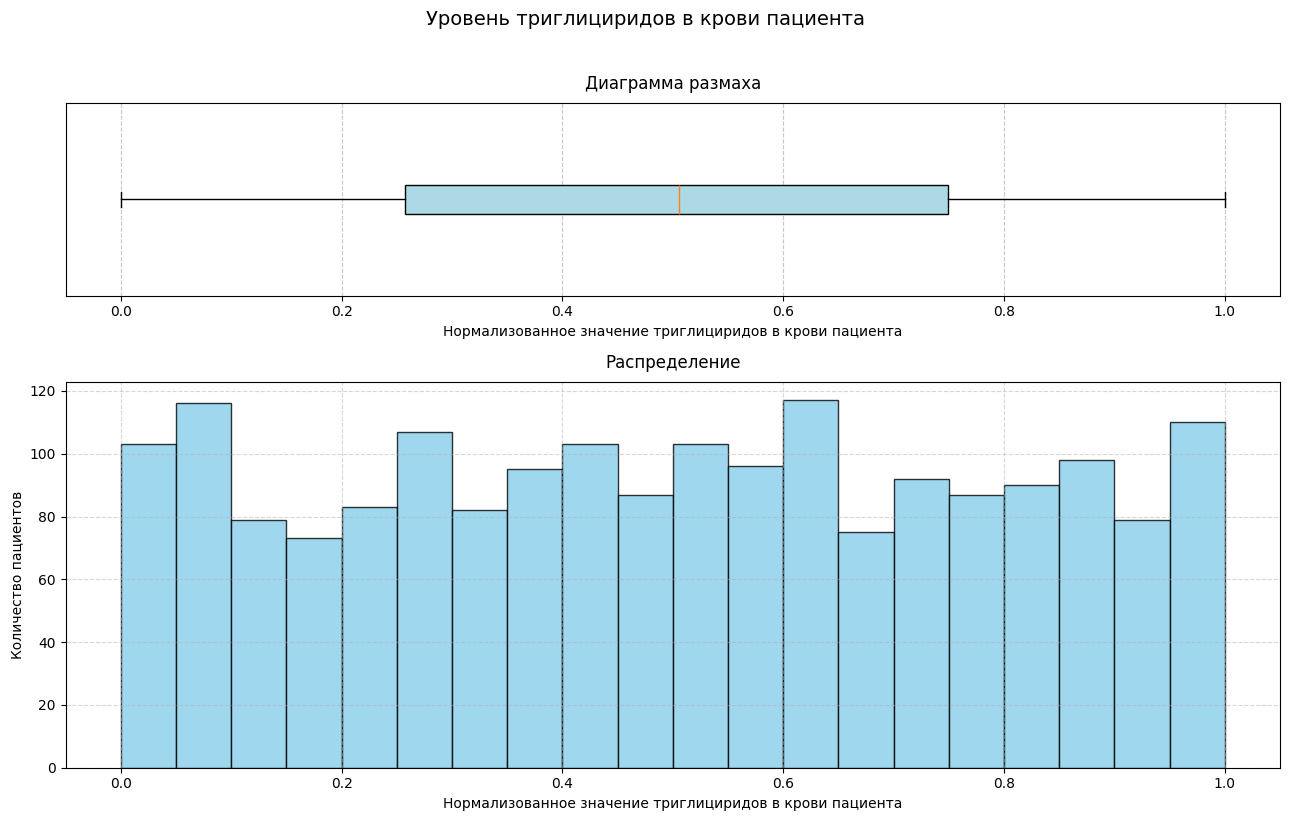

count    1875.000000
mean        0.500371
std         0.290661
min         0.000000
25%         0.257792
50%         0.505195
75%         0.749351
max         1.000000
Name: triglycerides, dtype: float64

In [57]:
# выведем график распределения
plot_data_analysis(heart['triglycerides'],
                   title='Уровень триглициридов в крови пациента',
                   x_label='Нормализованное значение триглициридов в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

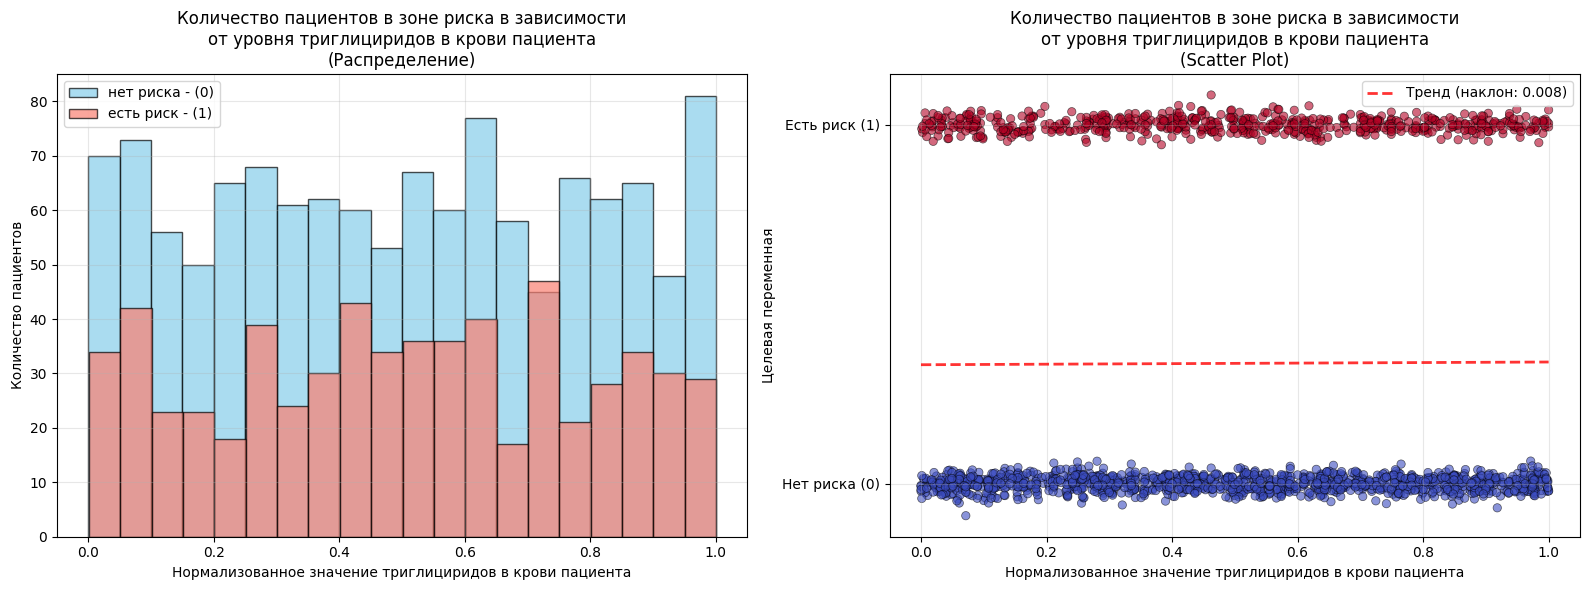

Статистика по triglycerides:
Уникальных значений: 641
Тип данных: float64

Средние значения:
Без риска: 0.499
С риском: 0.502
Корреляция с целевой: 0.005
Разница средних (риск - нет риска): 0.003
Относительная разница: 0.58%


In [58]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'triglycerides', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от уровня триглициридов в крови пациента',
                       x_label='Нормализованное значение триглициридов в крови пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с изменением количества триглециридов в крови.

#### Признак `physical_activity_days_per_week`

**Комментарий**: исследуем признак `physical_activity_days_per_week` -- количество дней в неделю с физической активностью.

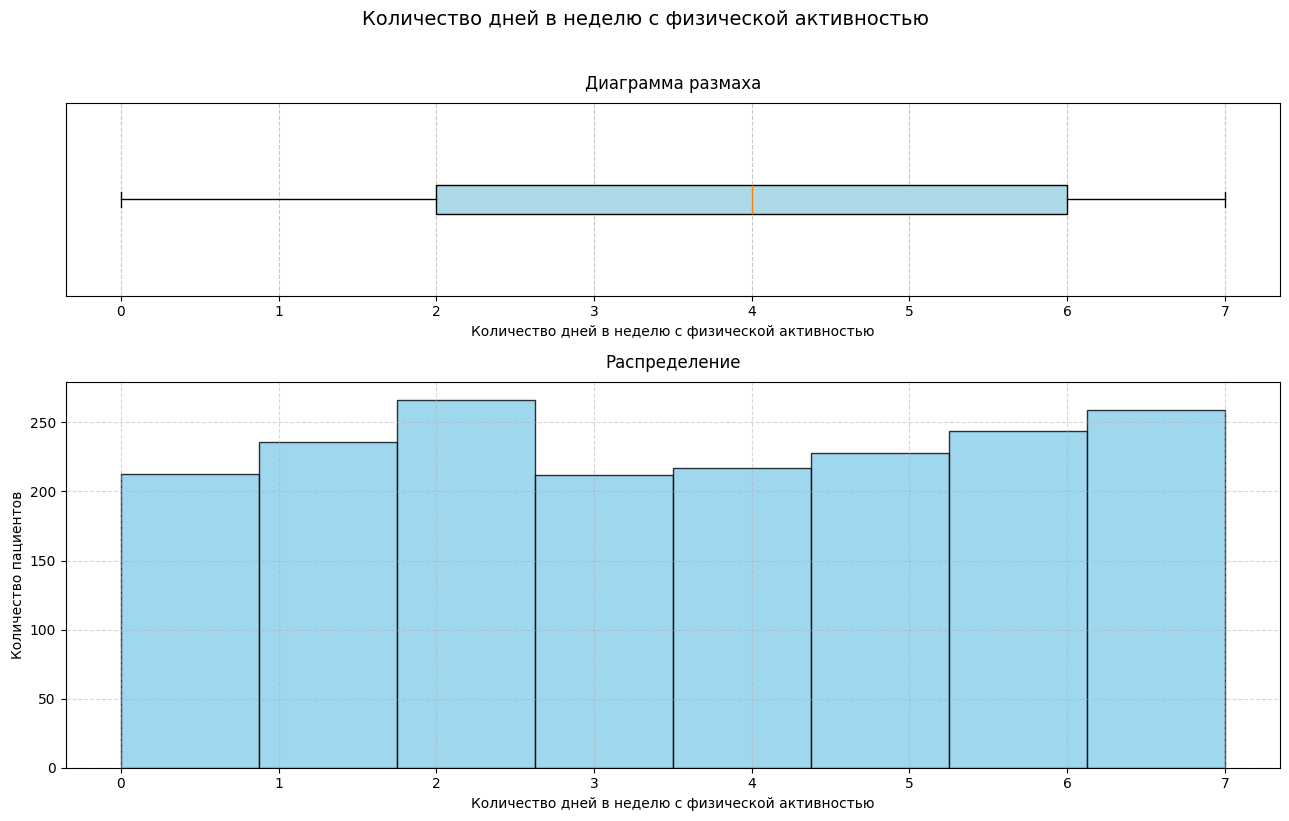

count    1875.000000
mean        3.567467
std         2.309118
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         7.000000
Name: physical_activity_days_per_week, dtype: float64

In [59]:
# выведем график распределения
plot_data_analysis(heart['physical_activity_days_per_week'],
                   title='Количество дней в неделю с физической активностью',
                   x_label='Количество дней в неделю с физической активностью',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=8
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

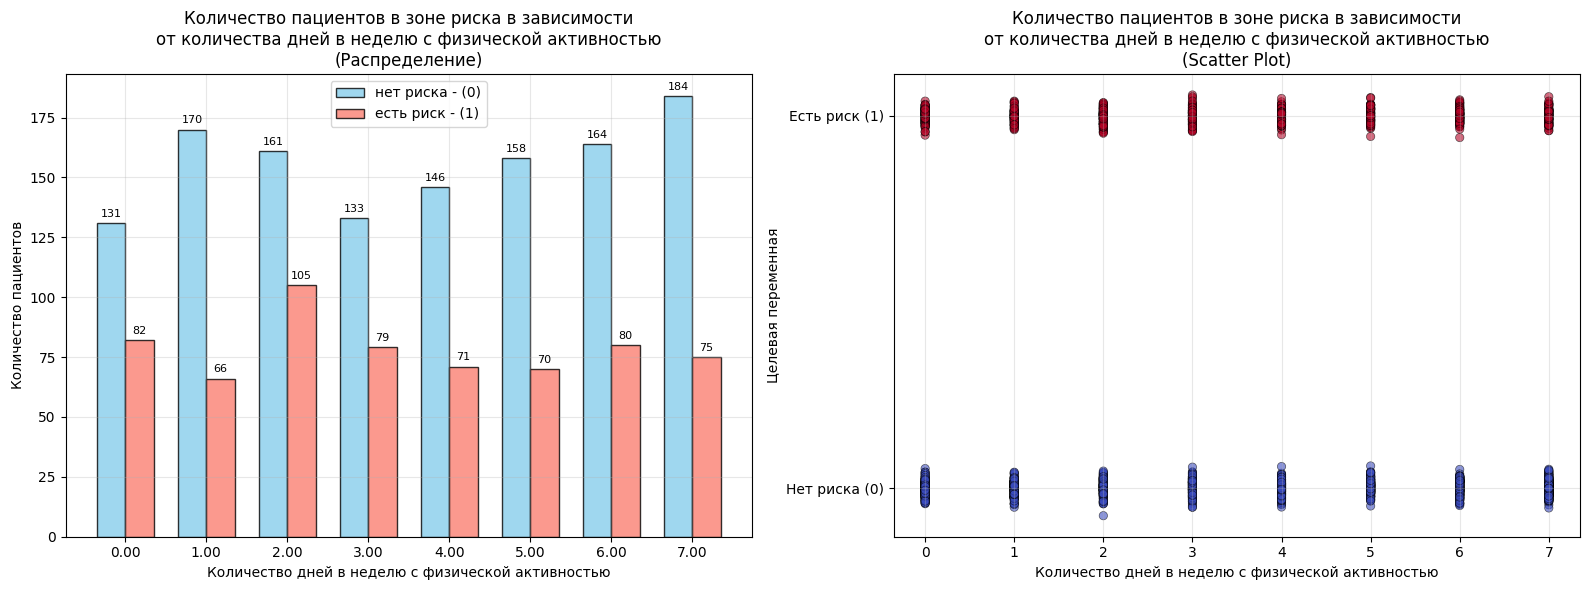

Статистика по physical_activity_days_per_week:
Уникальных значений: 8
Тип данных: int64

Средние значения:
Без риска: 3.638
С риском: 3.427
Корреляция с целевой: -0.043

Доли риска по категориям physical_activity_days_per_week:
  0: 38.5%
  1: 28.0%
  2: 39.5%
  3: 37.3%
  4: 32.7%
  5: 30.7%
  6: 32.8%
  7: 29.0%


In [60]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'physical_activity_days_per_week', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от количества дней в неделю с физической активностью',
                       x_label='Количество дней в неделю с физической активностью',
                       y_label='Количество пациентов',
                       bins=8
                       )

**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с уменьшением количества дней физической активности. В то же время, стоит отметить, что при количестве дней физической  активности $>2$ доля пациентов с риском незначительно падает.

#### Признак `sleep_hours_per_day`

**Комментарий**: исследуем признак `sleep_hours_per_day` -- количество часов сна в сутки.

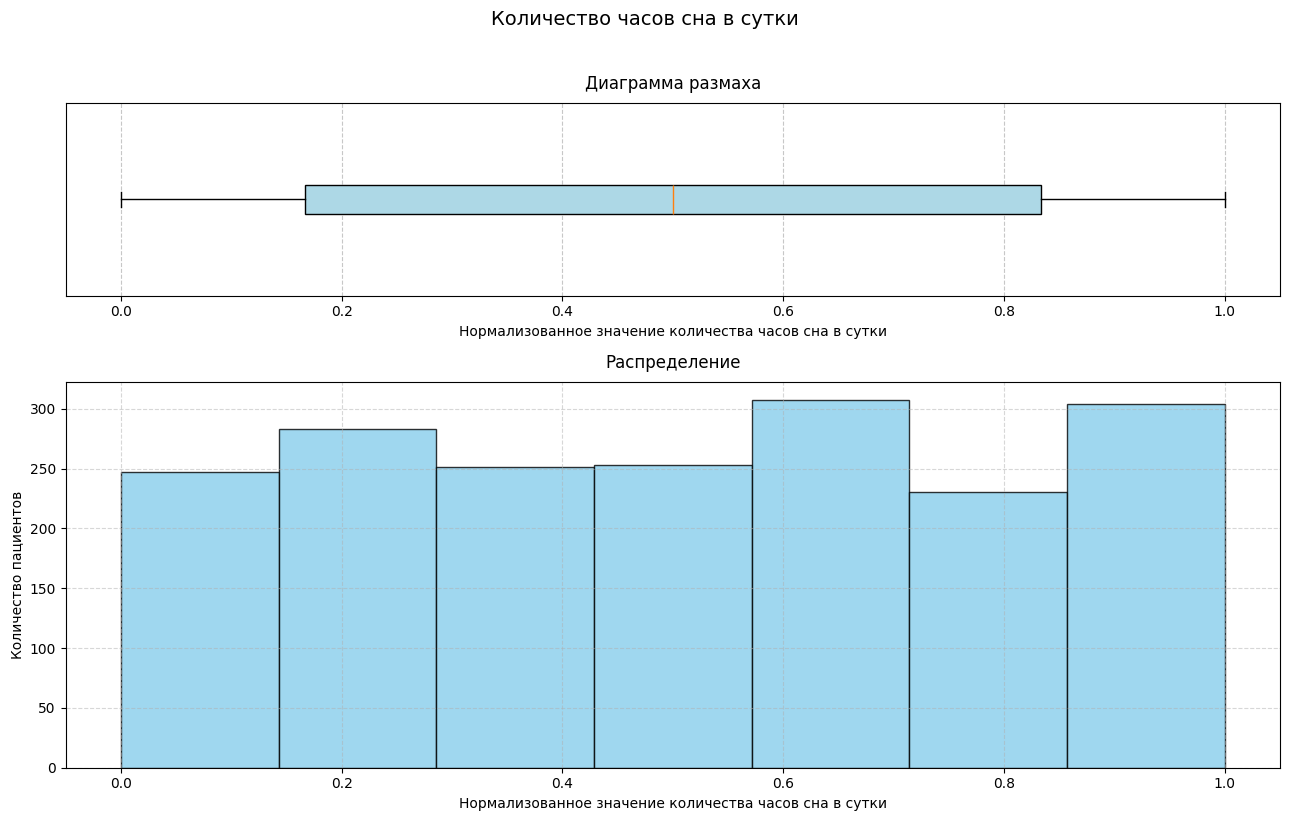

count    1875.000000
mean        0.510756
std         0.334780
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: sleep_hours_per_day, dtype: float64

In [61]:
# выведем график распределения
plot_data_analysis(heart['sleep_hours_per_day'],
                   title='Количество часов сна в сутки',
                   x_label='Нормализованное значение количества часов сна в сутки',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=7
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

In [62]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'sleep_hours_per_day', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от количества часов сна в сутки',
                       x_label='Нормализованное значение количества часов сна в сутки',
                       y_label='Количество пациентов',
                       bins=7
                       )

Статистика по sleep_hours_per_day:
Уникальных значений: 7
Тип данных: float64

Средние значения:
Без риска: 0.523
С риском: 0.486
Корреляция с целевой: -0.052

Доли риска по категориям sleep_hours_per_day:
  0.0: 37.2%
  0.1666666666666666: 40.6%
  0.3333333333333333: 30.7%
  0.4999999999999999: 31.2%
  0.6666666666666666: 30.9%
  0.8333333333333334: 31.7%
  1.0: 31.9%


**Промежуточный вывод**: Не наблюдается каких-либо существенных смещений в сторону повышения риска проблем с сердцем с уменьшением количества часов сна.  В то же время, стоит отметить, что при количестве часов сна в сутки $>0.17$ доля пациентов с риском незначительно падает.

#### Признак `systolic_blood_pressure`

**Комментарий**: исследуем признак `systolic_blood_pressure` -- cистолическое артериальное давление пациента.

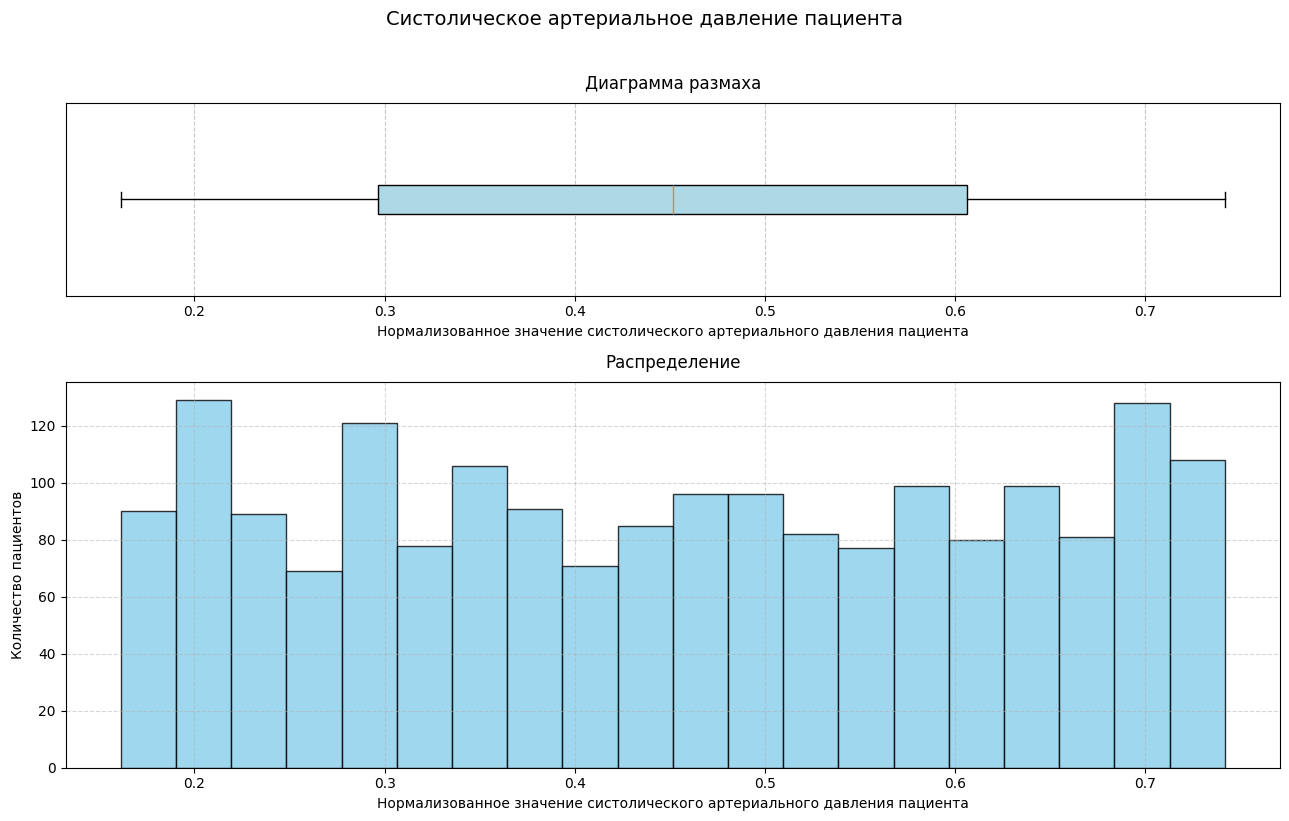

count    1875.000000
mean        0.452841
std         0.173138
min         0.161290
25%         0.296774
50%         0.451613
75%         0.606452
max         0.741935
Name: systolic_blood_pressure, dtype: float64

In [63]:
# выведем график распределения
plot_data_analysis(heart['systolic_blood_pressure'],
                   title='Систолическое артериальное давление пациента',
                   x_label='Нормализованное значение систолического артериального давления пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

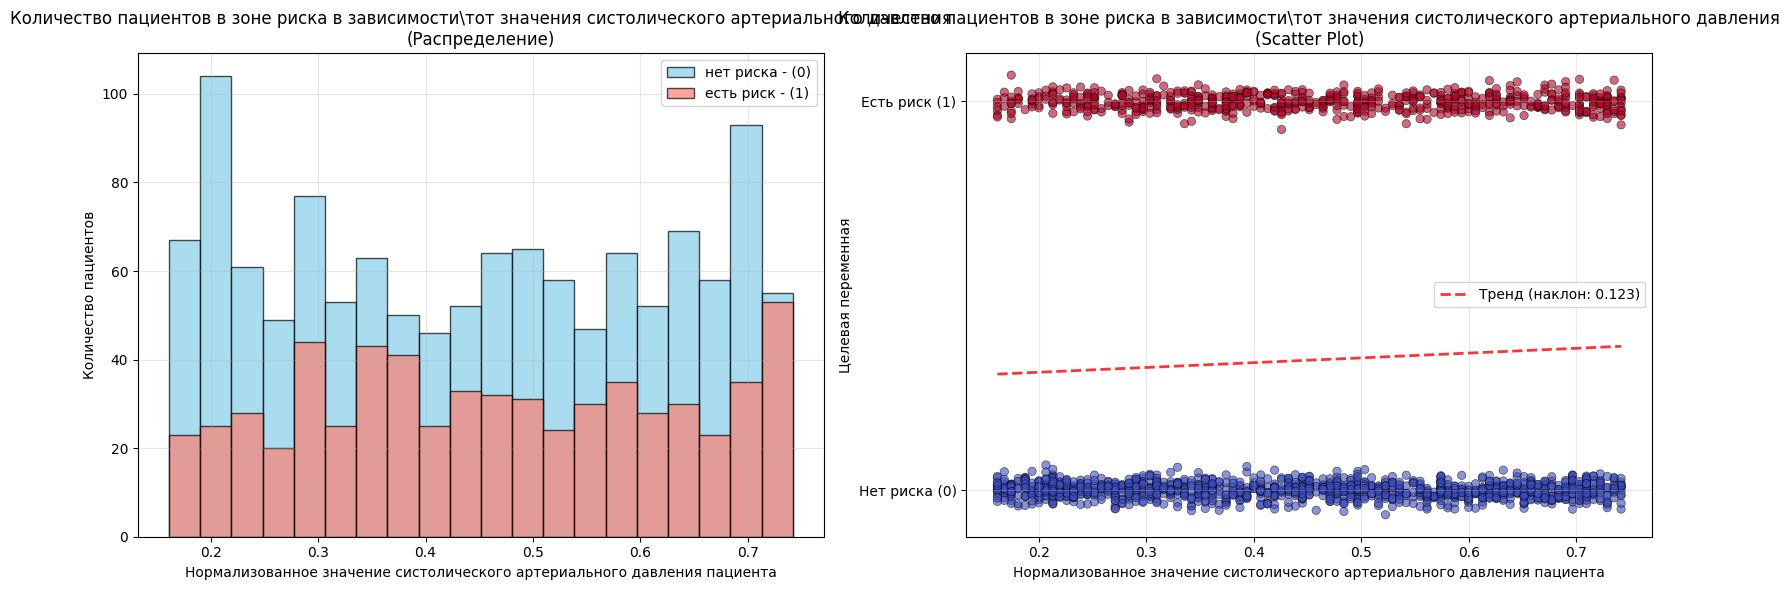

Статистика по systolic_blood_pressure:
Уникальных значений: 91
Тип данных: float64

Средние значения:
Без риска: 0.447
С риском: 0.464
Корреляция с целевой: 0.045
Разница средних (риск - нет риска): 0.017
Относительная разница: 3.70%


In [64]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'systolic_blood_pressure', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\т' \
                       'от значения систолического артериального давления',
                       x_label='Нормализованное значение систолического артериального давления пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Наблюдается слабый тренд повышения риска проблем с сердцем с увеличением показателя систолического давления пациента.

#### Признак `diastolic_blood_pressure`

**Комментарий**: исследуем признак `diastolic_blood_pressure` -- диастолическое артериальное давление пациента.

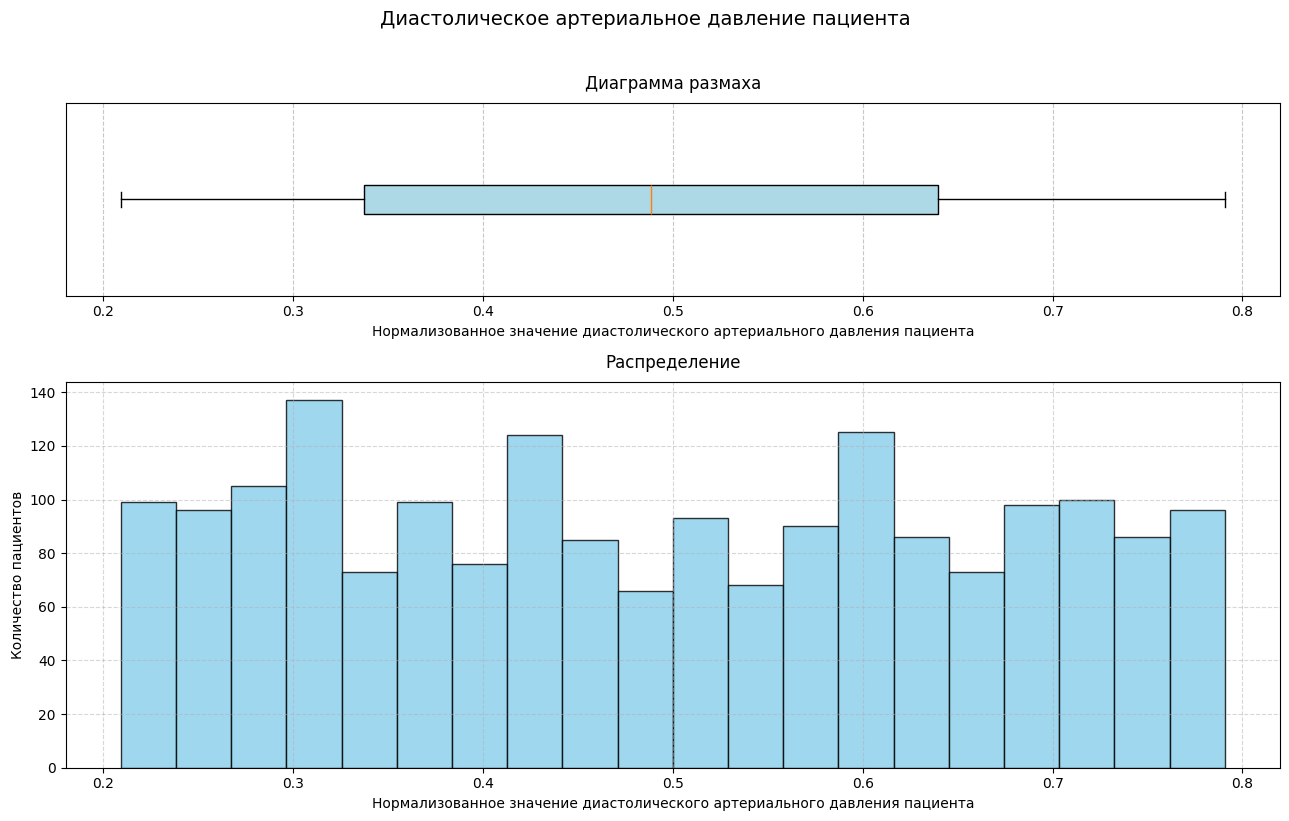

count    1875.000000
mean        0.494301
std         0.171115
min         0.209302
25%         0.337209
50%         0.488372
75%         0.639535
max         0.790698
Name: diastolic_blood_pressure, dtype: float64

In [65]:
# выведем график распределения
plot_data_analysis(heart['diastolic_blood_pressure'],
                   title='Диастолическое артериальное давление пациента',
                   x_label='Нормализованное значение диастолического артериального давления пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

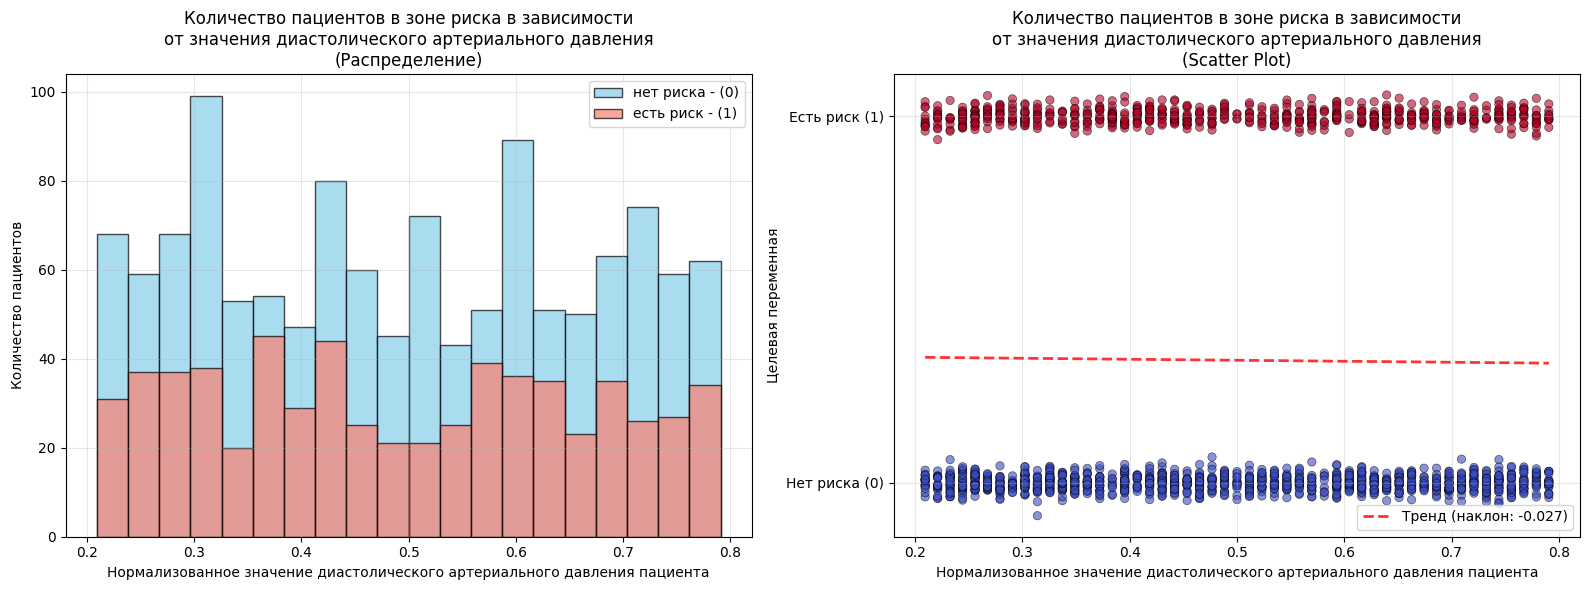

Статистика по diastolic_blood_pressure:
Уникальных значений: 51
Тип данных: float64

Средние значения:
Без риска: 0.495
С риском: 0.492
Корреляция с целевой: -0.010
Разница средних (риск - нет риска): -0.004
Относительная разница: -0.72%


In [66]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'diastolic_blood_pressure', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости\n' \
                       'от значения диастолического артериального давления',
                       x_label='Нормализованное значение диастолического артериального давления пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**: Не наблюдается ярковыраженного тренда повышения риска проблем с сердцем с увеличением показателя диастолического давления пациента.

### Категориальные признаки

**Комментарий**: теперь рассмотрим категориальные признаки:
- `diabetes` -- наличие у пациента диагностированного диабета
- `family_history` -- были ли проблемы с сердцем у родственников пациента
- `smoking` -- является ли пациент курильщиком
- `obesity` -- страдает ли пациент от ожирения
- `alcohol_consumption` -- употребление алкоголя пациентом
- `diet` -- какая у пациента диета/питание
- `previous_heart_problems` -- были ли ранее у пациента проблемы с сердцем
- `medication_use` -- принимает ли пациент лекарственные препараты
- `stress_level` -- уровень стресса пациента
- `gender` -- пол пациента

#### Признак `diabetes`

**Комментарий**: рассмотрим признак `diabetes` -- наличие у пациента диагностированного диабета.

In [67]:
# выведем уникальные значения
heart['diabetes'].unique()

array([1, 0])

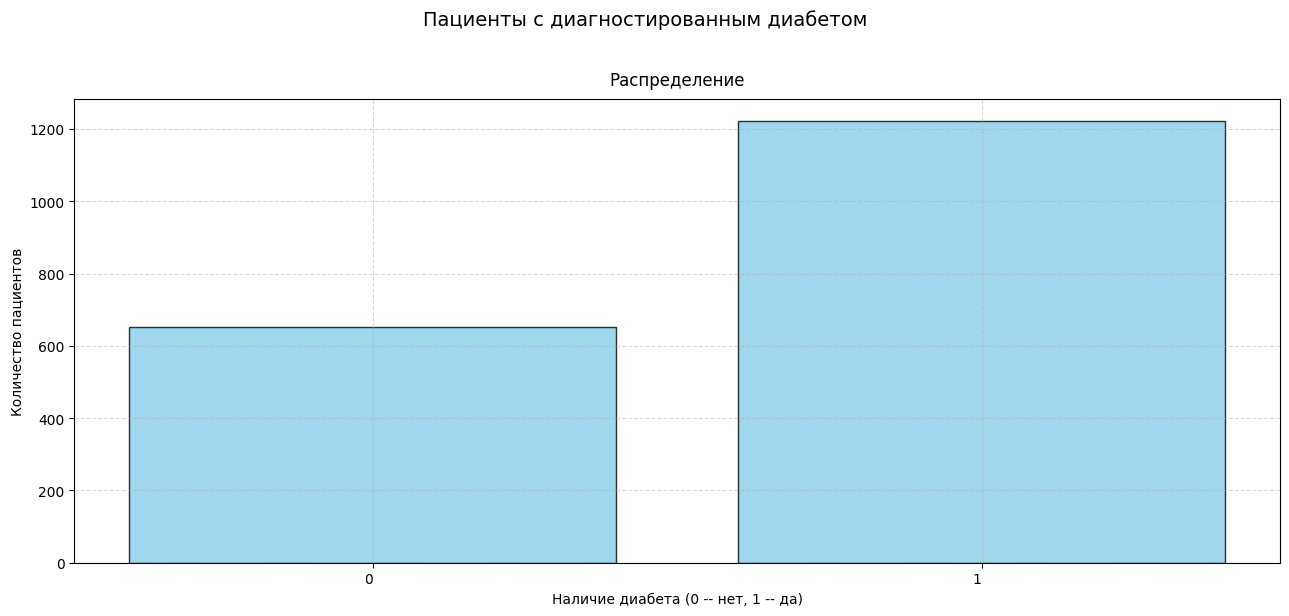

count    1875.000000
mean        0.652267
std         0.476378
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: diabetes, dtype: float64

In [68]:
# выведем график распределения
plot_data_analysis(heart['diabetes'],
                   title = 'Пациенты с диагностированным диабетом',
                   x_label = 'Наличие диабета (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов с диабетом в выборке примерно в два раза больше, чем без диабета.

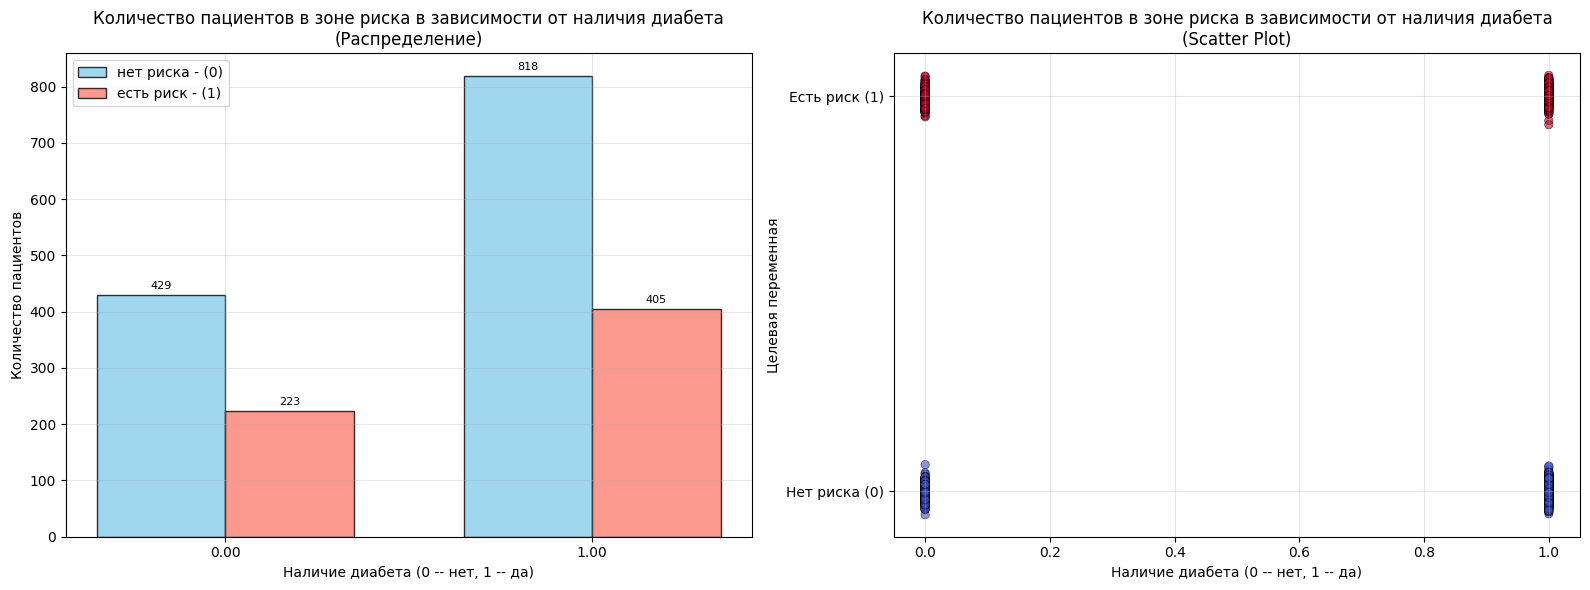

Статистика по diabetes:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.656
С риском: 0.645
Корреляция с целевой: -0.011

Доли риска по категориям diabetes:
  0: 34.2%
  1: 33.1%


In [69]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'diabetes', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от наличия диабета',
                       x_label='Наличие диабета (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [70]:
# выведем кол-во значений
print(heart['diabetes'].value_counts())

diabetes
1    1223
0     652
Name: count, dtype: int64


**Промежуточный вывод**: Количество пациентов с диабетом в выборке примерно в два раза больше, чем без диабета. При этом не наблюдается ярковыраженного влияния наличия/отсутствия диабета на рис сердечных заболеваний.

#### Признак `family_history`

**Комментарий**: рассмотрим признак `family_history` -- были ли проблемы с сердцем у родственников пациента.

In [71]:
# выведем уникальные значения
heart['family_history'].unique()

array([1, 0])

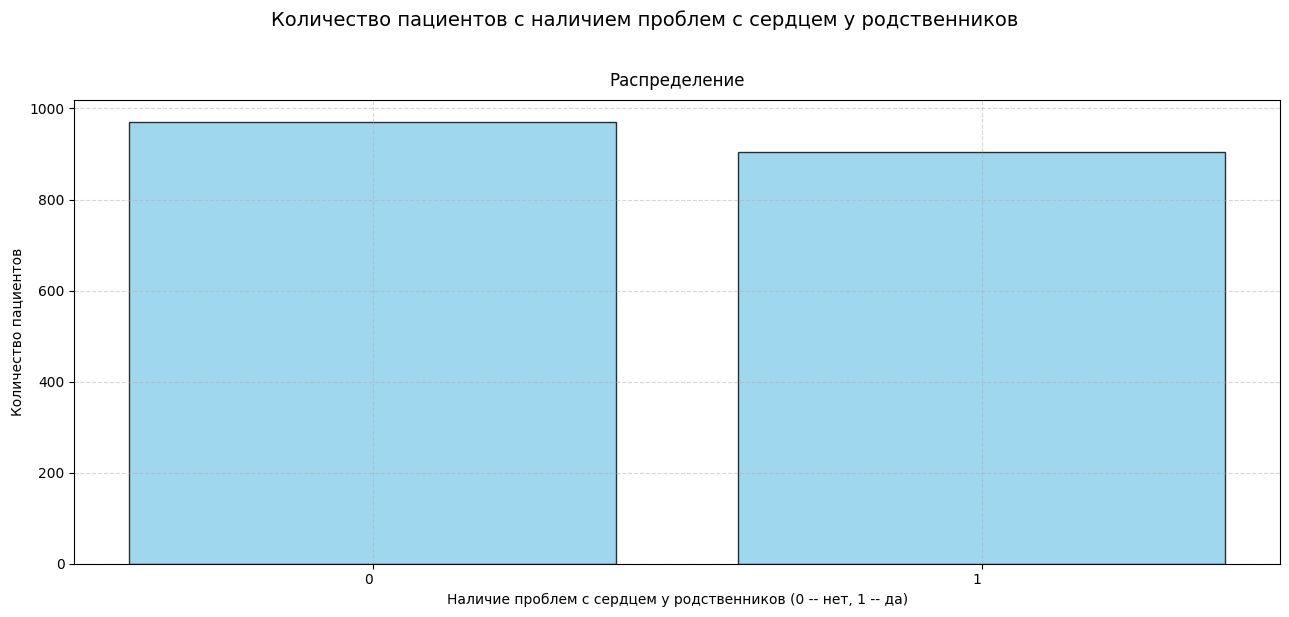

count    1875.000000
mean        0.482133
std         0.499814
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: family_history, dtype: float64

In [72]:
# выведем график распределения
plot_data_analysis(heart['family_history'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов в выборке, у которых имеется наследственность в проблемах с сердцем примерно одинаковая.

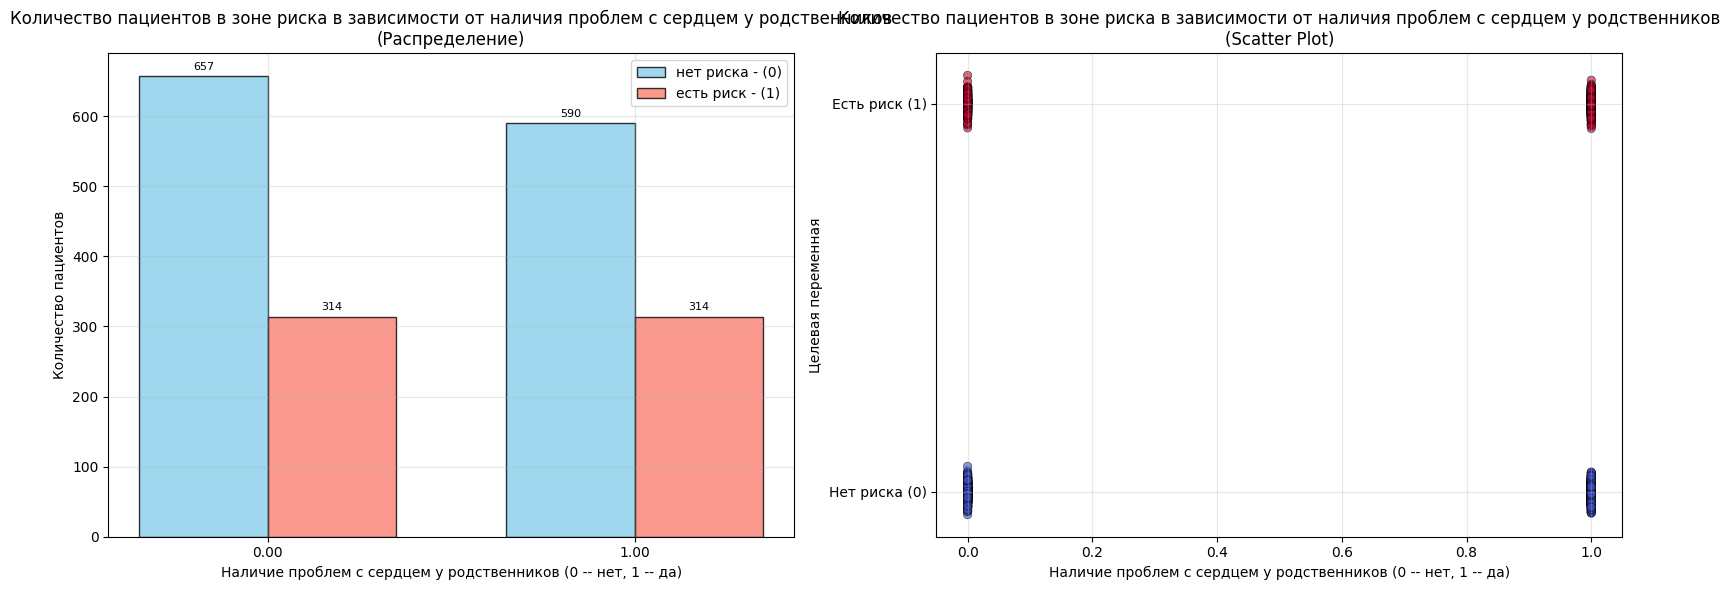

Статистика по family_history:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.473
С риском: 0.500
Корреляция с целевой: 0.025

Доли риска по категориям family_history:
  0: 32.3%
  1: 34.7%


In [73]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'family_history', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от наличия проблем с сердцем у родственников',
                       x_label='Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [74]:
# выведем кол-во значений
print(heart['family_history'].value_counts())

family_history
0    971
1    904
Name: count, dtype: int64


**Промежуточный вывод**: Количество пациентов в выборке, у которых имеется наследственность в проблемах с сердцем примерно одинаковая. При этом ярковыраженной зависимости с целевым показателем не наблюдается.

#### Признак `smoking`

**Комментарий**: рассмотрим признак `smoking` -- является ли пациент курильщиком.

In [75]:
# выведем уникальные значения
heart['smoking'].unique()

array([0, 1])

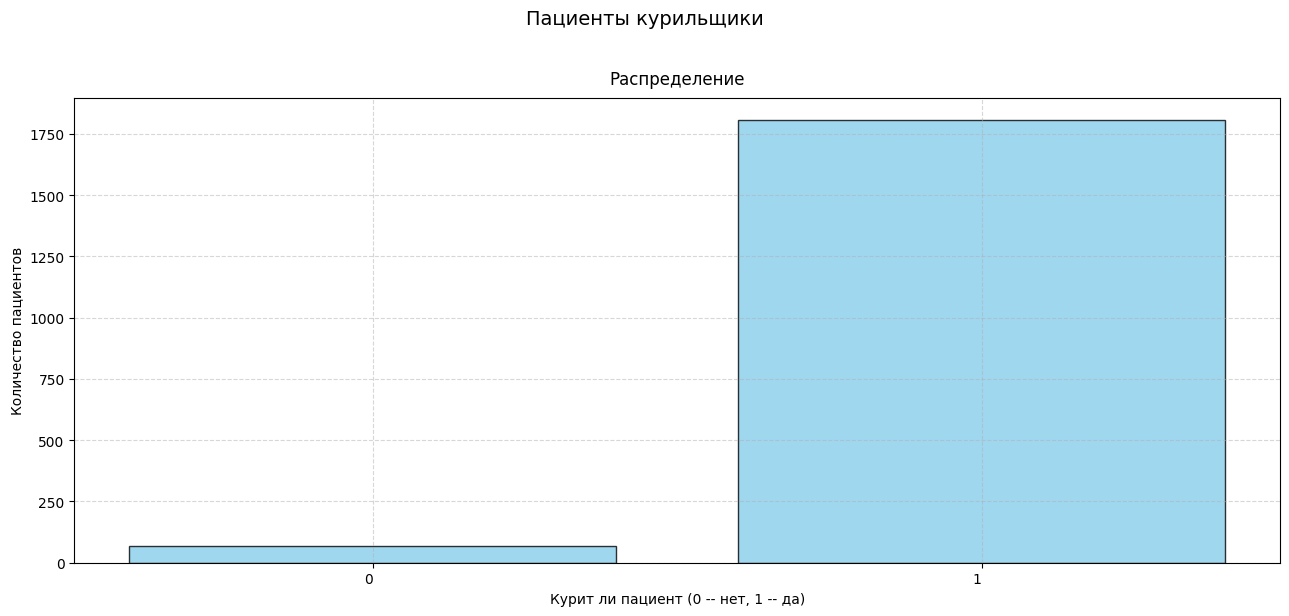

count    1875.000000
mean        0.963200
std         0.188321
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: smoking, dtype: float64

In [76]:
# выведем график распределения
plot_data_analysis(heart['smoking'],
                   title = 'Пациенты курильщики',
                   x_label = 'Курит ли пациент (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Наблюдается сильный дисбаланс в данных. Количество курящих пациентов более чем в $6$ раз больше, чем некурящих.

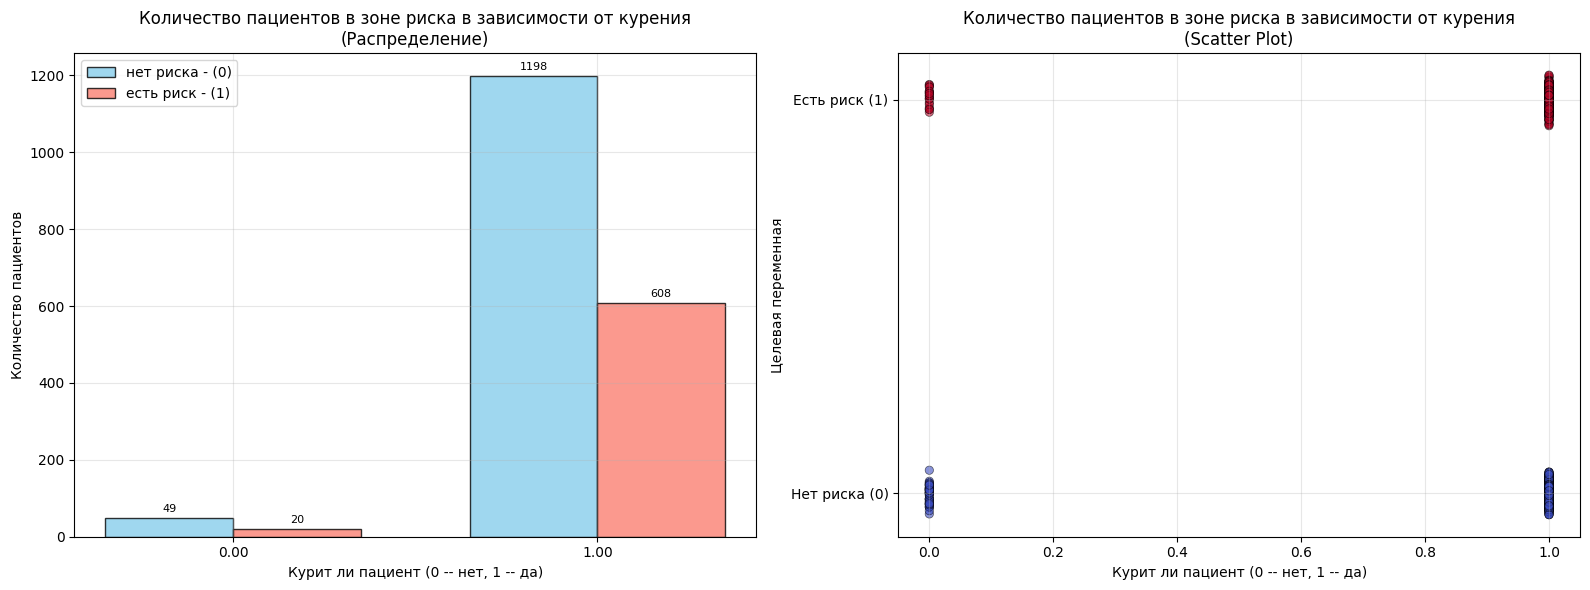

Статистика по smoking:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.961
С риском: 0.968
Корреляция с целевой: 0.019

Доли риска по категориям smoking:
  0: 29.0%
  1: 33.7%


In [77]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'smoking', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от курения',
                       x_label='Курит ли пациент (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [78]:
# выведем кол-во значений
print(heart['smoking'].value_counts())

smoking
1    1806
0      69
Name: count, dtype: int64


**Промежуточный вывод**: Наблюдается сильный дисбаланс в данных. Количество курящих пациентов более чем в $6$ раз больше, чем некурящих. При этом не наблюдается какой-либо зависимости влияния курения на увеличения риска заболеваний сердца. Это странно. Учитывая дисбаланс данных, можно предположить, что данный признак нерепрезентативный и может вносить искажения при обучении. Модель научится отлавливать курильщиков.

#### Признак `obesity`

**Комментарий**: рассмотрим признак `obesity` -- страдает ли пациент от ожирения.

In [79]:
# выведем уникальные значения
heart['obesity'].unique()

array([0, 1])

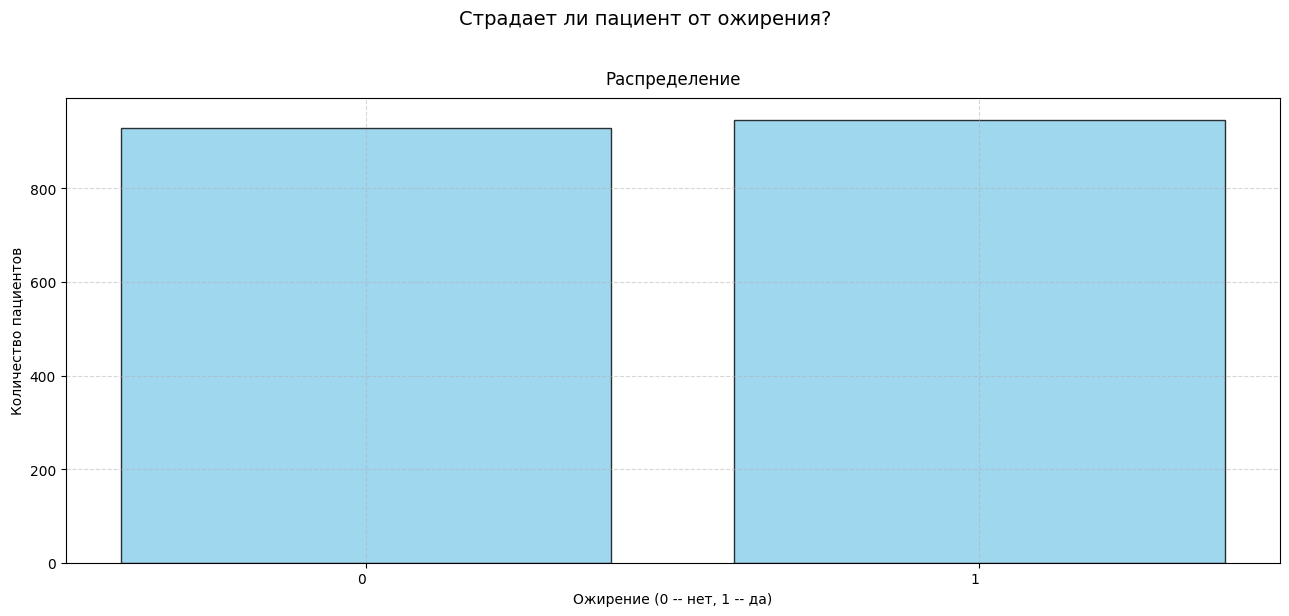

count    1875.000000
mean        0.504533
std         0.500113
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: obesity, dtype: float64

In [80]:
# выведем график распределения
plot_data_analysis(heart['obesity'],
                   title = 'Страдает ли пациент от ожирения?',
                   x_label = 'Ожирение (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Пациентов с ожирением и без примерно одинаковое количество.

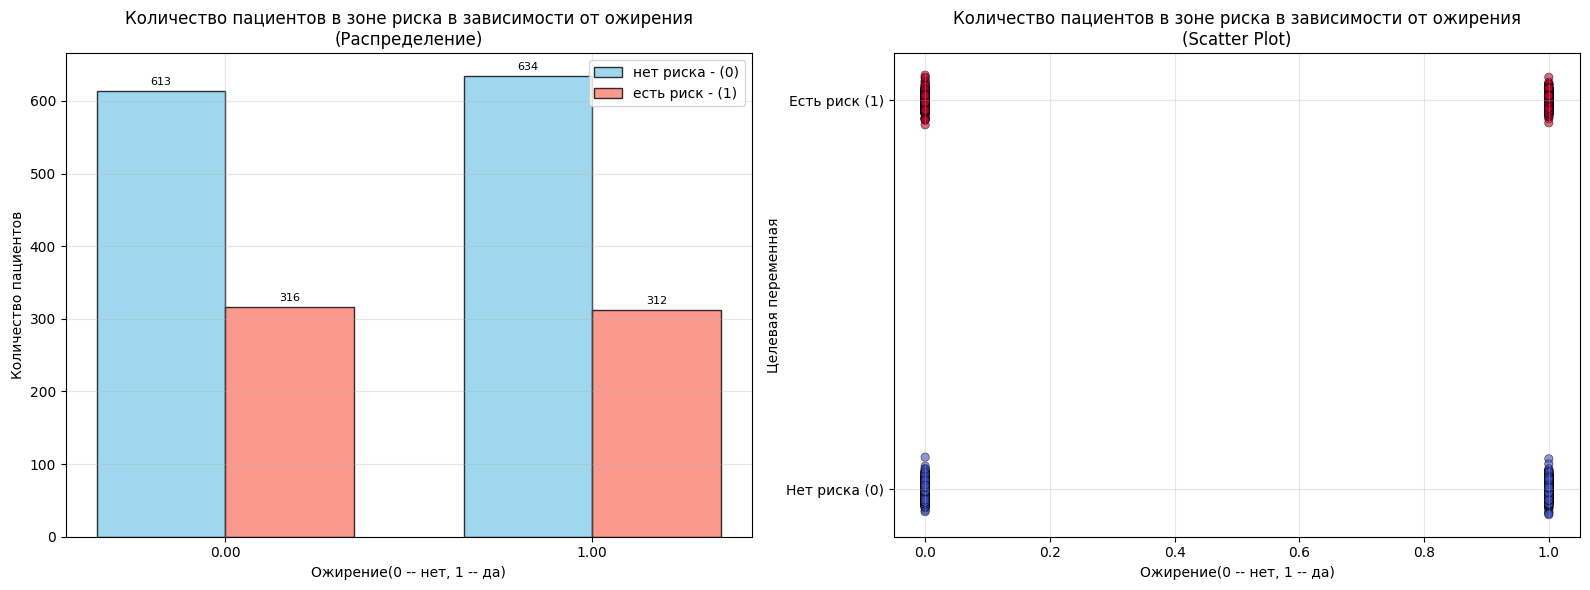

Статистика по obesity:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.508
С риском: 0.497
Корреляция с целевой: -0.011

Доли риска по категориям obesity:
  0: 34.0%
  1: 33.0%


In [81]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'obesity', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от ожирения',
                       x_label='Ожирение(0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [82]:
# выведем кол-во значений
print(heart['obesity'].value_counts())

obesity
1    946
0    929
Name: count, dtype: int64


**Промежуточный вывод**: Пациентов с ожирением и без примерно одинаковое количество. Не наблюдается ярковыраженного влияния на целевой признак.

#### Признак `alcohol_consumption`

**Комментарий**: рассмотрим признак `alcohol_consumption` -- употребление алкоголя пациентом.

In [83]:
# выведем уникальные значения
heart['alcohol_consumption'].unique()

array([1, 0])

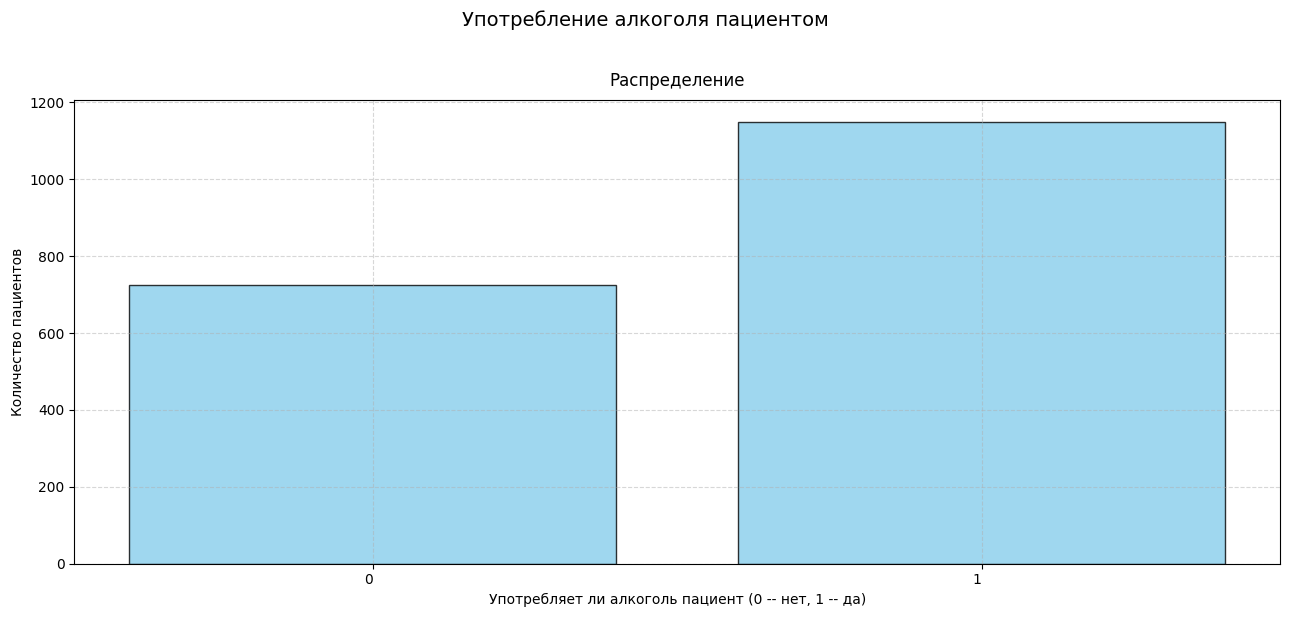

count    1875.000000
mean        0.613333
std         0.487116
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: alcohol_consumption, dtype: float64

In [84]:
# выведем график распределения
plot_data_analysis(heart['alcohol_consumption'],
                   title = 'Употребление алкоголя пациентом',
                   x_label = 'Употребляет ли алкоголь пациент (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов, употребляющих алкоголь больше, чем тех, кто его не употребляет.

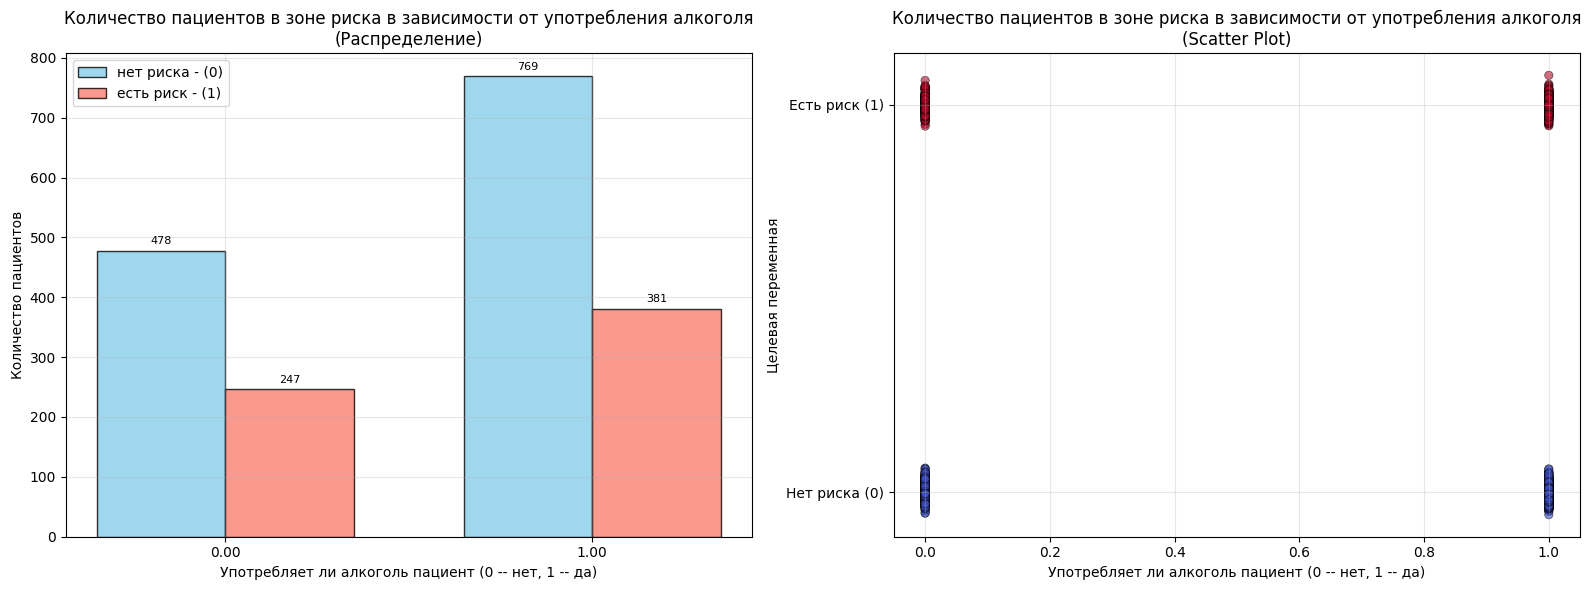

Статистика по alcohol_consumption:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.617
С риском: 0.607
Корреляция с целевой: -0.010

Доли риска по категориям alcohol_consumption:
  0: 34.1%
  1: 33.1%


In [85]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'alcohol_consumption', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от употребления алкоголя',
                       x_label='Употребляет ли алкоголь пациент (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [86]:
# выведем кол-во значений
print(heart['alcohol_consumption'].value_counts())

alcohol_consumption
1    1150
0     725
Name: count, dtype: int64


**Промежуточный вывод**: Количество пациентов, употребляющих алкоголь больше, чем тех, кто его не употребляет. При этом, опять же, не наблюдается ярковыраженного влияния на целевой признак.

#### Признак `diet`

**Комментарий**: рассмотрим признак `diet` -- какая у пациента диета/питание.

In [87]:
# выведем уникальные значения
heart['diet'].unique()

array([2, 0, 1])

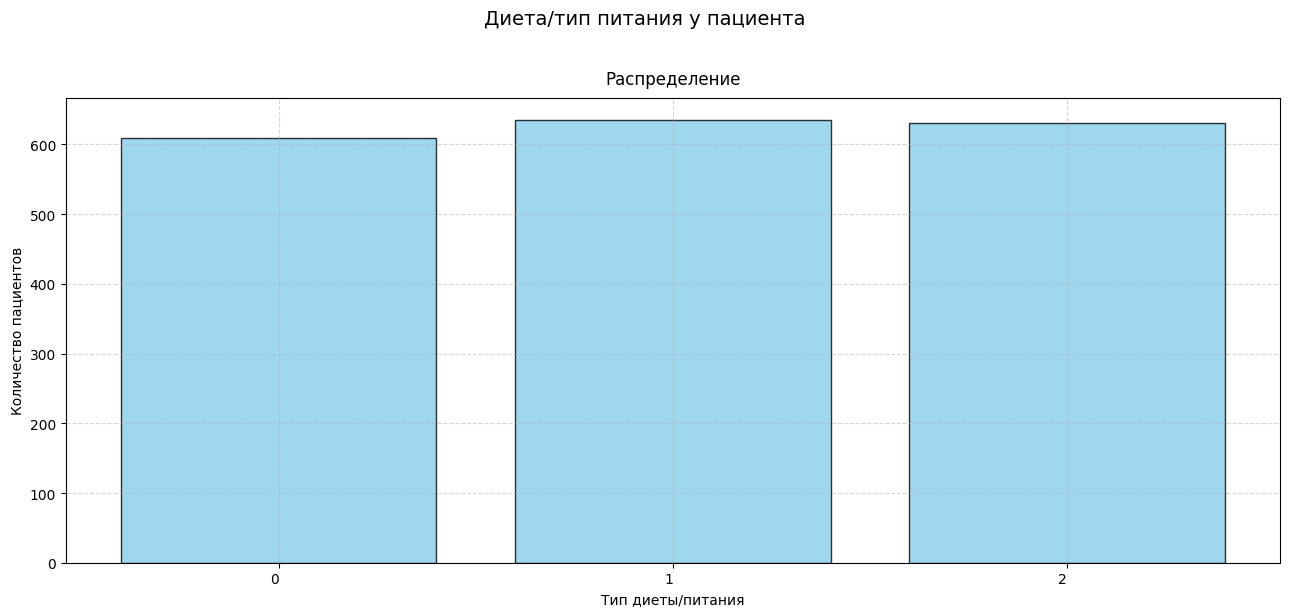

count    1875.000000
mean        1.011733
std         0.813356
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: diet, dtype: float64

In [88]:
# выведем график распределения
plot_data_analysis(heart['diet'],
                   title = 'Диета/тип питания у пациента',
                   x_label = 'Тип диеты/питания',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов с различными диетами/приемом пищи, примерно одинаковое.

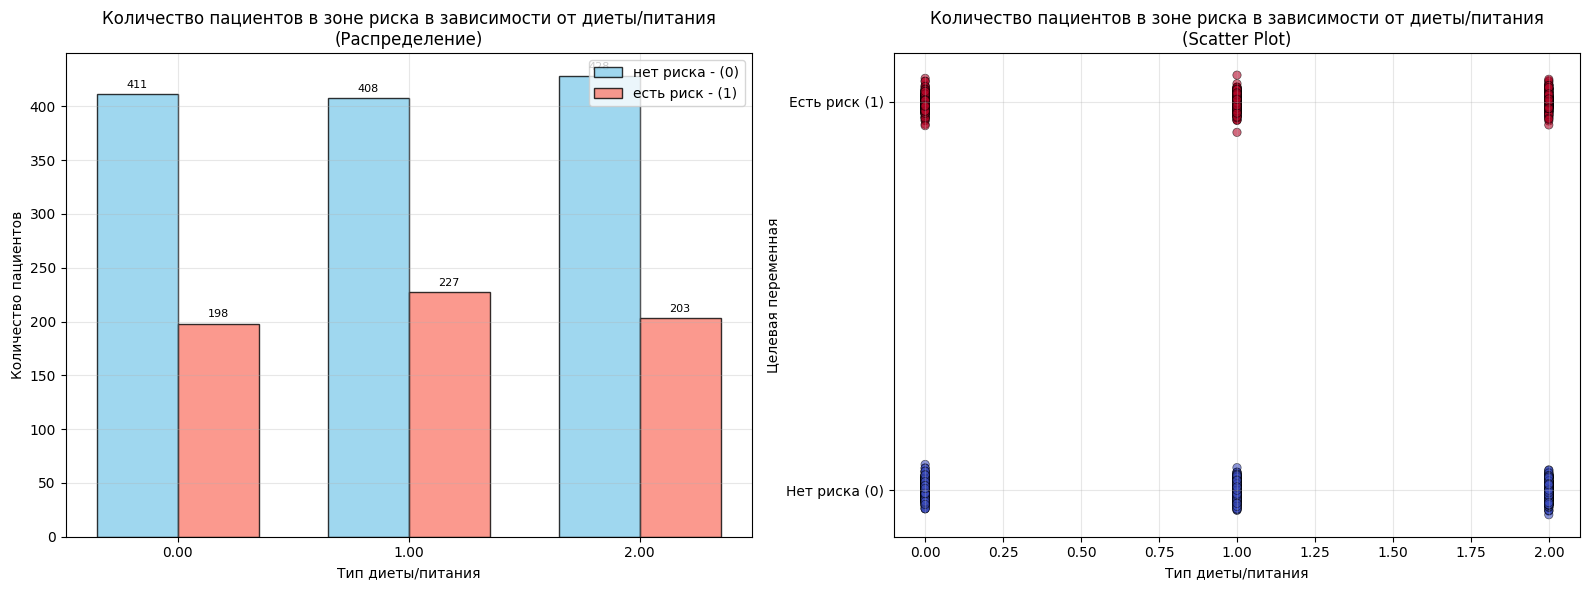

Статистика по diet:
Уникальных значений: 3
Тип данных: int64

Средние значения:
Без риска: 1.014
С риском: 1.008
Корреляция с целевой: -0.003

Доли риска по категориям diet:
  0: 32.5%
  1: 35.7%
  2: 32.2%


In [89]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'diet', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от диеты/питания',
                       x_label='Тип диеты/питания',
                       y_label='Количество пациентов'
                       )

In [90]:
# выведем кол-во значений
print(heart['diet'].value_counts())

diet
1    635
2    631
0    609
Name: count, dtype: int64


**Промежуточный вывод**: Количество пациентов с различными диетами/приемом пищи, примерно одинаковое. При этом не наблюдается ярковыраженной зависимости с целевым признаком.

#### Признак `medication_use`

**Комментарий**: рассмотрим признак `medication_use` -- принимает ли пациент лекарственные препараты.

In [91]:
# выведем уникальные значения
heart['medication_use'].unique()

array([0, 1])

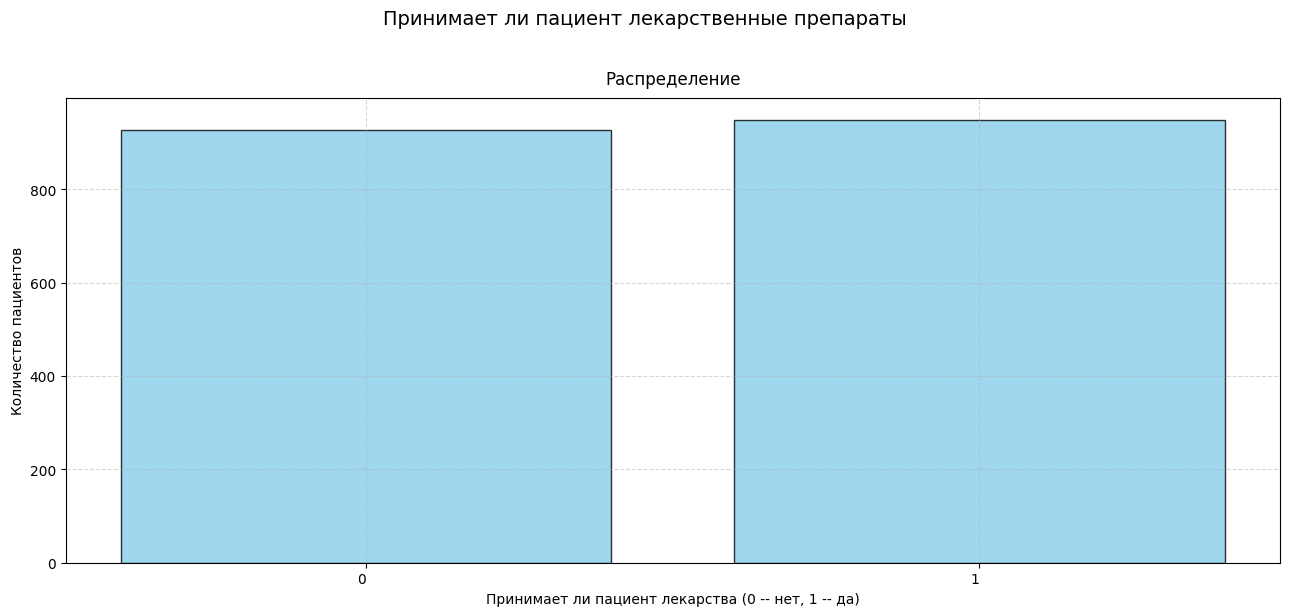

count    1875.000000
mean        0.505600
std         0.500102
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: medication_use, dtype: float64

In [92]:
# выведем график распределения
plot_data_analysis(heart['medication_use'],
                   title = 'Принимает ли пациент лекарственные препараты',
                   x_label = 'Принимает ли пациент лекарства (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов, принимающих и не принимающих лекарственные препараты примерно одинаково.

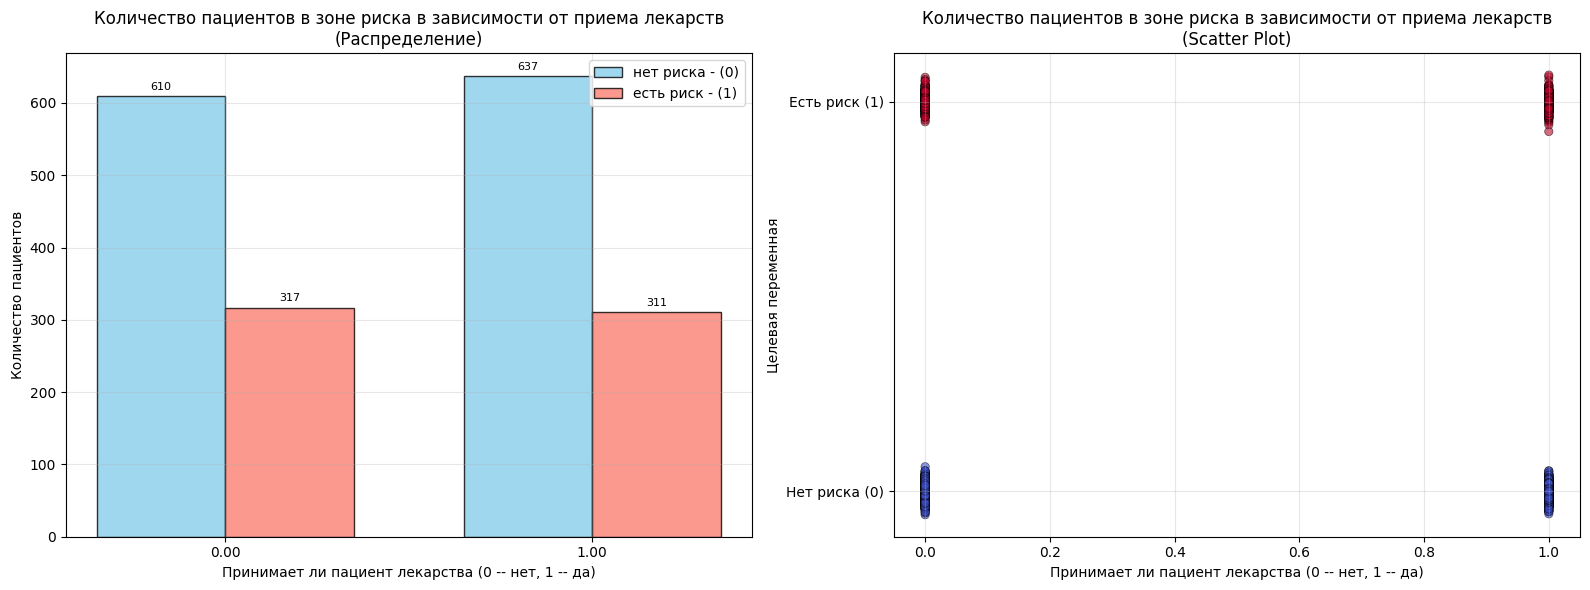

Статистика по medication_use:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.511
С риском: 0.495
Корреляция с целевой: -0.015

Доли риска по категориям medication_use:
  0: 34.2%
  1: 32.8%


In [93]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'medication_use', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от приема лекарств',
                       x_label='Принимает ли пациент лекарства (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

In [94]:
# выведем кол-во значений
print(heart['medication_use'].value_counts())

medication_use
1    948
0    927
Name: count, dtype: int64


**Промежуточный вывод**: Количество пациентов, принимающих и не принимающих лекарственные препараты примерно одинаково. И снова не наблюдается какой-либо связи с целевым показателем.

#### Признак `stress_level`

**Комментарий**: рассмотрим признак `stress_level` -- уровень стресса пациента.

In [95]:
# выведем уникальные значения
heart['stress_level'].unique()

array([ 9,  3, 10,  2,  7,  5,  4,  8,  6,  1])

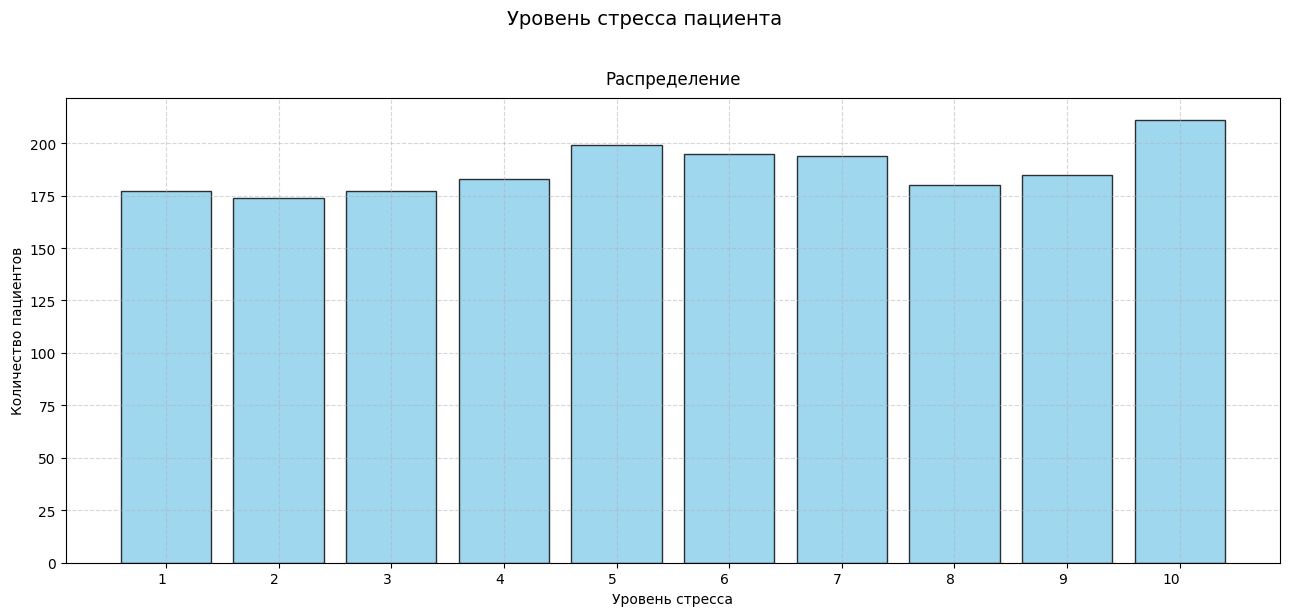

count    1875.000000
mean        5.613867
std         2.867441
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64

In [96]:
# выведем график распределения
plot_data_analysis(heart['stress_level'],
                   title = 'Уровень стресса пациента',
                   x_label = 'Уровень стресса',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: В среднем количество пациентов по уровню стресса распределено более-менее равномерно.

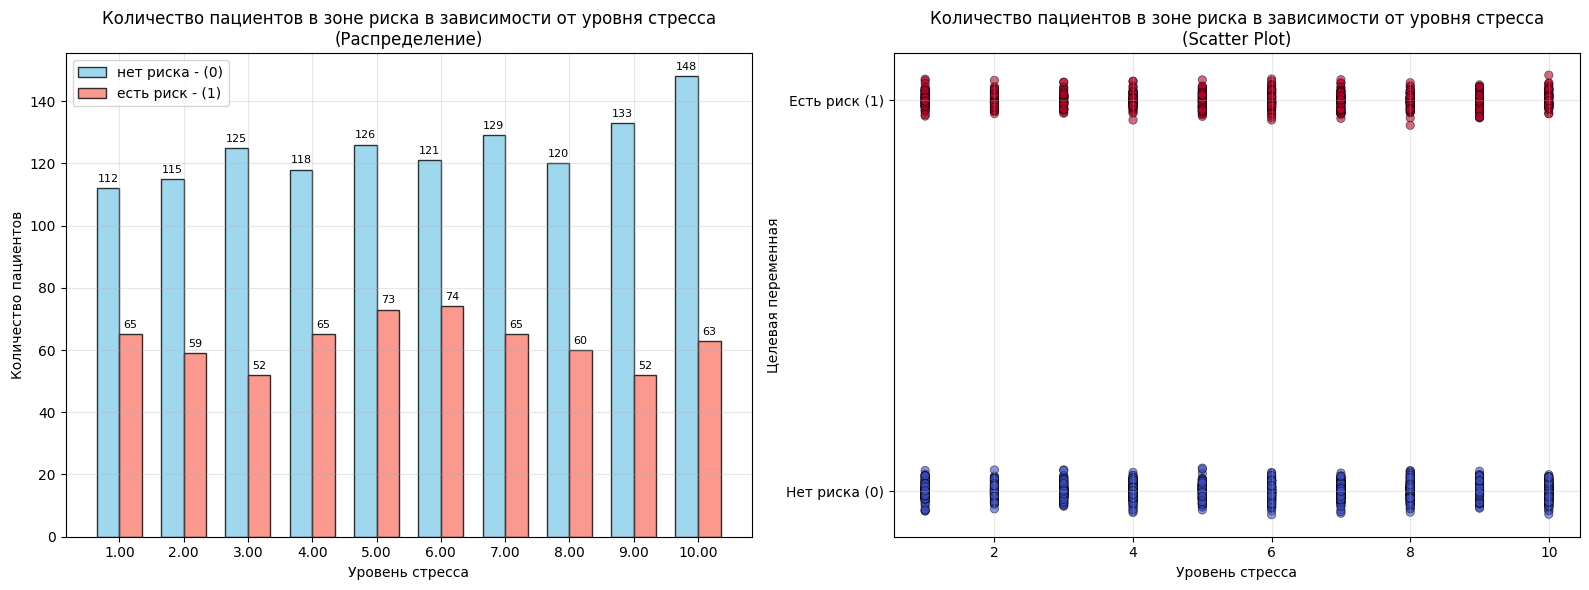

Статистика по stress_level:
Уникальных значений: 10
Тип данных: int64

Средние значения:
Без риска: 5.682
С риском: 5.479
Корреляция с целевой: -0.033

Доли риска по категориям stress_level:
  1: 36.7%
  2: 33.9%
  3: 29.4%
  4: 35.5%
  5: 36.7%
  6: 37.9%
  7: 33.5%
  8: 33.3%
  9: 28.1%
  10: 29.9%


In [97]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'stress_level', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня стресса',
                       x_label='Уровень стресса',
                       y_label='Количество пациентов'
                       )

In [98]:
# выведем кол-во значений
print(heart['stress_level'].value_counts())

stress_level
10    211
5     199
6     195
7     194
9     185
4     183
8     180
3     177
1     177
2     174
Name: count, dtype: int64


**Промежуточный вывод**: В среднем количество пациентов по уровню стресса распределено более-менее равномерно. Наблюдается некоторый прирост относительной доли рискующих пациентов для диапазона уровня стресса $[4;7]$.

#### Признак `gender`

**Комментарий**: рассмотрим признак `gender` -- пол пациента.

In [99]:
# выведем уникальные значения
heart['gender'].unique()

array(['Female', 'Male'], dtype=object)

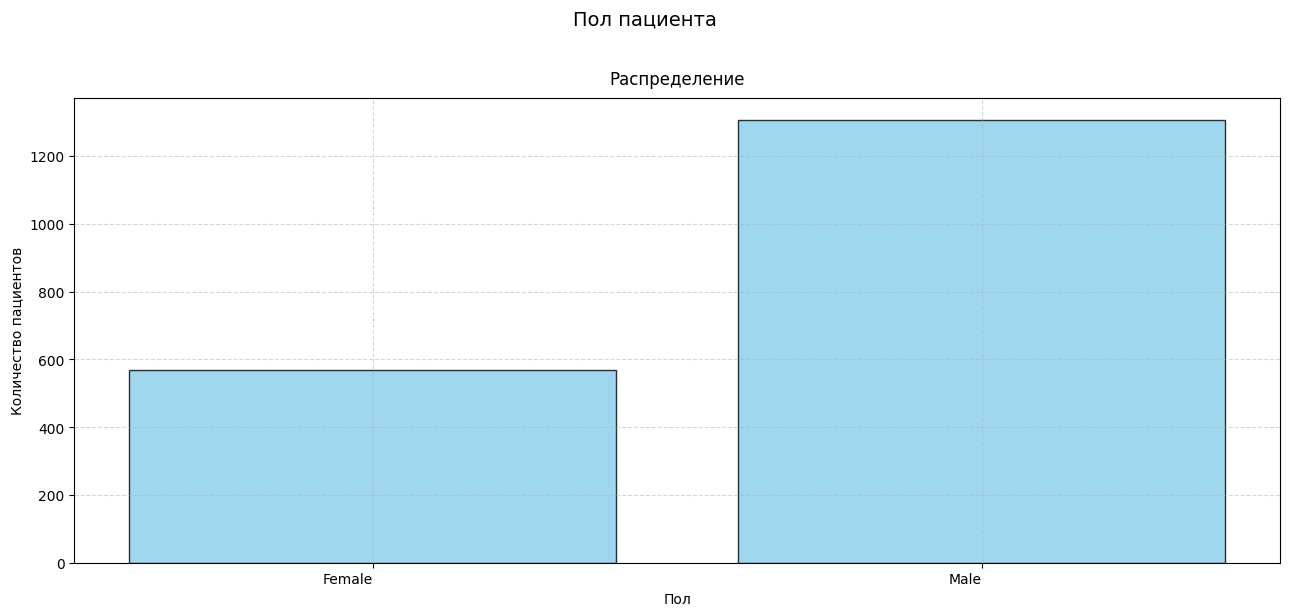

count     1875
unique       2
top       Male
freq      1306
Name: gender, dtype: object

In [100]:
# выведем график распределения
plot_data_analysis(heart['gender'],
                   title = 'Пол пациента',
                   x_label = 'Пол',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Наблюдается дисбаланс в количестве пациентов-женщин и пациентов мужчин, в $>2$ раза мужчин больше.

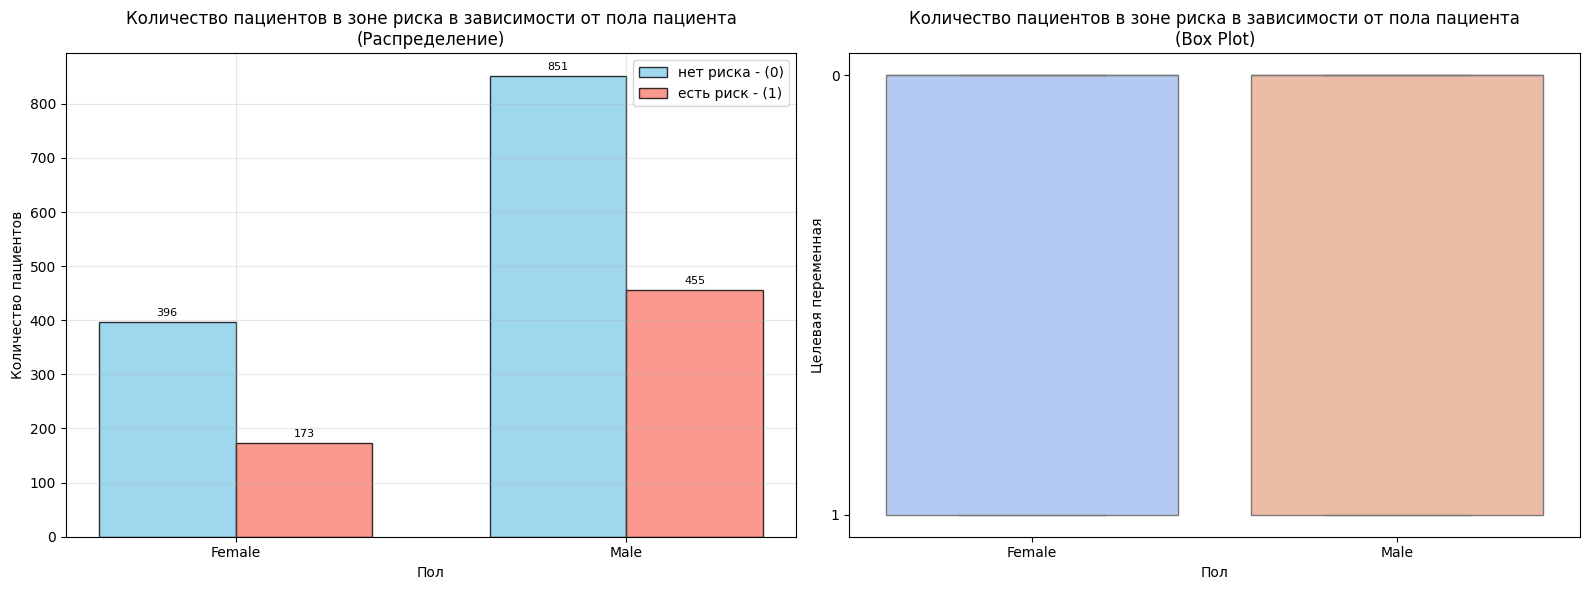

Статистика по gender:
Уникальных значений: 2
Тип данных: object

Доли риска по категориям gender:
  Female: 30.4%
  Male: 34.8%


In [101]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart,
                       'gender', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от пола пациента',
                       x_label='Пол',
                       y_label='Количество пациентов'
                       )

In [102]:
# выведем кол-во значений
print(heart['gender'].value_counts())

gender
Male      1306
Female     569
Name: count, dtype: int64


**Промежуточный вывод**: Наблюдается дисбаланс в количестве пациентов-женщин и пациентов мужчин, в $>2$ раза мужчин больше. Доля риска для мужчин чуть выше, чем для женщин. Однако, возможно, что такая выборка также не является репрезентативной из-за перекоса в сторону пациентов-мужчин.

#### Признак `previous_heart_problems`

**Комментарий**: рассмотрим признак - `previous_heart_problems` -- были ли проблемы с сердцем ранее.

In [103]:
# выведем уникальные значения
heart['previous_heart_problems'].unique()

array([1, 0])

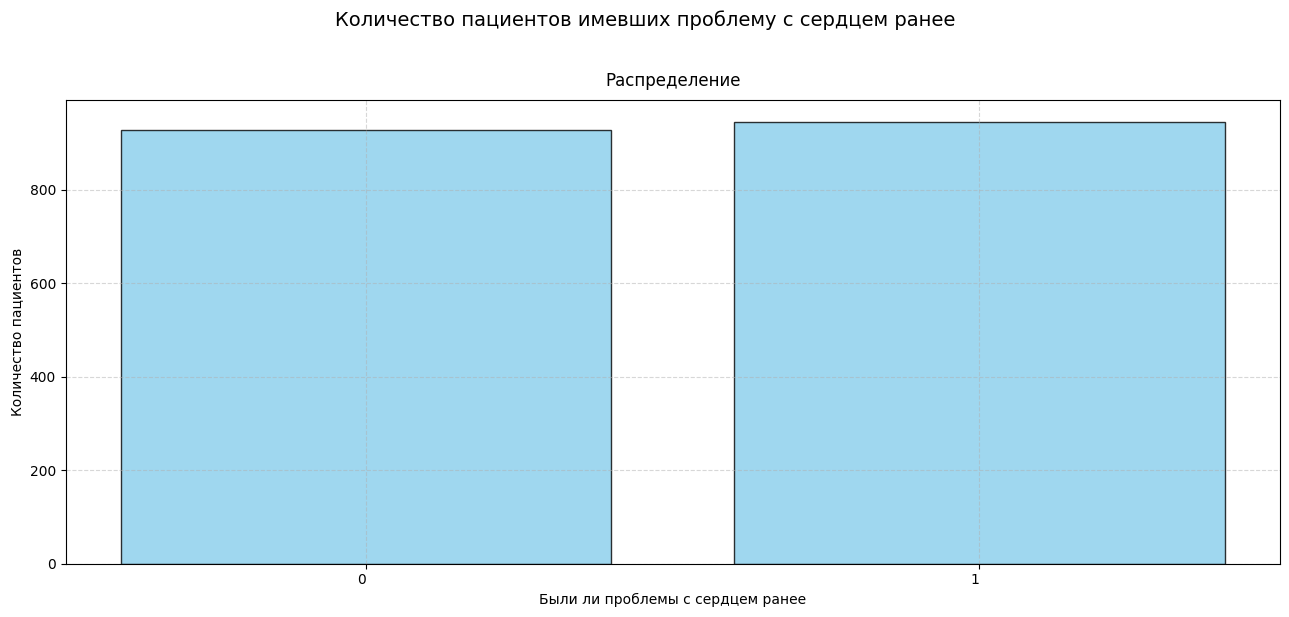

count    1875.000000
mean        0.504533
std         0.500113
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: previous_heart_problems, dtype: float64

In [104]:
# выведем график распределения
plot_data_analysis(heart['previous_heart_problems'],
                   title = 'Количество пациентов имевших проблему с сердцем ранее',
                   x_label = 'Были ли проблемы с сердцем ранее',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: Количество пациентов, имевших ранее проблемы с сердце примерно поровну.

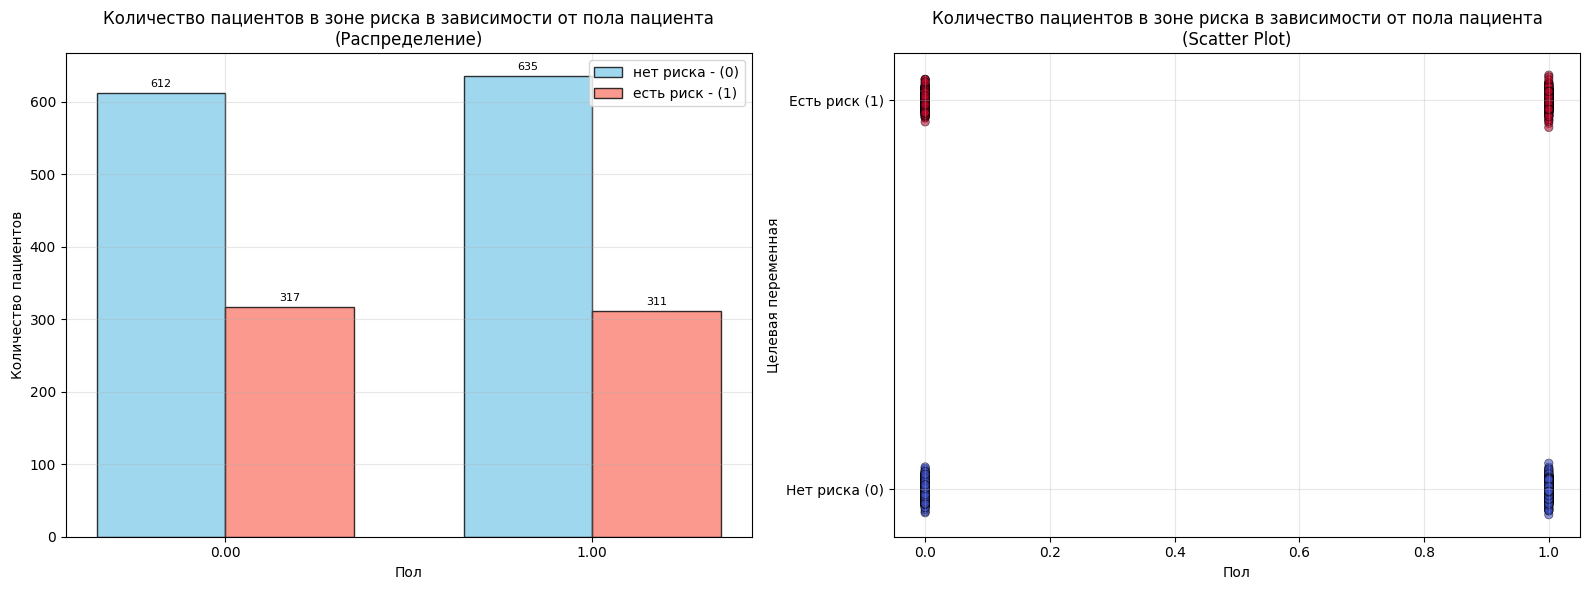

Статистика по previous_heart_problems:
Уникальных значений: 2
Тип данных: int64

Средние значения:
Без риска: 0.509
С риском: 0.495
Корреляция с целевой: -0.013

Доли риска по категориям previous_heart_problems:
  0: 34.1%
  1: 32.9%


In [105]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart,
                       'previous_heart_problems', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от пола пациента',
                       x_label='Пол',
                       y_label='Количество пациентов'
                       )

In [106]:
# выведем количество
heart['previous_heart_problems'].value_counts()

previous_heart_problems
1    946
0    929
Name: count, dtype: int64

**Промежуточный вывод**: Количество пациентов, имевших ранее проблемы с сердце примерно поровну. И снова не наблюдается какой-либо связи с целевым показателем.

#### Целевой признак `heart_attack_risk_binary`

**Комментарий**: рассмотрим **целевой признак** `heart_attack_risk_binary` -- риск сердечного приступа.

In [107]:
# выведем уникальные значения
heart['heart_attack_risk_binary'].unique()

array([0, 1])

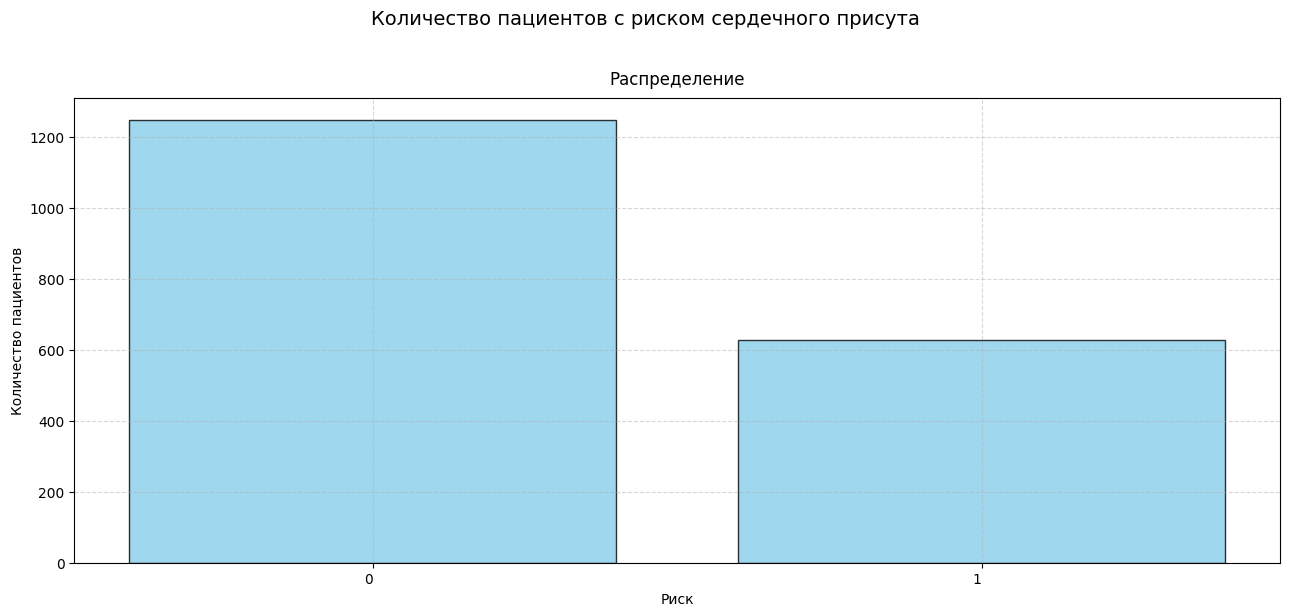

count    1875.000000
mean        0.334933
std         0.472093
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: heart_attack_risk_binary, dtype: float64

In [108]:
# выведем график распределения
plot_data_analysis(heart['heart_attack_risk_binary'],
                   title = 'Количество пациентов с риском сердечного присута',
                   x_label = 'Риск',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [109]:
# выведем количество
heart['heart_attack_risk_binary'].value_counts()

heart_attack_risk_binary
0    1247
1     628
Name: count, dtype: int64

**Промежуточный вывод**: Наблюдается дисбаланс в целевом признаке (1 к 2). Важно это учитывать при формировании выборки (стратификация), и при настройке и обучении моделей (например, балансировочные веса для бустинга и деревьев).

### Промежуточный вывод

Был выполнен исследовательский анализ данных:

0. **Нет информации о нормализации данных, а также о том, как закодированы категориальные признаки!**

1. В целом в данных не наблюдается какого-то ярковыраженного смещения и зависимости риска проблем с множеством показателей из набора данных (`cholesterol`, `exercies_hours_per_week`, `income`, `triglycerides`, `diastolic_blood_pressure`, `diabetes`, `family_history`, `obesity`, `alcohol_consumption`, `diet`, `medication_use`, `previous_heart_problems`). Хотя по логике и исходя из исследований, многие из этих признаков должны оказывать влияние. Такая ситуация может говорить о том, что ***обучающая выборка малорепрезентативна, обладает низким качеством данных***;

2. На основе анализа показателя сахара в крови, было отброшено $\sim70\%$ данных, которые зашумляли выборку. Основное количество оставшихся в выборке пациентов сосредоточено в области $(0.1; 0.2]$ нормализованного показателя сахара в крови ($\sim1000$ пацентов). 
3. Есть очень слабый тренд в сторону повышения риска проблем с сердцем с увеличением возраста. Большая часть пациентов по возрасту сконцетрирована в области $[0.4;0.55]$;
4. Есть слабый тренд смещения в сторону повышения риска проблем с сердцем с увеличением пульса пациентов;
5. Присутствует слабый тренд в сторону повышения риска проблем с сердцем с увеличением количества сидячих часов в сутки;
6. При количестве дней физической  активности $>2$ доля пациентов с риском незначительно падает;
7. При количестве часов сна в сутки $>0.17$ доля пациентов с риском незначительно падает;
8. Наблюдается слабый тренд повышения риска проблем с сердцем с увеличением показателя систолического давления пациента;
9. Не наблюдается ярковыраженного тренда повышения риска проблем с сердцем с увеличением показателя диастолического давления пациента;
10. Наблюдается сильный дисбаланс в данных по признаку `smoking` -- количество курящих пациентов более чем в $6$ раз больше, чем некурящих. При этом не наблюдается какой-либо зависимости влияния курения на увеличения риска заболеваний сердца. Это странно. Учитывая дисбаланс данных, можно предположить, что данный признак нерепрезентативный и может вносить искажения при обучении. Модель научится отлавливать курильщиков;
11. Пациентов с ожирением и без примерно одинаковое количество. Не наблюдается ярковыраженного влияния на целевой признак.
12. Количество пациентов, употребляющих алкоголь больше, чем тех, кто его не употребляет. При этом, опять же, не наблюдается ярковыраженного влияния на целевой признак;
13. В среднем количество пациентов по уровню стресса распределено более-менее равномерно. Наблюдается некоторый прирост относительной доли рискующих пациентов для диапазона уровня стресса $[4;7]$.
14. Наблюдается дисбаланс в количестве пациентов-женщин и пациентов мужчин, в $>2$ раза мужчин больше. Доля риска для мужчин чуть выше, чем для женщин. Однако, возможно, что такая выборка также не является репрезентативной из-за перекоса в сторону пациентов-мужчин.
15. Наблюдается дисбаланс в целевом признаке (1 к 2). Важно это учитывать при формировании выборки (стратификация), и при настройке и обучении моделей (например, балансировочные веса для бустинга и деревьев).

Некоторые идеи и предположения:
1. Можно попробовать выполнить бинаризацию признаков `age`, `physical_activity_days_per_week`, `sleep_hours_per_day`;
2. Можно попробовать перевести признак `stress_level` в разряд категориальных с тремя уровнями стресса -- низкий, средний, высокий;
3. Убрать признаки `smoking`, `gender`. По `gender` и/или по целевому можно попробовать сделать undersampling, но данных и так уже немного;
4. Пробовать группировать признаки.

## <u>Корреляционный анализ</u>

**Комментарий**: выполним корреляционный анализ признаков.

In [110]:
# сформируем список столбцов с непрерывными признаками
interval_columns = ['age', 
                    'cholesterol', 
                    'heart_rate', 
                    'exercise_hours_per_week',
                    'sedentary_hours_per_day',
                    'income',
                    'bmi',
                    'triglycerides',
                    'blood_sugar',
                    'systolic_blood_pressure',
                    'diastolic_blood_pressure'
                    ]

🤖 -- это МЕГАТРОН, он тут приглядывает за всем.

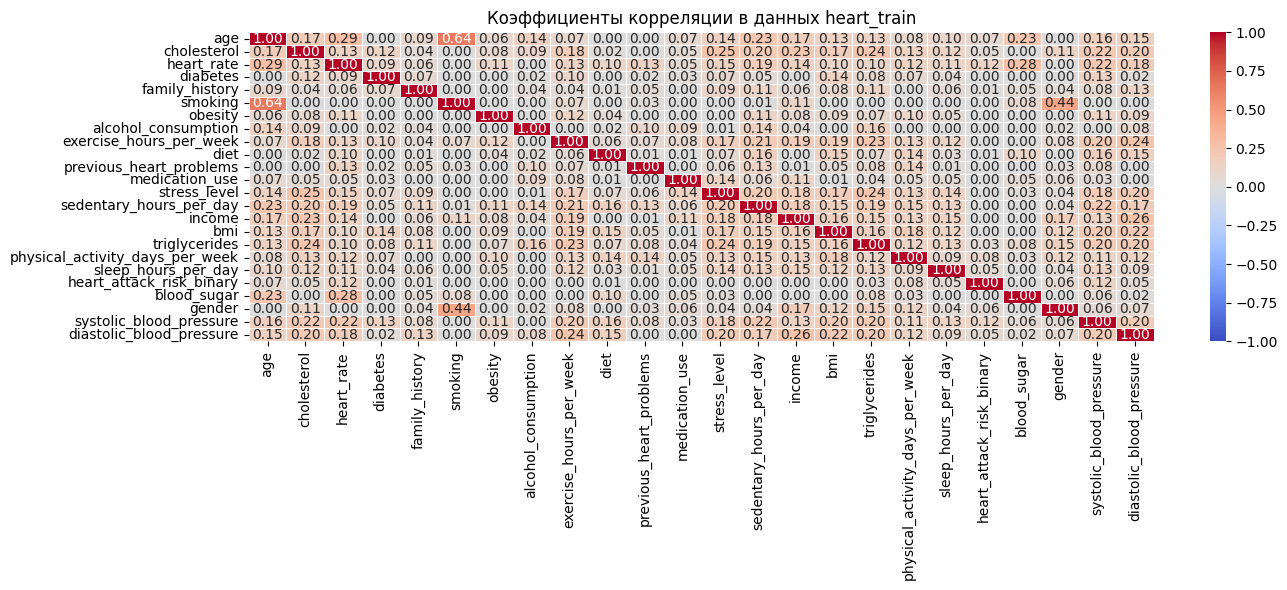

age  cholesterol  heart_rate  diabetes  \
age                              1.000000     0.172924    0.287425  0.000000   
cholesterol                      0.172924     1.000000    0.133598  0.116240   
heart_rate                       0.287425     0.133598    1.000000  0.092488   
diabetes                         0.000000     0.116240    0.092488  1.000000   
family_history                   0.086772     0.044313    0.059524  0.072930   
smoking                          0.641129     0.000000    0.000000  0.000000   
obesity                          0.063076     0.083910    0.105988  0.000000   
alcohol_consumption              0.137912     0.094786    0.000000  0.019440   
exercise_hours_per_week          0.071440     0.180567    0.129525  0.096152   
diet                             0.000000     0.022437    0.104614  0.000000   
previous_heart_problems          0.000000     0.000000    0.134701  0.017568   
medication_use                   0.065735     0.052463    0.052987  0.026980   
stress_level                     0.139026     0.253919    0.147673  0.074913   
sedentary_hours_per_day          0.230709     0.201496    0.185326  0.046434   
income                           0.167727     0.232643    0.140519  0.000000   
bmi                              0.132099     0.174465    0.104414  0.141585   
triglycerides                    0.128886     0.240200    0.102393  0.078100   
physical_activity_days_per_week  0.075054     0.134491    0.117463  0.065658   
sleep_hours_per_day              0.095103     0.120157    0.108201  0.043885   
heart_attack_risk_binary         0.068896     0.047106    0.121816  0.000000   
blood_sugar                      0.227841     0.000000    0.277979  0.000000   
gender                           0.000000     0.110520    0.000000  0.000000   
systolic_blood_pressure          0.162134     0.215360    0.222117  0.133706   
diastolic_blood_pressure         0.147312     0.200613    0.178488  0.016296   

                                 family_history   smoking   obesity  \
age                                    0.086772  0.641129  0.063076   
cholesterol                            0.044313  0.000000  0.083910   
heart_rate                             0.059524  0.000000  0.105988   
diabetes                               0.072930  0.000000  0.000000   
family_history                         1.000000  0.000000  0.000000   
smoking                                0.000000  1.000000  0.000000   
obesity                                0.000000  0.000000  1.000000   
alcohol_consumption                    0.036982  0.000000  0.000000   
exercise_hours_per_week                0.043599  0.072463  0.117999   
diet                                   0.010997  0.000000  0.042486   
previous_heart_problems                0.049912  0.030332  0.000000   
medication_use                         0.000000  0.000000  0.000000   
stress_level                           0.094082  0.000000  0.000000   
sedentary_hours_per_day                0.109402  0.013483  0.114600   
income                                 0.060021  0.112714  0.081125   
bmi                                    0.083391  0.000000  0.085524   
triglycerides                          0.110153  0.000000  0.069195   
physical_activity_days_per_week        0.000000  0.000000  0.098856   
sleep_hours_per_day                    0.056661  0.000000  0.050186   
heart_attack_risk_binary               0.011593  0.000000  0.000000   
blood_sugar                            0.051484  0.078740  0.000000   
gender                                 0.040128  0.443064  0.000000   
systolic_blood_pressure                0.077860  0.000000  0.112838   
diastolic_blood_pressure               0.130444  0.000000  0.093400   

                                 alcohol_consumption  exercise_hours_per_week  \
age                                         0.137912                 0.071440   
cholesterol                                 0.094786                 0.180567   
heart_rate        

In [111]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(heart,
                                title = 'Коэффициенты корреляции в данных heart_train',
                                columns = interval_columns)
display(corr_matrix)

In [112]:
# проведем беглый анализ корреляционной матрицы
corr_res = corr_analysis(corr_matrix, target_feature='heart_attack_risk_binary', min_abs_corr=1e-8)

In [113]:
# выведем результаты анализа корреляционной матрицы
display(corr_res)

Признак Корреляция    Сила связи    Направление
0                        heart_rate      0.122        Слабая  положительная
1           systolic_blood_pressure      0.119        Слабая  положительная
2   physical_activity_days_per_week      0.085  Очень слабая  положительная
3                               age      0.069  Очень слабая  положительная
4                            gender      0.055  Очень слабая  положительная
5          diastolic_blood_pressure      0.051  Очень слабая  положительная
6               sleep_hours_per_day      0.049  Очень слабая  положительная
7                       cholesterol      0.047  Очень слабая  положительная
8                     triglycerides      0.034  Очень слабая  положительная
9                    family_history      0.012  Очень слабая  положительная
10                             diet      0.006  Очень слабая  положительная
11                          obesity      0.000   Отсутствует  отрицательная
12                          smoking      0.000   Отсутствует  отрицательная
13                         diabetes      0.000   Отсутствует  отрицательная
14              alcohol_consumption      0.000   Отсутствует  отрицательная
15                           income      0.000   Отсутствует  отрицательная
16          sedentary_hours_per_day      0.000   Отсутствует  отрицательная
17                     stress_level      0.000   Отсутствует  отрицательная
18                   medication_use      0.000   Отсутствует  отрицательная
19          previous_heart_problems      0.000   Отсутствует  отрицательная
20          exercise_hours_per_week      0.000   Отсутствует  отрицательная
21                              bmi      0.000   Отсутствует  отрицательная
22                      blood_sugar      0.000   Отсутствует  отрицательная

**Комментарий**: слабые еле уловимые связи, нужно смотреть `SHAP` и `feature_importance`. Также наблюдается аномальная корреляция между признаками `smoking` и `gender`. Исследуем этот момент подробнее.

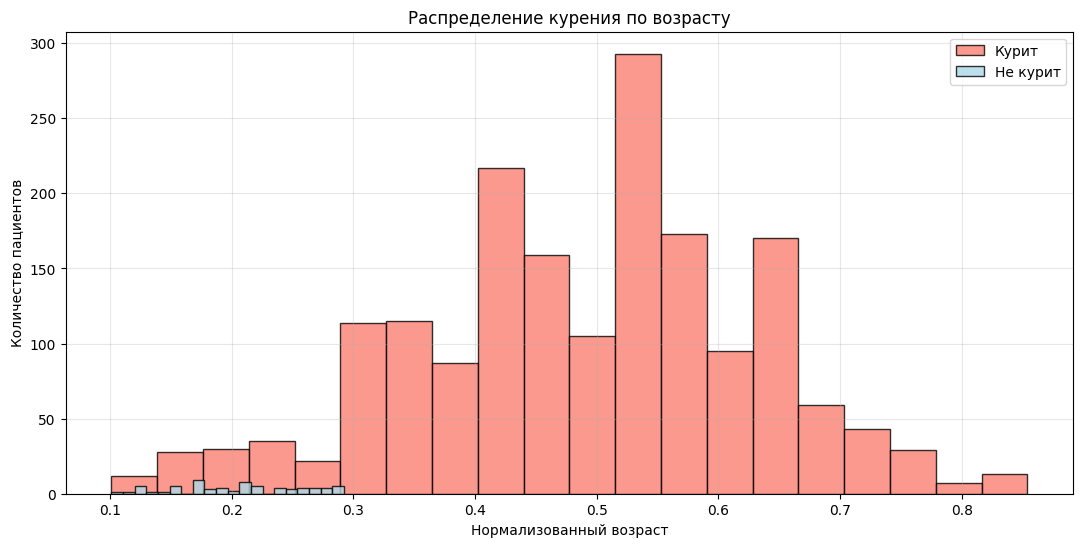

In [114]:
plt.figure(figsize=(13, 6))

# гистограмма для курящих
plt.hist(heart[heart['smoking'] == 1]['age'], 
         alpha=0.8, label='Курит', bins=20, color='salmon', edgecolor='black')

# гистограмма для некурящих  
plt.hist(heart[heart['smoking'] == 0]['age'],
         alpha=0.8, label='Не курит', bins=20, color='lightblue', edgecolor='black')

plt.xlabel('Нормализованный возраст')
plt.ylabel('Количество пациентов')
plt.title('Распределение курения по возрасту')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Распределение курения по полу (%):
smoking          0           1
gender                        
Female   12.126538   87.873462
Male      0.000000  100.000000

Абсолютные значения:
smoking   0     1
gender           
Female   69   500
Male      0  1306


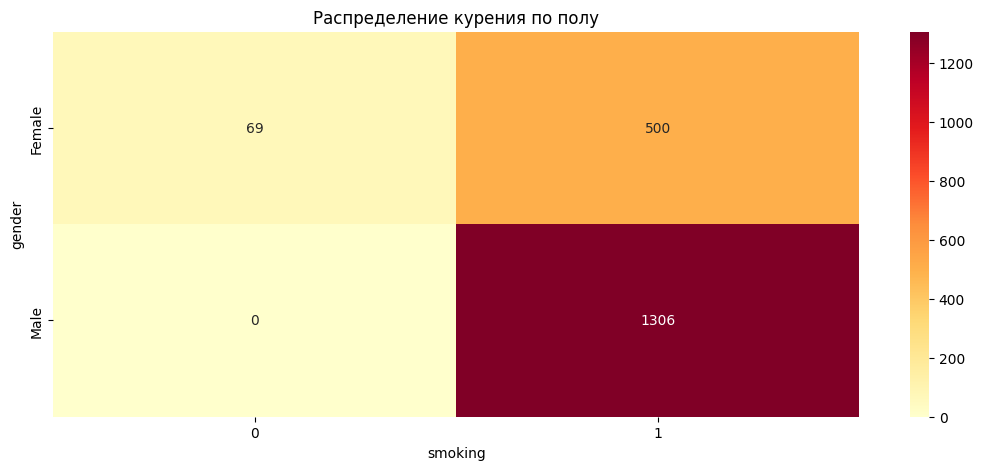

In [115]:
# получаем распределение по полу
smoking_by_gender = pd.crosstab(heart['gender'], heart['smoking'], normalize='index') * 100
print("Распределение курения по полу (%):")
print(smoking_by_gender)

# считаем абсолютные значения
smoking_counts = pd.crosstab(heart['gender'], heart['smoking'])
print("\nАбсолютные значения:")
print(smoking_counts)

# строим график
plt.figure(figsize=(13, 5))
sns.heatmap(smoking_counts, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Распределение курения по полу')
plt.show()

**Комментарий**: видим, что **100**% мужчин в выборке являются курильщиками (по `gender`) и также все, у кого возраст $>0.3$ в выборке являются курильщиками. На самом деле сам факт курения может существенную роль играть на предсказание, поэтому предпочтительнее убрать признак `gender`, что сделаем при процессе группировки признаков ниже.

### Промежуточный вывод

В целом видно, что необходима дополнительная работа с признаками, т.к. наблюдается низкий уровень корреляции с целевым.
Анализ признакак `smoking` выявил проблему его дисбаланса относительно возраста и пола. Т.к. сам по себе признак имеет важную роль, то было принято решение отбросить признак `gender`.

## <u>Группировка признаков</u>

**Комментарий**: по логике практически все признаки можно сгруппировать:
- Антропометрические признаки (`antrophometric_score` включает `bmi`, `obesity`, `age`)
- Признаки образа жизни и привычек (`lifestyle_score` включает `smoking`, `stress_level`, `alcohol_consumption`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `physical_activity_days_per_week`, `sleep_hours_per_day`)
- Признаки, связанные с анализами крови (`test_score` включает `cholesterol`, `triglycerides`, `blood_sugar`)
- Признаки, связанные с историей болезни (`medical_score` включает `medication_use`, `diabetes`, `previous_heart_problems`)

Следующие признаки оставим без группировки:
- `diet` -- нет информации о том, по какому принципу кодировались данные;
- `family_history` -- оставим как отдельный признак, т.к. наследственность может влиять, но по смыслу не относится ни к одному из групповых признаков;
- оставим признаки `heart_rate`, `systolic_blood_pressure`, `diastolic_blood_pressure` -- признаки в принципе можно было бы сгруппировать, но т.к. они уже нормализованы, то сложно восстановить связь между нижним и верхнем давление и ЧСС, лучше оставить их так, в этом случае не будет потери информативности, т.к. признаки непрерывные.

### Антропометрические признаки

**Комментарий**: сформируем признак `antrophometric_score`, который включает антропометрические показатели:
- ИМТ (`bmi`) -- т.к. распределение равномерное, то бинаризируем на пороге 0.5;
- ожирение (`obesity`);
- возраст (`age`) -- из исследовательского анализа данных берем основную группу пациентов, т.е. средний возраст и старше ($>0.4$);

In [116]:
# сформируем групповой признак
bmi_treshold = 0.5
age_treshold = 0.4
heart['antrophometric_score'] = (
    (heart['bmi'] > bmi_treshold).astype(int) +
    heart['obesity'] +
    (heart['age'] > age_treshold).astype(int)
)

### Признаки образа жизни и привычек

**Комментарий**: сформируем теперь признак `lifestyle_score`, который опирается на образ жизни и привычки:
- курение (`smoking`);
- уровень стресса, если он больше **7** -- высокий стресс (`stress_level`);
- употребление алкоголя (`alcohol_consumption`);
- кол-во часов упражнений в неделю (`exercise_hours_per_week`) -- т.к. распределение равномерное, то бинаризируем на пороге 0.5;
- кол-во часов в сидячем положении в сутки (`sedentary_hours_per_day`) -- т.к. распределение равномерное, то бинаризируем на пороге 0.5;
- кол-во дней с физической активностью в неделю (`physical_activity_days_per_week`) -- из исследовательского анализа видим, что менее 3 дней доля риска увеличивается;
- кол-во часов сна в сутки (`sleep_hours_per_day`) -- из исследовательского анализа видим, что менее 0.33 доля риска увеличивается.

In [117]:
# сформируем групповой признак
stress_treshold = 7
ex_treshold = 0.5
sed_treshold = 0.5
phys_treshold = 3
sleep_treshold = 0.33

heart['lifestyle_score'] = (
    heart['smoking'] +
    (heart['stress_level'] > stress_treshold ).astype(int) +
    heart['alcohol_consumption'] +
    (heart['exercise_hours_per_week'] < ex_treshold ).astype(int) +
    (heart['sedentary_hours_per_day'] > sed_treshold).astype(int) +
    (heart['physical_activity_days_per_week'] < phys_treshold).astype(int) +
    (heart['sleep_hours_per_day'] < sleep_treshold).astype(int)
)

### Признаки биохимических показателей крови

**Комментарий**: сформируем теперь признак `test_score`, который опирается на показатели анализов крови:
- холестерин в крови (`cholesterol`) -- т.к. распределение равномерное, то бинаризируем на пороге 0.5;
- триглецириды в крови (`triglycerides`) -- т.к. распределение равномерное, то бинаризируем на пороге 0.5;
- сахар в крови (`blood_sugar`) -- из исследовательского анализа данных возьмем медианное значение, как пороговое.

In [118]:
# сформируем групповой признак
chol_treshold = 0.5
trig_treshold = 0.5
sugar_treshold = 0.17
heart['test_score'] = (
    (heart['cholesterol'] > chol_treshold).astype(int) + 
    (heart['triglycerides'] > trig_treshold).astype(int) + 
    (heart['blood_sugar'] > sugar_treshold).astype(int)
)

### Признаки медицинской истории

**Комментарий**: сформируем теперь признак `medical_score`, который опирается на историю болезни пациента:
- принимает ли лекарства (`medication_use`);
- был ли диагностирован диабет (`diabetes`);
- был ли ранее проблемы с сердце (`previous_heart_problems`);

In [119]:
# сформируем групповой признак
heart['medical_score'] = (
    heart['medication_use'] +
    heart['diabetes'] +
    heart['previous_heart_problems']
)

### Повторный корреляционный анализ

**Комментарий**: после формирования групповых признаков, уберем исходные признаки из данных.

In [120]:
heart.drop(columns=['blood_sugar', 
                    'cholesterol', 
                    'triglycerides',
                    'smoking',
                    'stress_level',
                    'alcohol_consumption',
                    'exercise_hours_per_week',
                    'sedentary_hours_per_day',
                    'physical_activity_days_per_week',
                    'sleep_hours_per_day',
                    'income',
                    'bmi',
                    'obesity',
                    'age',
                    'diabetes',
                    'medication_use',
                    'previous_heart_problems',
                    'gender'
                    ], inplace=True)

**Комментарий**: посмотрим на новую матрицу корреляции.

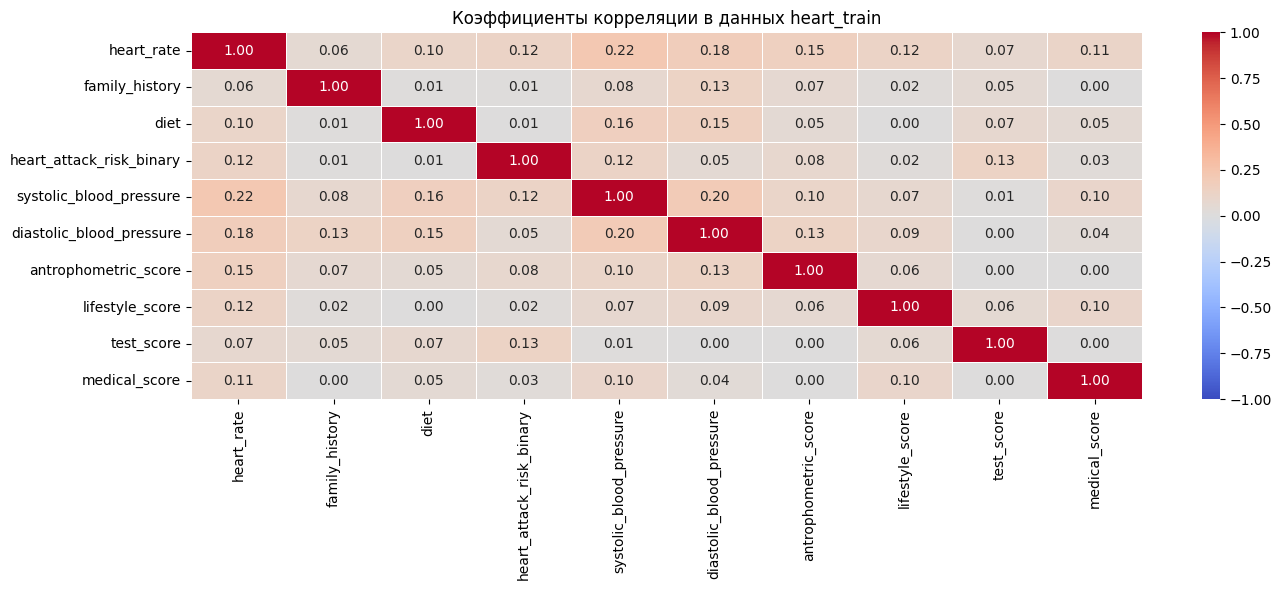

heart_rate  family_history      diet  \
heart_rate                  1.000000        0.059524  0.104614   
family_history              0.059524        1.000000  0.010997   
diet                        0.104614        0.010997  1.000000   
heart_attack_risk_binary    0.121816        0.011593  0.006338   
systolic_blood_pressure     0.222117        0.077860  0.159959   
diastolic_blood_pressure    0.178488        0.130444  0.152255   
antrophometric_score        0.151606        0.069895  0.049602   
lifestyle_score             0.117967        0.022639  0.000000   
test_score                  0.072563        0.049378  0.072637   
medical_score               0.110463        0.000000  0.054541   

                          heart_attack_risk_binary  systolic_blood_pressure  \
heart_rate                                0.121816                 0.222117   
family_history                            0.011593                 0.077860   
diet                                      0.006338                 0.159959   
heart_attack_risk_binary                  1.000000                 0.118928   
systolic_blood_pressure                   0.118928                 1.000000   
diastolic_blood_pressure                  0.050770                 0.198840   
antrophometric_score                      0.078362                 0.103071   
lifestyle_score                           0.016756                 0.070670   
test_score                                0.130369                 0.013006   
medical_score                             0.028786                 0.100766   

                          diastolic_blood_pressure  antrophometric_score  \
heart_rate                                0.178488              0.151606   
family_history                            0.130444              0.069895   
diet                                      0.152255              0.049602   
heart_attack_risk_binary                  0.050770              0.078362   
systolic_blood_pressure                   0.198840              0.103071   
diastolic_blood_pressure                  1.000000              0.129812   
antrophometric_score                      0.129812              1.000000   
lifestyle_score                           0.088870              0.062838   
test_score                                0.000000              0.000000   
medical_score                             0.035539              0.000000   

                          lifestyle_score  test_score  medical_score  
heart_rate                       0.117967    0.072563       0.110463  
family_history                   0.022639    0.049378       0.000000  
diet                             0.000000    0.072637       0.054541  
heart_attack_risk_binary         0.016756    0.130369       0.028786  
systolic_blood_pressure          0.070670    0.013006       0.100766  
diastolic_blood_pressure         0.088870    0.000000       0.035539  
antrophometric_score             0.062838    0.000000       0.000000  
lifestyle_score                  1.000000    0.059220       0.095293  
test_score                       0.059220    1.000000       0.000000  
medical_score                    0.095293    0.000000       1.000000

In [121]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(heart,
                                title = 'Коэффициенты корреляции в данных heart_train',
                                columns = interval_columns)
display(corr_matrix)

### Промежуточный вывод

Была выполнена группировка некоторых признаков по следующим приципам:

- Антропометрические признаки (`antrophometric_score` включает `bmi`, `obesity`, `age`)
- Признаки образа жизни и привычек (`lifestyle_score` включает `smoking`, `stress_level`, `alcohol_consumption`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `physical_activity_days_per_week`, `sleep_hours_per_day`)
- Признаки, связанные с анализами крови (`test_score` включает `cholesterol`, `triglycerides`, `blood_sugar`)
- Признаки, связанные с историей болезни (`medical_score` включает `medication_use`, `diabetes`, `previous_heart_problems`)

Следующие признаки были оставлены без группировки:
- `diet` -- нет информации о том, по какому принципу кодировались данные;
- `family_history` -- оставим как отдельный признак, т.к. наследственность может влиять, но по смыслу не относится ни к одному из групповых признаков;
- оставим признаки `heart_rate`, `systolic_blood_pressure`, `diastolic_blood_pressure` -- признаки в принципе можно было бы сгруппировать, но т.к. они уже нормализованы, то сложно восстановить связь между нижним и верхнем давление и ЧСС, лучше оставить их так, в этом случае не будет потери информативности, т.к. признаки непрерывные.

## <u>Обучение модели</u>

**Комментарий**: перейдем теперь к подготовки данных и обучению модели.

### Подготовка данных

**Комментарий**: т.к. у нас имеется изначально тренировочная выборка, то предлагается разбить ее на подвыборки -- обучающую и валидационную.

In [122]:
X = heart.drop('heart_attack_risk_binary', axis=1)
y = heart['heart_attack_risk_binary']
target_feature = 'heart_attack_risk_binary'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # сохраняем пропорции целевого признака
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_test)}\n")
print(f"Пропроция целевого признака в обучающей выборке:\n{y_train.value_counts(normalize=True)}\n")
print(f"Пропроция целевого признака в валидационной выборке:\n{y_test.value_counts(normalize=True)}")

Размер обучающей выборки: 1406
Размер валидационной выборки: 469

Пропроция целевого признака в обучающей выборке:
heart_attack_risk_binary
0    0.665007
1    0.334993
Name: proportion, dtype: float64

Пропроция целевого признака в валидационной выборке:
heart_attack_risk_binary
0    0.665245
1    0.334755
Name: proportion, dtype: float64


In [123]:
# формируем списки признаков
num_columns = heart.drop(columns=['heart_attack_risk_binary']).columns.tolist()

**Комментарий**:

In [124]:
# количественные признаки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns)
    ])

**Промежуточный вывод**:

### Выбор метрики

Для CV будем использовать `roc_auc`, а на валидационной выборке полную метрику (следим за ```precision```, ```recall```, ```f1/f2```).

В целом не ясно, какую задачу будет решать модель, поэтому также оставим возможность настройки порога между ```precision``` и ```recall``` и будем искать исходя из баланса и того, и другого (построим кривую `precision-recall`). Возможность изменить порог в дальнейшем заложим в функционал приложения.

Для чего это нужно: при максимизации `recall` мы будет чаще находить пациентов, которые действительно обладают риском, однако вместе с ними чаще будем предсказывать риск здоровым пациентам. В этом случае мы можем создать нагрузку на систему здравоохранения, отправляя здоровых на доп. исследования. В ином случае, при низком `recall` сиутация становится с точностью да наоборот.

Поэтому еще раз следует подчеркнуть -- т.к. не сформулирована окончательная задача, где и как будет использоваться модель, то внедряем возможность менять порог.

### Обучение модели

**Комментарий**: сформируем перечень моделей для обучения и составим диапазоны гиперпараметров для перебора.

In [125]:
# составим список моделей и наборов гиперпараметров
scalers = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}
models = [
    {
        'model': DummyClassifier(),
        'params': {
            'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform'],
            **scalers
        },
        'name': 'Dummy'
    },
    {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__solver': ['liblinear', 'saga'],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'LogisticRegression'
    },
    {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [3, 5, 7, 10, 12, 14, 16, 18],
            'model__min_samples_split': [2, 5, 10, 12, 14, 16, 18],
            'model__min_samples_leaf': [1, 2, 4, 6, 8],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'DecisionTreeClassifier'
    },
    {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [50, 100, 200, 500, 1000],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5, 6],
            'model__subsample': [0.4, 0.6, 0.8, 1.0],
            **scalers
        },
        'name': 'GradientBoostingClassifier'
    },
    {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            **scalers
        },
        'name': 'KNeighborsClassifier'
    },
    {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'RandomForestClassifier'
    },
    {
        'model': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [3, 6, 9],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__subsample': [0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.8, 0.9, 1.0],
            'model__scale_pos_weight': [1, len(y_train[y_train==0])/len(y_train[y_train==1])],
            'model__verbose': [0],
            **scalers
        },
        'name': 'XGBClassifier'
    },
    {
    'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'params': {
        'model__iterations': [100, 200, 500, 1000],
        'model__depth': [4, 6, 8, 12],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__border_count': [32, 64, 128],
        **scalers
    },
    'name': 'CatBoostClassifier'
}
]

In [126]:
# в цикле выполним подбор параметров, замеряем время обучения, предсказания и подборов параметров
results = []
for mdl in models:
    results.append(evaluate_model(mdl['model'], 
                                  mdl['params'], 
                                  mdl['name'],
                                  X_train,
                                  y_train,
                                  data_preprocessor,
                                  data_preprocessor,
                                  refit_metric='roc_auc',
                                  random_state = RANDOM_STATE,
                                  cv=5,
                                  n_iter=10))

Модель: Dummy
Лучшие параметры: {'preprocessor__num__scaler': RobustScaler(), 'model__strategy': 'stratified'}
Время подбора параметров: 1.771 с.
Время обучения лучшей модели: 0.018 с.
Время предсказания лучшей модели: 0.051 с.
Accuracy на кросс-валидации: 0.5591
Precision на кросс-валидации: 0.3380
Recall на кросс-валидации: 0.3292
ROC-AUC на кросс-валидации: 0.5153
F1-score на кросс-валидации: 0.3331
F2-score на кросс-валидации: 0.3307
Average Precision на кросс-валидации: 0.3433

Для линейной модели LogisticRegression используется OneHotEncoder
Модель: LogisticRegression
Лучшие параметры: {'preprocessor__num__scaler': StandardScaler(), 'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 1000, 'model__class_weight': None, 'model__C': 10.0}
Время подбора параметров: 0.543 с.
Время обучения лучшей модели: 0.024 с.
Время предсказания лучшей модели: 0.044 с.
Accuracy на кросс-валидации: 0.6650
Precision на кросс-валидации: 0.0000
Recall на кросс-валидации: 0.0000
ROC-AUC 

In [127]:
# сформируем DataFrame из итоговых результатов и выведем таблицу
results_df = pd.DataFrame(results).copy()
if not results_df.empty:
    # выведем таблицу с результатами по всем моделям
    print("Итоговые результаты:")
    display(results_df[['model_name', 
                    'accuracy_cv', 
                    'precision_cv',
                    'recall_cv',
                    'roc_auc_cv',
                    'average_precision_cv',
                    'f1_cv',
                    'f2_cv',
                    'params_time',
                    'train_time',
                    'predict_time']].sort_values(['roc_auc_cv'],
                                                 ascending=False).reset_index(drop=True))

    # лучшая модель по recall
    best_model_metrics = results_df.sort_values(['roc_auc_cv'],
                                                ascending=False).iloc[0]

    # выводим результат
    print(f"Лучшая модель: {best_model_metrics['model_name']}") 
    print(f"Average Precision на кросс-валидации = {best_model_metrics['average_precision_cv']:.4f}")
    print(f"Recall на кросс-валидации = {best_model_metrics['recall_cv']:.4f}")
    print(f"ROC-AUC на кросс-валидации = {best_model_metrics['roc_auc_cv']:.4f}")
    print(f"F1-score на кросс-валидации = {best_model_metrics['f1_cv']:.4f}")
    print(f"F2-score на кросс-валидации = {best_model_metrics['f2_cv']:.4f}")
    print(f"Accuracy на кросс-валидации = {best_model_metrics['accuracy_cv']:.4f}")
    print(f"Precision на кросс-валидации = {best_model_metrics['precision_cv']:.4f}")
    print(f"train_time = {best_model_metrics['train_time']:.3f} с.")
    print(f"predict_time = {best_model_metrics['predict_time']:.3f} c.")

    best_final_model = best_model_metrics['best_model']
else:
    print("Ошибка в получении модели!")

Итоговые результаты:


model_name  accuracy_cv  precision_cv  recall_cv  \
0  GradientBoostingClassifier     0.717637      0.604081   0.456506   
1      RandomForestClassifier     0.743252      0.744472   0.356753   
2          CatBoostClassifier     0.706971      0.595161   0.407704   
3               XGBClassifier     0.703395      0.562677   0.517984   
4        KNeighborsClassifier     0.695555      0.557130   0.475521   
5      DecisionTreeClassifier     0.640087      0.474572   0.551915   
6                       Dummy     0.559060      0.337977   0.329250   
7          LogisticRegression     0.665008      0.000000   0.000000   

   roc_auc_cv  average_precision_cv     f1_cv     f2_cv  params_time  \
0    0.755213              0.646900  0.519746  0.479815    14.167706   
1    0.751101              0.656305  0.481521  0.397933    12.855558   
2    0.744884              0.638890  0.483192  0.434777    23.427363   
3    0.743347              0.619428  0.538992  0.526098     2.516508   
4    0.707677              0.567188  0.512467  0.489519     1.596909   
5    0.645108              0.467828  0.504794  0.530474     0.808125   
6    0.515320              0.343270  0.333124  0.330681     1.771186   
7    0.483719              0.348973  0.000000  0.000000     0.542574   

   train_time  predict_time  
0    1.872048      0.046443  
1    2.059150      0.215026  
2    6.274867      0.054180  
3    0.293579      0.050889  
4    0.019311      0.064769  
5    0.022599      0.041000  
6    0.018000      0.051400  
7    0.024399      0.043801

Лучшая модель: GradientBoostingClassifier
Average Precision на кросс-валидации = 0.6469
Recall на кросс-валидации = 0.4565
ROC-AUC на кросс-валидации = 0.7552
F1-score на кросс-валидации = 0.5197
F2-score на кросс-валидации = 0.4798
Accuracy на кросс-валидации = 0.7176
Precision на кросс-валидации = 0.6041
train_time = 1.872 с.
predict_time = 0.046 c.


### Промежуточный вывод

Была сформирована тестовая и валидационная выброки с ratio 0.25.
После этого выполнялся подбор лучшей модели и её гиперпараметров.

По результатам лучшей моделью оказался классификатор `GradientBoostingClassifier` с метриками:
- Recall на кросс-валидации = 0.4565
- ROC-AUC на кросс-валидации = 0.7552
- F1-score на кросс-валидации = 0.5197
- F2-score на кросс-валидации = 0.4798
- Accuracy на кросс-валидации = 0.7176
- Precision на кросс-валидации = 0.6041

## <u>Тестирование модели</u>

**Комментарий**: выполним тестирование лучшей найденной модели на валидационной выборке. 

In [128]:
# выведем модель
print(best_final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   'passthrough')]),
                                                  ['heart_rate',
                                                   'family_history', 'diet',
                                                   'systolic_blood_pressure',
                                                   'diastolic_blood_pressure',
                                                   'antrophometric_score',
                                                   'lifestyle_score',
                                                   'test_score',
                                                   'medical

Метрики на тестовой выборке для финальной модели GradientBoostingClassifier:
Accuracy: 0.7740
Precision: 0.7179
Recall: 0.5350
F1-score: 0.6131
F2-score: 0.5638
ROC-AUC: 0.8112
Average Precision: 0.7302

Матрица ошибок:
[[279  33]
 [ 73  84]]


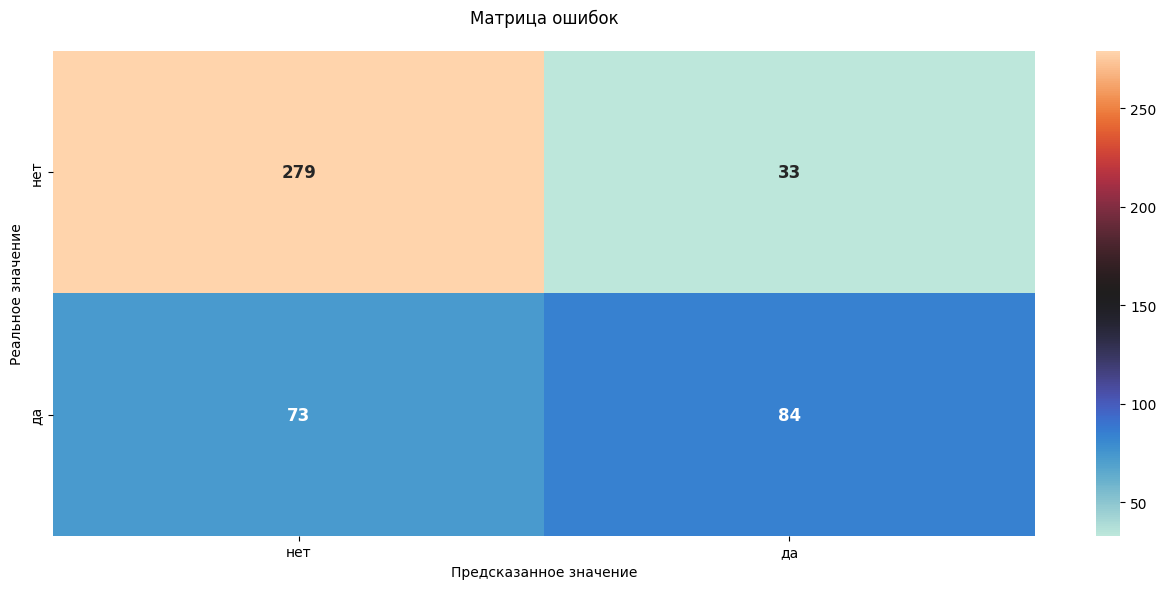

Интерпретация:
  Правильно предсказано 'нет' (True Negative): 279
  Ложно предсказано 'да' (False Positive): 33
  Ложно предсказано 'нет' (False Negative): 73
  Правильно предсказано 'да' (True Positive): 84


In [129]:
y_pred = best_final_model.predict(X_test)
y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Метрики на тестовой выборке для финальной модели {best_model_metrics['model_name']}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# выведем матрицу ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(cm)

**Комментарий**: на валидационных данных метрика получилась даже лучше, чем на CV:
- Accuracy: 0.7740
- Precision: 0.7179
- Recall: 0.5350
- F1-score: 0.6131
- F2-score: 0.5638
- ROC-AUC: 0.8112
- Average Precision: 0.7302

Рассмотрим теперь кривую `precision-recall` и подберем оптимальный порог по умолчанию.

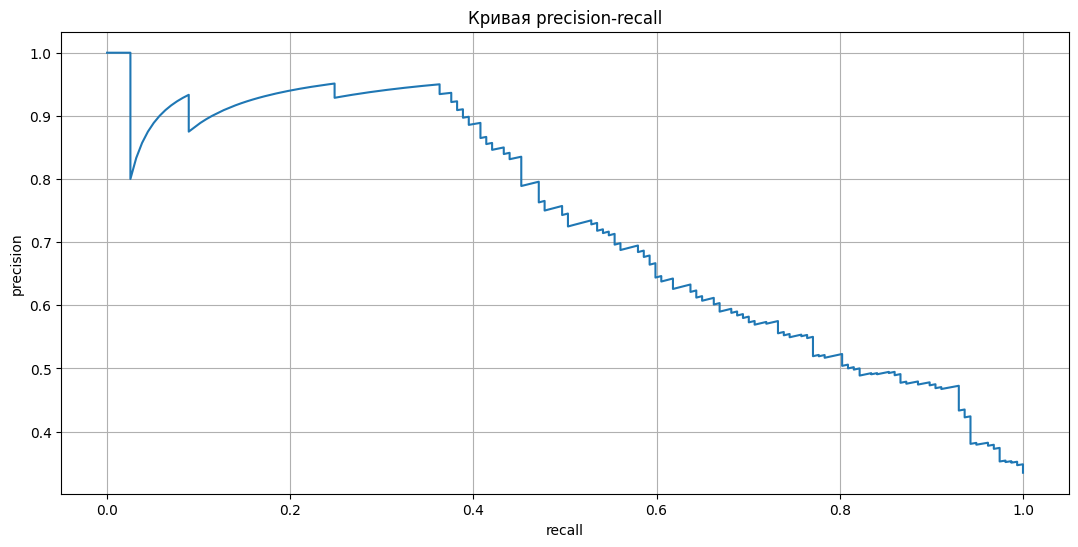

Recall 0.1: threshold=0.996, precision=0.875, f1=0.162
Recall 0.2: threshold=0.993, precision=0.938, f1=0.317
Recall 0.3: threshold=0.987, precision=0.939, f1=0.447
Recall 0.4: threshold=0.924, precision=0.886, f1=0.546
Recall 0.5: threshold=0.597, precision=0.731, f1=0.596
Recall 0.6: threshold=0.355, precision=0.648, f1=0.623
Recall 0.7: threshold=0.115, precision=0.576, f1=0.632
Recall 0.75: threshold=0.062, precision=0.549, f1=0.632
Recall 0.8: threshold=0.027, precision=0.506, f1=0.621
Recall 0.85: threshold=0.015, precision=0.494, f1=0.626
Recall 0.9: threshold=0.009, precision=0.475, f1=0.621
Recall 1.0: threshold=0.000, precision=0.335, f1=0.502


In [130]:
if hasattr(best_final_model.named_steps['model'], 'predict_proba'):
    y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]
else:
    # для SVC используем decision_function
    y_pred_proba = best_final_model.decision_function(X_test)
    # нормализуем к [0, 1]
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# строим PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# строим график
plt.figure(figsize=(13, 6))
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Кривая precision-recall')
plt.grid(True)
plt.show()

# смотрим варианты порогов
results_r = []
for target_recall in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    # находим ближайший порог
    idx = np.argmin(np.abs(recall[:-1] - target_recall))
    threshold = thresholds[idx]
    
    # применяем порог
    y_pred_custom = (y_pred_proba > threshold).astype(int)
    
    # cчитаем метрики
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    results_r.append({
        'target_recall': target_recall,
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"Recall {target_recall}: threshold={threshold:.3f}, precision={prec:.3f}, f1={f1:.3f}")


In [131]:
#  оптимальный порог
optimal_threshold = 0.25

# вероятности на тестовой выборке
y_pred_proba_test = best_final_model.predict_proba(X_test)[:, 1]

# используем порог
y_pred_custom = (y_pred_proba_test > optimal_threshold).astype(int)


print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom):.4f}")
print(f"F1: {f1_score(y_test, y_pred_custom):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_custom))

Accuracy: 0.7484
Precision: 0.6211
Recall: 0.6369
F1: 0.6289
ROC-AUC: 0.8112

Матрица ошибок:
[[251  61]
 [ 57 100]]


**Промежуточный вывод**: на валидационных данных метрика получилась даже лучше, чем на CV. 
Был подобран оптимальный порог классификации $0.25$, который дает метрику:
- Accuracy: 0.7484
- Precision: 0.6211
- Recall: 0.6369
- F1: 0.6289
- ROC-AUC: 0.8112

## <u>Анализ фажности признаков</u>

**Комментарий**: выполним теперь анализ важности признаков

In [132]:
# получаем имена 
feature_names = best_final_model.named_steps['preprocessor'].get_feature_names_out()
    
# подготавливаем данные
X_sample = best_final_model.named_steps['preprocessor'].transform(X_test)
  
model = best_final_model.named_steps['model']
model_name = best_model_metrics['model_name']

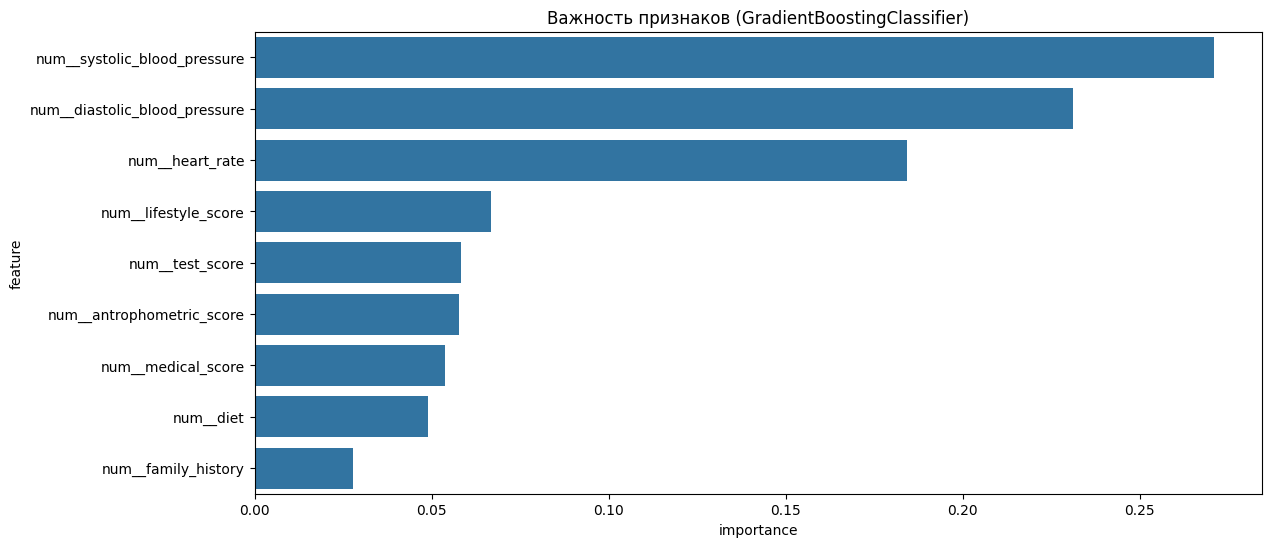


Топ-20 важных признаков:
                         feature  importance
3   num__systolic_blood_pressure    0.271089
4  num__diastolic_blood_pressure    0.231100
0                num__heart_rate    0.184188
6           num__lifestyle_score    0.066905
7                num__test_score    0.058173
5      num__antrophometric_score    0.057794
8             num__medical_score    0.053819
2                      num__diet    0.049110
1            num__family_history    0.027822


In [133]:
# feature importance (стандартная)
if hasattr(model, 'feature_importances_'):
    importance = model.feature_importances_
        
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
        
    plt.figure(figsize=(13, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title(f'Важность признаков ({best_model_metrics["model_name"]})')
    plt.show()
        
    print("\nТоп-20 важных признаков:")
    print(importance_df.head(20))
else:
    print(f"Модель {model_name} не имеет атрибута feature_importances_")


SHAP анализ для GradientBoostingClassifier:
Используется TreeExplainer для GradientBoostingClassifier


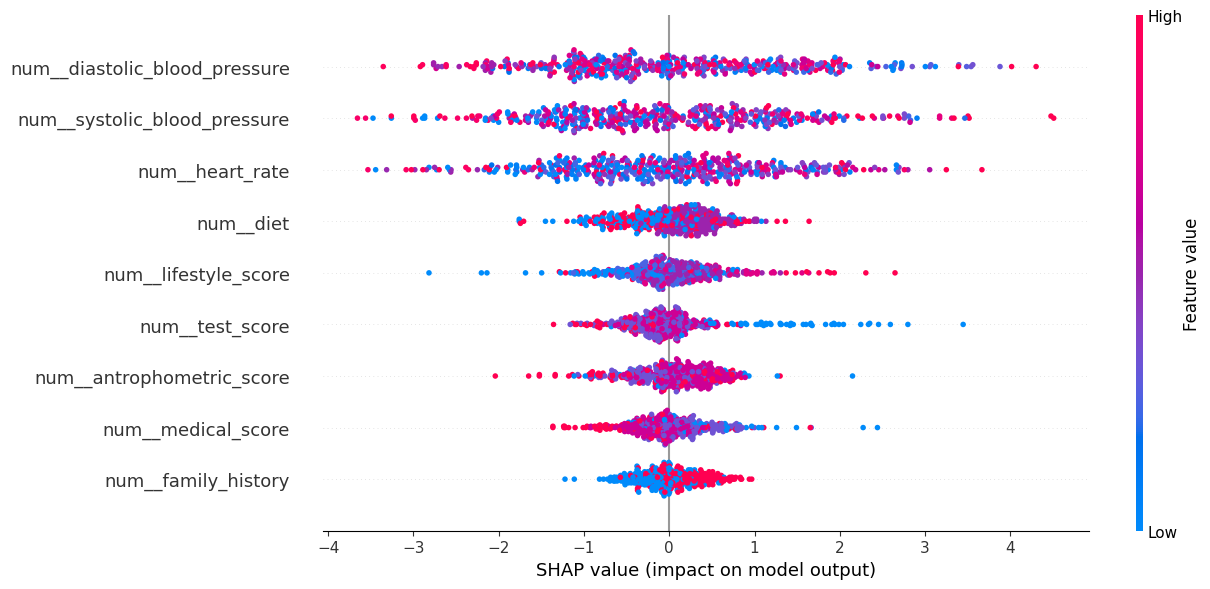

In [134]:
print(f"\nSHAP анализ для {best_model_metrics['model_name']}:")
try:
    if any(tree_model in model_name for tree_model in 
           ['RandomForest', 'DecisionTree', 'XGB', 'LGBM', 'CatBoost', 'GradientBoosting']):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        
    elif 'SVC' in model_name:
        background = shap.sample(X_sample, 100)
        explainer = shap.KernelExplainer(model.predict, background)
        shap_values = explainer.shap_values(X_sample)
        
    elif 'LogisticRegression' in model_name:
        explainer = shap.LinearExplainer(model, X_sample)
        shap_values = explainer.shap_values(X_sample)
        
    else:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)
    
    print(f"Используется {type(explainer).__name__} для {model_name}")
    
    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.gcf().set_size_inches(13, 6)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при SHAP анализе: {str(e)}")

### Промежуточный вывод

Из всех использовавшихся признаков, в целом, видно, что групповые признаки имеют практически одинаковую значимость.

## <u>Сохранение итоговой модели</u>

**Комментарий**: выполним сохранение весов модели для дальнейшего использования в приложении. При разработке приложения будем учитывать необходимость группировки признаков и отбрасыванием ненужных столбцов.

In [135]:
# формируем метаданные модели
model_info = {
    'model': best_final_model,
    'metadata': {
    'model_type': 'GradientBoosting', # название модели
    'feature_names': ['heart_rate', 'family_history', 'diet', 'systolic_blood_pressure', 
                     'diastolic_blood_pressure', 'antrophometric_score', 'lifestyle_score', 
                     'test_score', 'medical_score'], # перечень итоговых признаков
    # далее идут списки исходных признаков, которые попадают в ту или иную группу
    'features_groups': {'antrophometric_score': ['bmi', 
                                                 'obesity', 
                                                 'age'
                                                 ],
                        'lifestyle_score': ['smoking', 
                                            'stress_level', 
                                            'alcohol_consumption', 
                                            'exercise_hours_per_week', 
                                            'sedentary_hours_per_day',
                                            'physical_activity_days_per_week',
                                            'sleep_hours_per_day'
                                            ],
                        'test_score': ['cholesterol',
                                       'triglycerides',
                                      'blood_sugar'],
                        'medical_score': ['medication_use',
                                           'diabetes',
                                           'previous_heart_problems'
                                           ]
                        },
    # здесь сохраняем пороги при группировке
     'grouped_features_tresholds': {'bmi': bmi_treshold,
                                    'age': age_treshold,
                                    'stress_level': stress_treshold,
                                    'exercise_hours_per_week': ex_treshold,
                                    'sedentary_hours_per_day': sed_treshold,
                                    'physical_activity_days_per_week': phys_treshold,
                                    'sleep_hours_per_day': sleep_treshold,
                                    'cholesterol': chol_treshold,
                                    'triglycerides': trig_treshold,
                                    'blood_sugar': sugar_treshold,
                                    },
    # сохраняем то, что выкидываем
    'drop_features': ['gender', 'ck-mb', 'troponin', 'income'],
    # название целевого, на всякий случай
    'target_feature': 'heart_attack_risk_binary',
    # сохраняем оптимально подобранный порог
    'threshold': optimal_threshold
    }
}

# делаем дамп
try:
    joblib.dump(model_info, 'model\\model_complete.pkl');
    print("Модель успешно сохранена!")
except:
    print("Ошибка сохранения модели!")

Модель успешно сохранена!


**Промежуточный вывод**: модель сохранена, добавлены также метаданные.

## <u>Итоговый вывод</u>

Целью проекта являлось создание модели машинного обучения, которая позволит осуществлять предсказание риска поражения сердца на основе данных о пациентах, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

Для создания самой модели машинного обучения, необходимо решить следующие задачи:
1. Загрузить тренировочные данные и изучить информацию о них
2. Осуществить предварительную обработку данных
3. Выполнить исследовательский и корреляционный анализ данных
4. Подготовить обучающую выборку
5. Выбрать релевантные метрики для модели
6. Осуществить поиск наилучшей модели с подбором гиперпараметров на кросс-валидации
7. Выполнить проверку модели
8. Сохранить модель для дальнейшего её использования в приложении

Были выполнены следующие шаги:
1. По результатам загрузки и предобработки данных:
    - Выполнен первичный отбор признаков: признаки `CK-MB` и `Troponin` убраны, т.к. они являются не воспроизводимыми, признак `id` убран, т.к. он неинформативен;
    - Выполнено переименование столбцов с приведением к `snake_case` формату.
    - В данных обнаружено и удалено **243** строки с пропусками ($\sim2.8$% от общего кол-ва записей);
    - Данные в столбцах `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `previous_heart_problems`, `heart_attack_risk_binary` приведены к типу `int`, т.к. это целочисленные значения;
    - В данных обнаружено и удалено **12** явных дубликатов.
2. Был выполнен исследовательский анализ данных:
    - Отметим, что **нет информации о нормализации данных, а также о том, как закодированы категориальные признаки!**
    - В целом в данных не наблюдается какого-то ярковыраженного смещения и зависимости риска проблем с множеством показателей из набора данных (`cholesterol`, `exercies_hours_per_week`, `income`, `triglycerides`, `diastolic_blood_pressure`, `diabetes`, `family_history`, `obesity`, `alcohol_consumption`, `diet`, `medication_use`, `previous_heart_problems`). Хотя по логике и исходя из исследований, многие из этих признаков должны оказывать влияние. Такая ситуация может говорить о том, что ***обучающая выборка малорепрезентативна, обладает низким качеством данных***;
    - На основе анализа показателя сахара в крови, было отброшено $\sim70\%$ данных, которые зашумляли выборку. Основное количество оставшихся в выборке пациентов сосредоточено в области $(0.1; 0.2]$ нормализованного показателя сахара в крови ($\sim1000$ пацентов);
    - Наблюдается дисбаланс в целевом признаке (1 к 2). Важно это учитывать при формировании выборки (стратификация), и при настройке и обучении моделей (например, балансировочные веса для бустинга и деревьев);
3. Был выполнен корреляционный анализ данных:
    - По результатам видно, что необходимо было провести дополнительную работу с признаками, т.к. наблюдается низкий уровень корреляции с целевым. Анализ признакак `smoking` выявил проблему его дисбаланса относительно возраста и пола. Т.к. сам по себе признак имеет важную роль, то было принято решение отбросить признак `gender`.
4. Была выполнена группировка некоторых признаков по следующим приципам:
    - Антропометрические признаки (`antrophometric_score` включает `bmi`, `obesity`, `age`)
    - Признаки образа жизни и привычек (`lifestyle_score` включает `smoking`, `stress_level`, `alcohol_consumption`, `exercise_hours_per_week`, `sedentary_hours_per_day`, `physical_activity_days_per_week`, `sleep_hours_per_day`)
    - Признаки, связанные с анализами крови (`test_score` включает `cholesterol`, `triglycerides`, `blood_sugar`)
    - Признаки, связанные с историей болезни (`medical_score` включает `medication_use`, `diabetes`, `previous_heart_problems`)

Следующие признаки были оставлены без группировки:
- `diet` -- нет информации о том, по какому принципу кодировались данные;
- `family_history` -- оставим как отдельный признак, т.к. наследственность может влиять, но по смыслу не относится ни к одному из групповых признаков;
- оставим признаки `heart_rate`, `systolic_blood_pressure`, `diastolic_blood_pressure` -- признаки в принципе можно было бы сгруппировать, но т.к. они уже нормализованы, то сложно восстановить связь между нижним и верхнем давление и ЧСС, лучше оставить их так, в этом случае не будет потери информативности, т.к. признаки непрерывные.

5. Затем выполнялось разбиение данных на тренировочную и валидационную выборки, обучение модели.
6. По результатам лучшей моделью оказался классификатор `GradientBoostingClassifier` с метриками:
    - Recall на кросс-валидации = 0.4565
    - ROC-AUC на кросс-валидации = 0.7552
    - F1-score на кросс-валидации = 0.5197
    - F2-score на кросс-валидации = 0.4798
    - Accuracy на кросс-валидации = 0.7176
    - Precision на кросс-валидации = 0.6041
7. Модель затем проверялась на валидационных данных -- метрика получилась даже лучше, чем на CV. 
Был подобран оптимальный порог классификации $0.25$, который дает метрику:
    - Accuracy: 0.7484
    - Precision: 0.6211
    - Recall: 0.6369
    - F1: 0.6289
    - ROC-AUC: 0.8112

Общая точность модели составляет $75\%$ `Precision` и `recall` -- оба показателя около 62-64%, что указывает на то, что модель одинаково часто ошибается как в ложноположительных, так и в ложноотрицательных прогнозах.
`ROC-AUC`$=0.81$ -- модель относительно неплохо ранжирует пациентов по уровню риска. Собственно возможность настройки порога, позволит улучшить либо `precision` (меньше ложных тревог), либо `recall` (меньше пропущенных случаев риска).

По результатам работы следует отметить низкое качество данных, однако с помощью группировки признаков и обработки данных удалось достичь более-менее удовлетворительных показателей метрик, что в целом лучше случайного угадывания. Результирующая модель сохранена с метаданными для дальней работы с ней. Метаданые содержат информацию о группах признаков, оптимальном пороге классификации (`treshold`), перечень признаков (`feature_names`) и пороги при группировке (`grouped_features_tresholds`), признаки, которые отбрасываются(`drop_features`), название целевого признака (`target_feature`).